# Project Overview

Supplementary notebook to study SPECIFIC DELAY

See EMN_Modeling_Overall.ipynb for Business Problems and Analysis

## Package Imports

In [1]:
# basic tools
import pandas as pd
import numpy as np
from numpy import argmax
import time
from collections import Counter

# preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# scoring and algorithm selection packages
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import cross_validate, HalvingGridSearchCV, learning_curve, StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc, classification_report, confusion_matrix 
from sklearn.metrics import plot_confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, jaccard_score
from sklearn.inspection import permutation_importance
from yellowbrick.model_selection import LearningCurve

# resampling packages
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks, RandomUnderSampler

# model packages
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

# visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import umap.plot
%matplotlib inline

# ignore warnings (gets rid of Pandas copy warnings)
import warnings
warnings.filterwarnings('ignore')


## Notebook Functions

### Pipeline Cleaning Functions

In [2]:
def pipeline_fit_preprocessor(x):
    
    ''' Takes in a dataframe and adds polynomial features and scaling
    arguments: dataframe
    returns: transformed dataframe and fit pipe object'''
    
    
    # Create a column transformer to add polynomial features to Segment Number
    print("Setting up transforms - Polynomials, StandardScaler")
    poly_transforms = ColumnTransformer(transformers=[
        ("polys", PolynomialFeatures(degree=3, include_bias=False), poly_features),
        ], remainder="passthrough") 
    
    

    print('Setting up processing pipeline')
    pipe = Pipeline([
                ('transforms1', poly_transforms),
                ('scl', StandardScaler()),
            ])
    
    print('Fitting pipeline on train data')
    transformed_data = pipe.fit_transform(x)
    
    # Re-apply labels
    category_labels = list(x.columns)
    category_labels.remove('SEGMENT_NUMBER')
    category_labels.remove('DEP_BLOCK_HIST')
    all_cols = ['SEGMENT_NUMBER', "DEP_BLOCK_HIST", "SEGMENT_POLY", "JUNK",  "DEP_BLOCK_HIST_POLY", "SEGMENT_POLY2", 
               "JUNK2", "JUNK3", "DEP_BLOCK_HIST_POLY2"]+list(category_labels)
    
    df= pd.DataFrame(transformed_data,  columns=all_cols, index=x.index)
    df.drop(['JUNK', 'JUNK2', 'JUNK3'], axis=1, inplace=True)
    
    return df, pipe

def pipeline_transform_preprocessor(x, pipe):
    
    ''' Takes in a dataframe and fit pipe object,
    and adds polynomial features and scaling
    arguments: dataframe, pipe object
    returns: transformed dataframe'''
    
    print('Transforming test data')
    transformed_data = pipe.transform(x)
    
    # Re-apply labels
    category_labels = list(x.columns)
    category_labels.remove('SEGMENT_NUMBER')
    category_labels.remove('DEP_BLOCK_HIST')
    all_cols = ['SEGMENT_NUMBER', "DEP_BLOCK_HIST", "SEGMENT_POLY", "JUNK",  "DEP_BLOCK_HIST_POLY", "SEGMENT_POLY2", 
               "JUNK2", "JUNK3", "DEP_BLOCK_HIST_POLY2"]+list(category_labels)
    
    df= pd.DataFrame(transformed_data,  columns=all_cols, index=x.index)
    df.drop(['JUNK', 'JUNK2', 'JUNK3'], axis=1, inplace=True)
    
    return df

### Tuning Functions

In [3]:
def grid_optimizer(model, grid, x, y):
    
    '''Takes in a model and a grid of hyperparameters, and runs a HalvingGridSearch
    arguments: model, parameter grid, x and y to check parameter grid
    returns: best parameters'''
    
    start=time.time()
    
    print("Making Search")
    grid_search = HalvingGridSearchCV(model, grid, verbose=10, scoring='f1_macro', cv=5, min_resources='exhaust')

    print("Running Grid")
    grid_search.fit(x, y)

    grid_search.best_estimator_
    
    # Best f1
    print('Best f1: %.3f' % grid_search.best_score_)

    print("Best parameters set found on train set: \n")
    print(grid_search.best_params_)
    print("\nGrid scores on train set:\n")
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    
    print(f'Elapsed Time: {time.time() - start}')
    
    return grid_search.best_params_

### Scoring Functions

In [4]:
def train_scoring(model, x, y):
    
    ''' Takes in a fitted model and runs a cross validation with CV 5,
    then prints the CV scores
    arguments: model, features, target'''
    
    # get accuracy cross val score for cv 5
    scores = cross_validate(model, x, y, cv=5,
        scoring=('f1_macro', 'accuracy', 'roc_auc_ovr_weighted', 'recall_macro', 'precision_macro'),
        return_train_score=True)
    f1 = round(scores['test_f1_macro'].mean()*100,2)
    accs = round(scores['test_accuracy'].mean()*100, 2)
    auc = round(scores['test_roc_auc_ovr_weighted'].mean()*100, 2)
    recall = round(scores['test_recall_macro'].mean()*100, 2)
    prec = round(scores['test_precision_macro'].mean()*100, 2)
    
    print("CV 5 Accuracy Train Score: {}".format(accs))
    print("CV 5 F1 Train Score: {}".format(f1))
    print("CV 5 Auc Train Score: {}".format(auc))
    print("CV 5 Precision Train Score: {}".format(prec))
    print("CV 5 Recall Train Score: {}".format(recall))

In [5]:
def validation_scoring(model, x, y, title, score_list, thresh=.5):
    
    ''' Takes in a fitted model a validation set. Makes predictions on validation set
    and calculates and prints scores. 
    Prints classification report.
    Appends scores to list which is passed in.
    arguments: fitted model, features, target, model title (string), list of scores, threshold(optional)
    returns: probabilities, binary predictions, list of scores'''
    
    predictions = model.predict(x)
    
    accs = accuracy_score(y, predictions)
    f1 = f1_score(y, predictions, average='macro')
    recall = recall_score(y, predictions, average='macro')
    prec = precision_score(y, predictions, average='macro')
    
    print('\nValidation Accuracy (',thresh,'Thresh)): ', accs)
    print('Validation f1 Score (',thresh,'Thresh): ', f1)
    print('Validation Precision Score (',thresh,'Thresh): ', prec)      
    print('Validation Recall Score (',thresh,'Thresh): ', recall, '\n')
    
    # print classification report
    print(classification_report(y, predictions))
    
    # append our scores to our lists
    score_list['Model'].append(title)
    score_list['f1'].append(f1)
    score_list['accuracy'].append(accs)
    score_list['precision'].append(prec)
    score_list['recall'].append(recall)
    
    
    return predictions, score_list

### Modeling Functions

In [6]:
def spot_check_classifier(model, train, y_train, title, test, y_test, score_list):
    
    '''Takes in a model as well as complete train and test sets
    Fits Model
    Calls train_scoring
    Calls validation_scoring
    Arguments:
    model pre-defined with hyperparameters
    train and test x and y
    title string to define the model on the scores list
    Returns: score_list'''
    
    # log start time of model run
    start=time.time()
    
    # Identify model being run
    print("\n\nRunning", title, "Classification")
    
    # fit model to train data
    model.fit(train, y_train)
    
    train_scoring(model, train, y_train)
    
    preds, scores = validation_scoring(model, test, y_test, title, score_list)
    
    score_list['time'].append(time.time() - start)
    
    print(f'Elapsed Time: {time.time() - start}') 
    
    return scores

In [7]:
def visuals(model, test, y_test):
    ''' takes in a mode, along with x/y sets
    Shows confusion matrix
    Attempts to show feature importance chart
    Arguments: model, x, y'''
    
    # Visualize Confusion Matrix
    print("\nConfusion Matrix for Test Set")
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.set_title('Confusion Matrx')
    plot_confusion_matrix(model, test, y_test, cmap=plt.cm.Blues, ax=ax)
    plt.show()
       
    try:
        feat_importances = pd.Series(model.feature_importances_, index=train)
        feat_importances.nlargest(10).plot(kind='barh')
            # save figure to png
        plt.savefig('images/',title,'.png')
        ;
    except:
        pass

# Explore/Visualize Data

In [28]:
# Load ALL Data
final = pd.read_pickle("data/pkl/train_delays.pkl")
final

,MONTH,DAY_OF_WEEK,DEP_TIME_BLK,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,CARRIER_NAME,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,...,PRCP,SNOW,SNWD,TMAX,AWND,DELAY_REASON,CARRIER_HISTORICAL,DEP_AIRPORT_HIST,DAY_HISTORICAL,DEP_BLOCK_HIST
0,4,7,2100-2159,3,1,33,50,American Eagle Airlines Inc.,7011,25138,...,0.00,0.0,0.0,86.0,7.16,CARRIER,0.146509,0.204697,0.203729,0.264607
1,3,4,2200-2259,1,5,11,100,JetBlue Airways,11110,25502,...,0.00,0.0,0.0,57.0,11.18,MIXED,0.249290,0.165380,0.179152,0.194965
2,5,4,1800-1859,2,5,15,143,Southwest Airlines Co.,5562,113709,...,0.00,0.0,0.0,84.0,8.05,LATE_AIRCRAFT,0.248016,0.239330,0.250504,0.309200
3,3,1,1700-1759,3,5,28,142,United Air Lines Inc.,11006,53007,...,0.16,0.0,0.0,60.0,9.17,NAS,0.184016,0.180546,0.161062,0.224798
4,8,1,1800-1859,6,8,10,143,Southwest Airlines Co.,4742,114987,...,1.40,0.0,0.0,78.0,6.04,LATE_AIRCRAFT,0.192933,0.242930,0.181530,0.309009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710859,4,1,2000-2059,1,8,23,100,JetBlue Airways,12669,24966,...,0.31,0.0,0.0,54.0,11.63,LATE_AIRCRAFT,0.266494,0.149187,0.238144,0.247386
710860,5,6,1100-1159,5,3,20,181,American Airlines Inc.,8145,78894,...,0.04,0.0,0.0,88.0,10.96,LATE_AIRCRAFT,0.256803,0.286236,0.179506,0.163243
710861,2,4,1200-1259,6,2,50,76,Mesa Airlines Inc.,13272,15953,...,0.02,0.0,0.0,84.0,7.16,CARRIER,0.208413,0.145307,0.244909,0.228026
710862,8,4,1800-1859,1,7,3,50,Comair Inc.,1181,24496,...,0.00,0.0,0.0,89.0,4.92,LATE_AIRCRAFT,0.232407,0.209670,0.241347,0.309009


In [29]:
# get spread of targt labels
y = final['DELAY_REASON'].value_counts()
y

LATE_AIRCRAFT    298668
CARRIER          205794
MIXED            101703
NAS               79854
WEATHER           23541
SECURITY           1304
Name: DELAY_REASON, dtype: int64

''

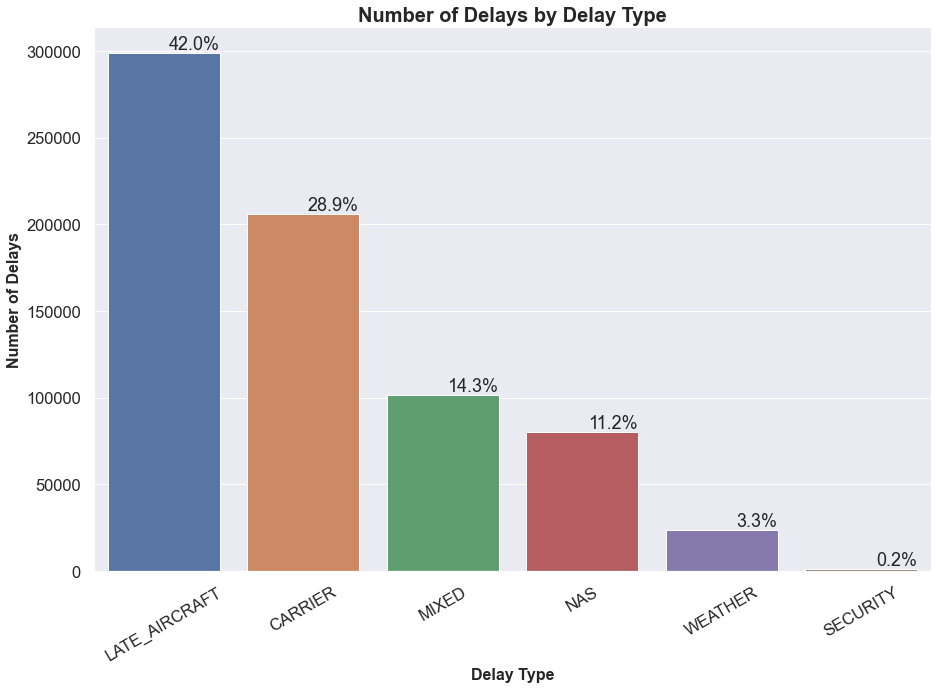

In [30]:
# Visualize target labels distribution
sns.set(font_scale = 1.5) # reset our scale

# create our figure
fig, ax=plt.subplots(figsize=(15,10))


# set up our barplot
bar4 = sns.barplot(x=y.index, y=y, data=final)


total = float(sum(y))

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha="right",va="bottom")


# label our visualization

bar4.set_xticklabels(bar4.get_xticklabels(),rotation=30)
bar4.set_ylabel('Number of Delays',weight='bold',fontsize=16)
bar4.set_xlabel('Delay Type', weight='bold',fontsize=16)
bar4.set_title('Number of Delays by Delay Type',weight='bold',fontsize=20)

# save figure to png
#plt.savefig('images/delay_type.png')
;


In [31]:
# Drop categoricals that we were using for our visualizations 

final.drop(columns=['CARRIER_NAME', 'DEPARTING_AIRPORT', 'PREVIOUS_AIRPORT', 'DAY_OF_WEEK', 'DEP_TIME_BLK', 'MONTH'], axis=1, inplace=True)

## Correlations

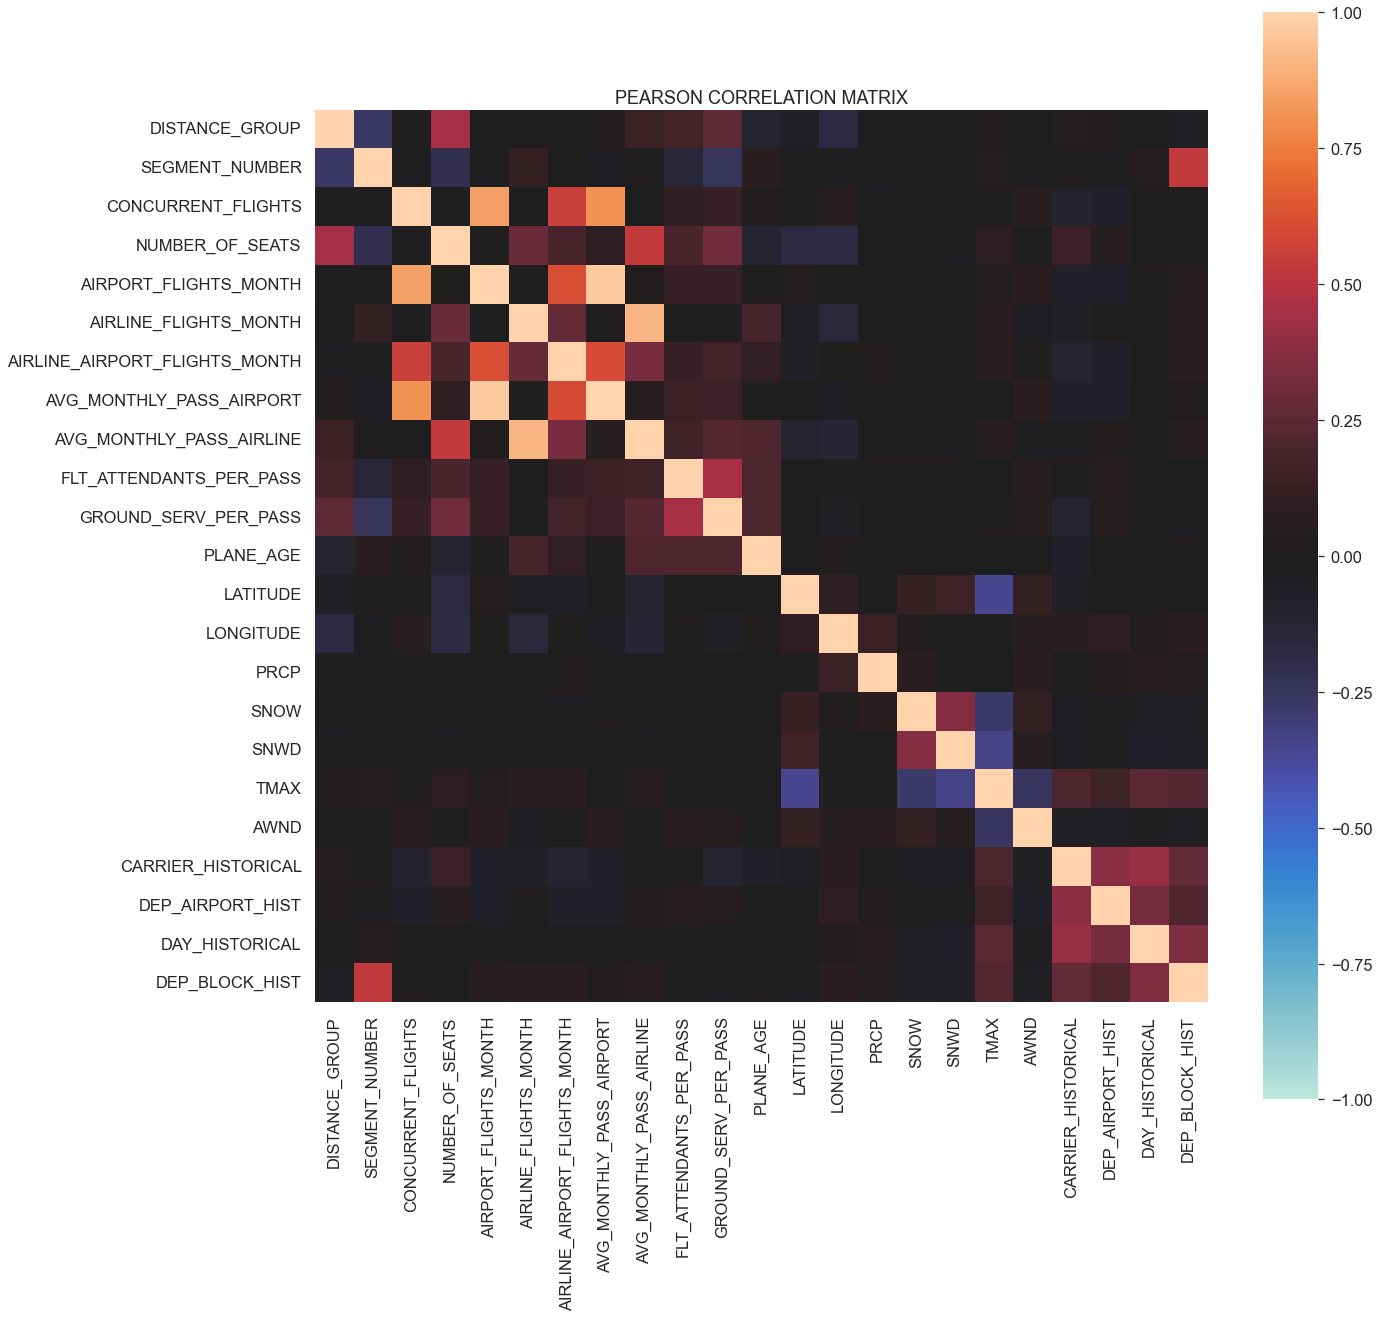

In [32]:
# look for multicollinearity of features
fig, ax = plt.subplots(figsize=(20, 20))

sns.heatmap(final.corr(), center=0,  
           vmin=-1, vmax=1,  square=True)

# title
plt.title('PEARSON CORRELATION MATRIX', fontsize=18)

plt.show()

In [33]:
final.corr()

,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,FLT_ATTENDANTS_PER_PASS,...,LONGITUDE,PRCP,SNOW,SNWD,TMAX,AWND,CARRIER_HISTORICAL,DEP_AIRPORT_HIST,DAY_HISTORICAL,DEP_BLOCK_HIST
DISTANCE_GROUP,1.000000,-0.265207,-0.035722,0.448084,-0.016900,0.003242,-0.018316,0.035589,0.134178,0.178586,...,-0.168641,-0.025409,0.000516,-0.015714,0.029035,0.006552,0.045062,0.030632,0.000447,-0.050338
SEGMENT_NUMBER,-0.265207,1.000000,-0.030765,-0.208664,-0.018262,0.116145,0.004303,-0.042856,0.012444,-0.133721,...,-0.018149,-0.011655,-0.033753,-0.029015,0.042444,-0.028521,0.017692,-0.026022,0.040640,0.526774
CONCURRENT_FLIGHTS,-0.035722,-0.030765,1.000000,-0.032717,0.844344,-0.019355,0.555035,0.804869,0.004454,0.098527,...,0.049739,-0.020823,-0.021986,-0.015640,0.023344,0.062855,-0.097399,-0.078336,0.018665,0.012188
NUMBER_OF_SEATS,0.448084,-0.208664,-0.032717,1.000000,0.021475,0.290308,0.187699,0.083618,0.537078,0.196636,...,-0.173241,-0.009359,-0.010912,-0.029944,0.090388,-0.032187,0.144203,0.055346,0.000766,0.005910
AIRPORT_FLIGHTS_MONTH,-0.016900,-0.018262,0.844344,0.021475,1.000000,0.003633,0.616948,0.964361,0.031310,0.129597,...,0.019005,0.006752,0.001151,-0.011685,0.039455,0.077503,-0.080065,-0.077484,0.011509,0.049750
AIRLINE_FLIGHTS_MONTH,0.003242,0.116145,-0.019355,0.290308,0.003633,1.000000,0.277007,0.014477,0.907111,-0.011361,...,-0.153622,-0.008449,-0.016488,-0.025145,0.075416,-0.044375,-0.061076,0.010628,0.013772,0.070491
AIRLINE_AIRPORT_FLIGHTS_MONTH,-0.018316,0.004303,0.555035,0.187699,0.616948,0.277007,1.000000,0.606116,0.334508,0.130500,...,0.018897,0.030408,-0.020031,-0.031318,0.075146,0.016489,-0.108661,-0.079436,0.009557,0.074448
AVG_MONTHLY_PASS_AIRPORT,0.035589,-0.042856,0.804869,0.083618,0.964361,0.014477,0.606116,1.000000,0.060685,0.139560,...,-0.042862,0.008645,0.011350,0.003086,0.002432,0.076036,-0.078813,-0.079995,0.004938,0.038835
AVG_MONTHLY_PASS_AIRLINE,0.134178,0.012444,0.004454,0.537078,0.031310,0.907111,0.334508,0.060685,1.000000,0.158982,...,-0.131433,0.001303,-0.007309,-0.023066,0.059459,-0.031187,-0.026273,0.027073,0.012899,0.056634
FLT_ATTENDANTS_PER_PASS,0.178586,-0.133721,0.098527,0.196636,0.129597,-0.011361,0.130500,0.139560,0.158982,1.000000,...,0.012623,0.009794,0.021470,0.009820,-0.002912,0.052598,0.013737,0.053113,0.008113,-0.007724


In [34]:
#Get our list of highly correlated feature pairs:

# save correlation matrix as a new data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking

df_correlations = final.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns in a new column named "pairs"
df_correlations['pairs'] = list(zip(df_correlations.level_0, df_correlations.level_1))

# set index to pairs
df_correlations.set_index(['pairs'], inplace = True)

# rename our results column to correlation
df_correlations.rename(columns={0: "correlation"}, inplace=True)

# Drop 1:1 correlations to get rid of self pairs
df_correlations.drop(df_correlations[df_correlations['correlation'] == 1.000000].index, inplace=True)

# view pairs above 75% correlation and below 95% correlation (engineered features will correlate with each other above 95%)
df_correlations[(df_correlations.correlation>.75) & (df_correlations.correlation<.95)]


,level_0,level_1,correlation
pairs,,,
"(AIRLINE_FLIGHTS_MONTH, AVG_MONTHLY_PASS_AIRLINE)",AIRLINE_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRLINE,0.907111
"(AVG_MONTHLY_PASS_AIRLINE, AIRLINE_FLIGHTS_MONTH)",AVG_MONTHLY_PASS_AIRLINE,AIRLINE_FLIGHTS_MONTH,0.907111
"(AIRPORT_FLIGHTS_MONTH, CONCURRENT_FLIGHTS)",AIRPORT_FLIGHTS_MONTH,CONCURRENT_FLIGHTS,0.844344
"(CONCURRENT_FLIGHTS, AIRPORT_FLIGHTS_MONTH)",CONCURRENT_FLIGHTS,AIRPORT_FLIGHTS_MONTH,0.844344
"(AVG_MONTHLY_PASS_AIRPORT, CONCURRENT_FLIGHTS)",AVG_MONTHLY_PASS_AIRPORT,CONCURRENT_FLIGHTS,0.804869
"(CONCURRENT_FLIGHTS, AVG_MONTHLY_PASS_AIRPORT)",CONCURRENT_FLIGHTS,AVG_MONTHLY_PASS_AIRPORT,0.804869


In [35]:
# drop highly correlated features
final.drop(columns=['AVG_MONTHLY_PASS_AIRLINE', 'AIRPORT_FLIGHTS_MONTH', 'AVG_MONTHLY_PASS_AIRPORT'], axis=1, inplace=True)

## UMAP

UMAP is a dimensionality reduction algorithm that is very similar to knn. It results in readable visualizations of multi-dimensional data projected into 2D space. It can also be used for general dimensionality reduction, but here we are using it for the visual element to see if our data can be clustered.

In [36]:
# UMAP data set without delay reason
umap_set = final.drop('DELAY_REASON', axis=1)

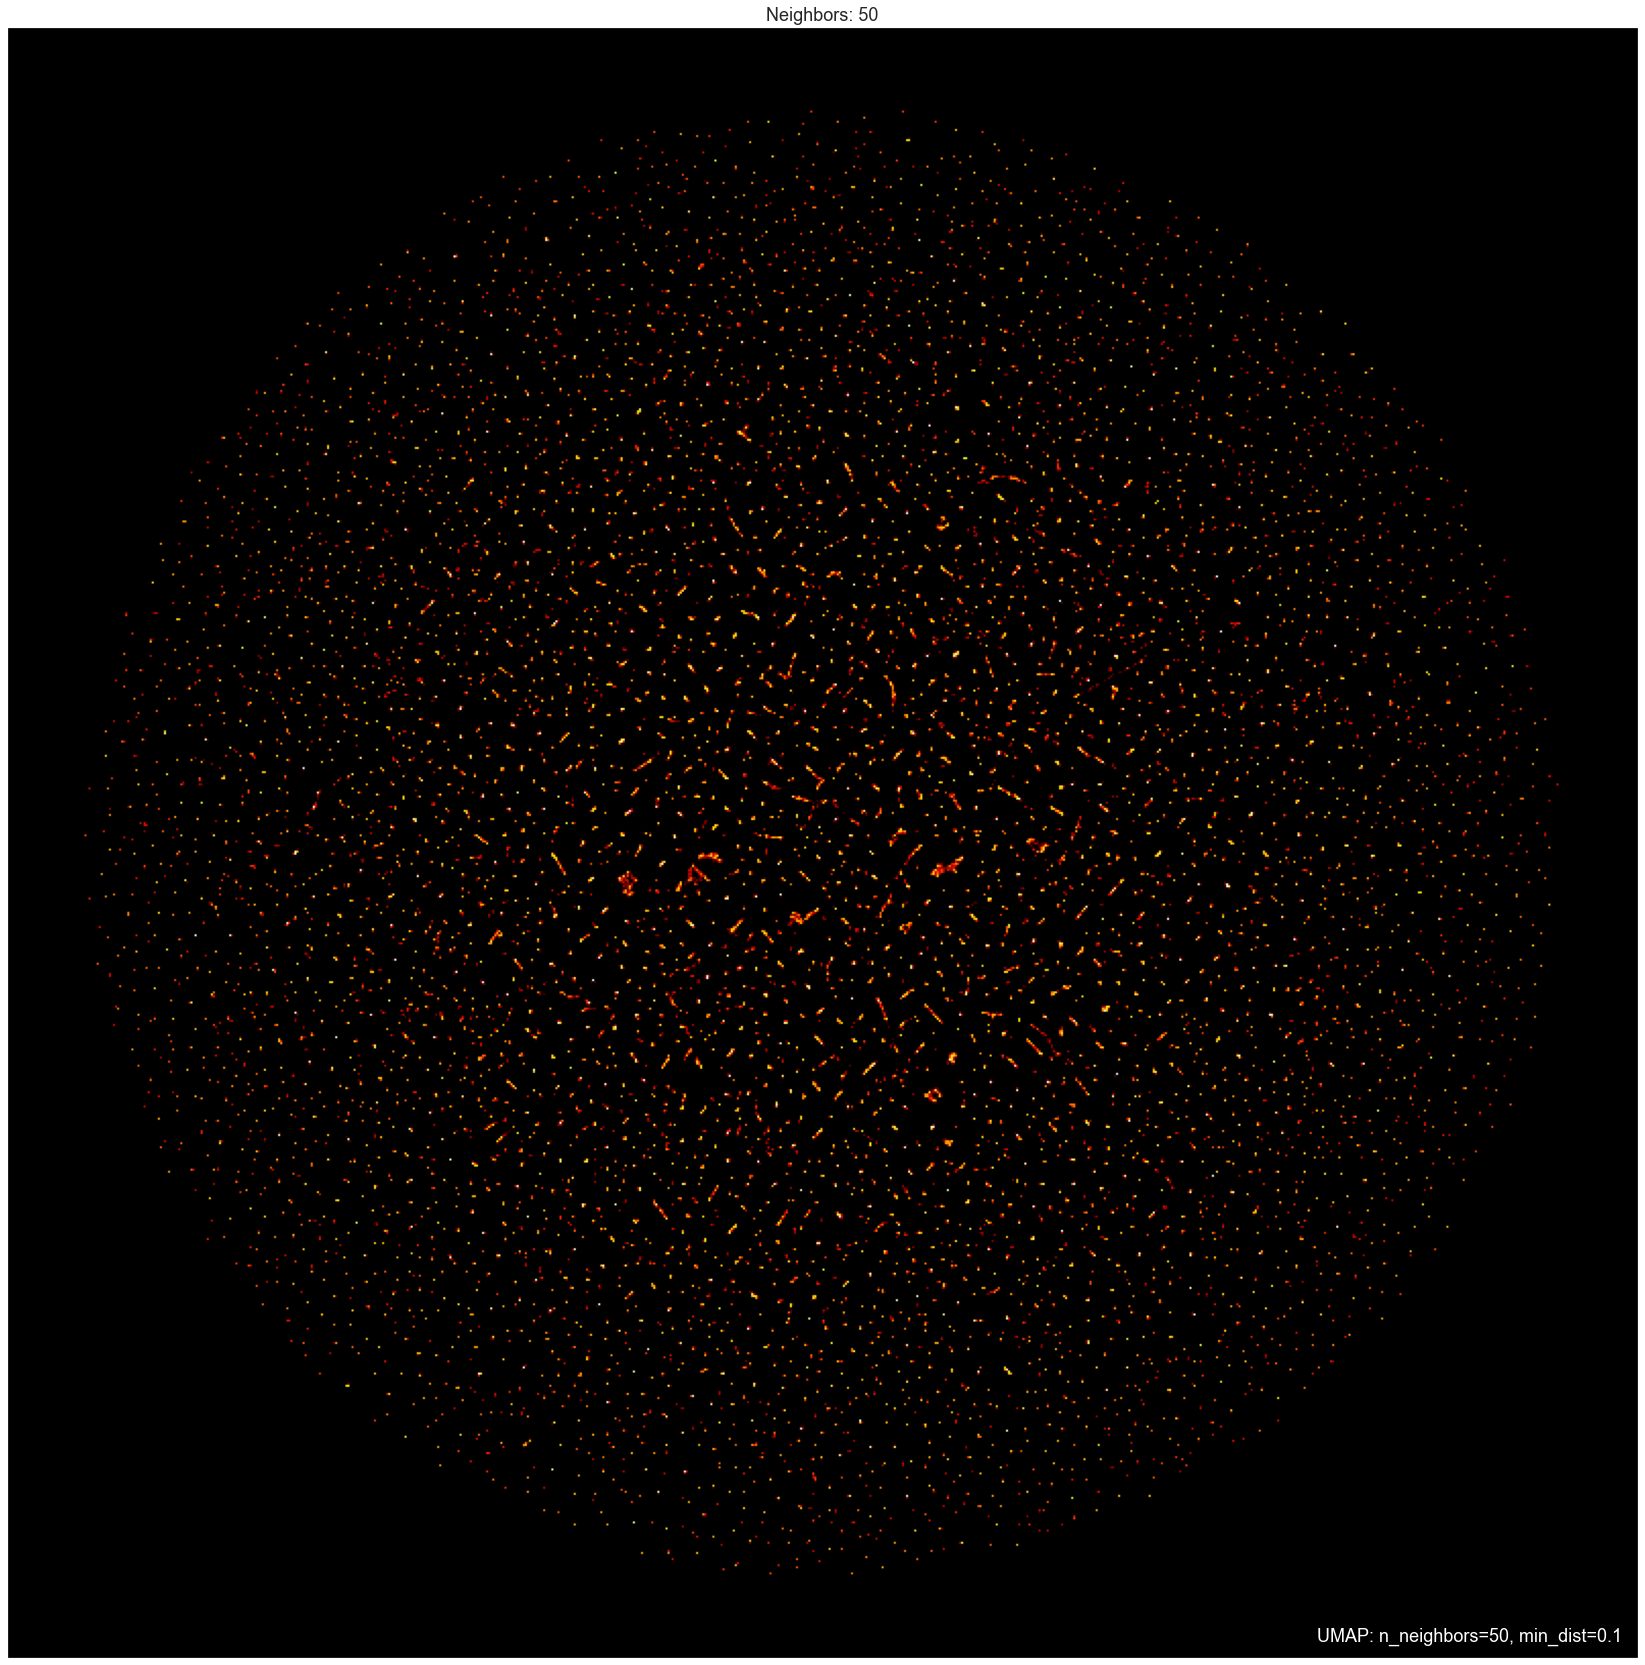

<Figure size 432x288 with 0 Axes>

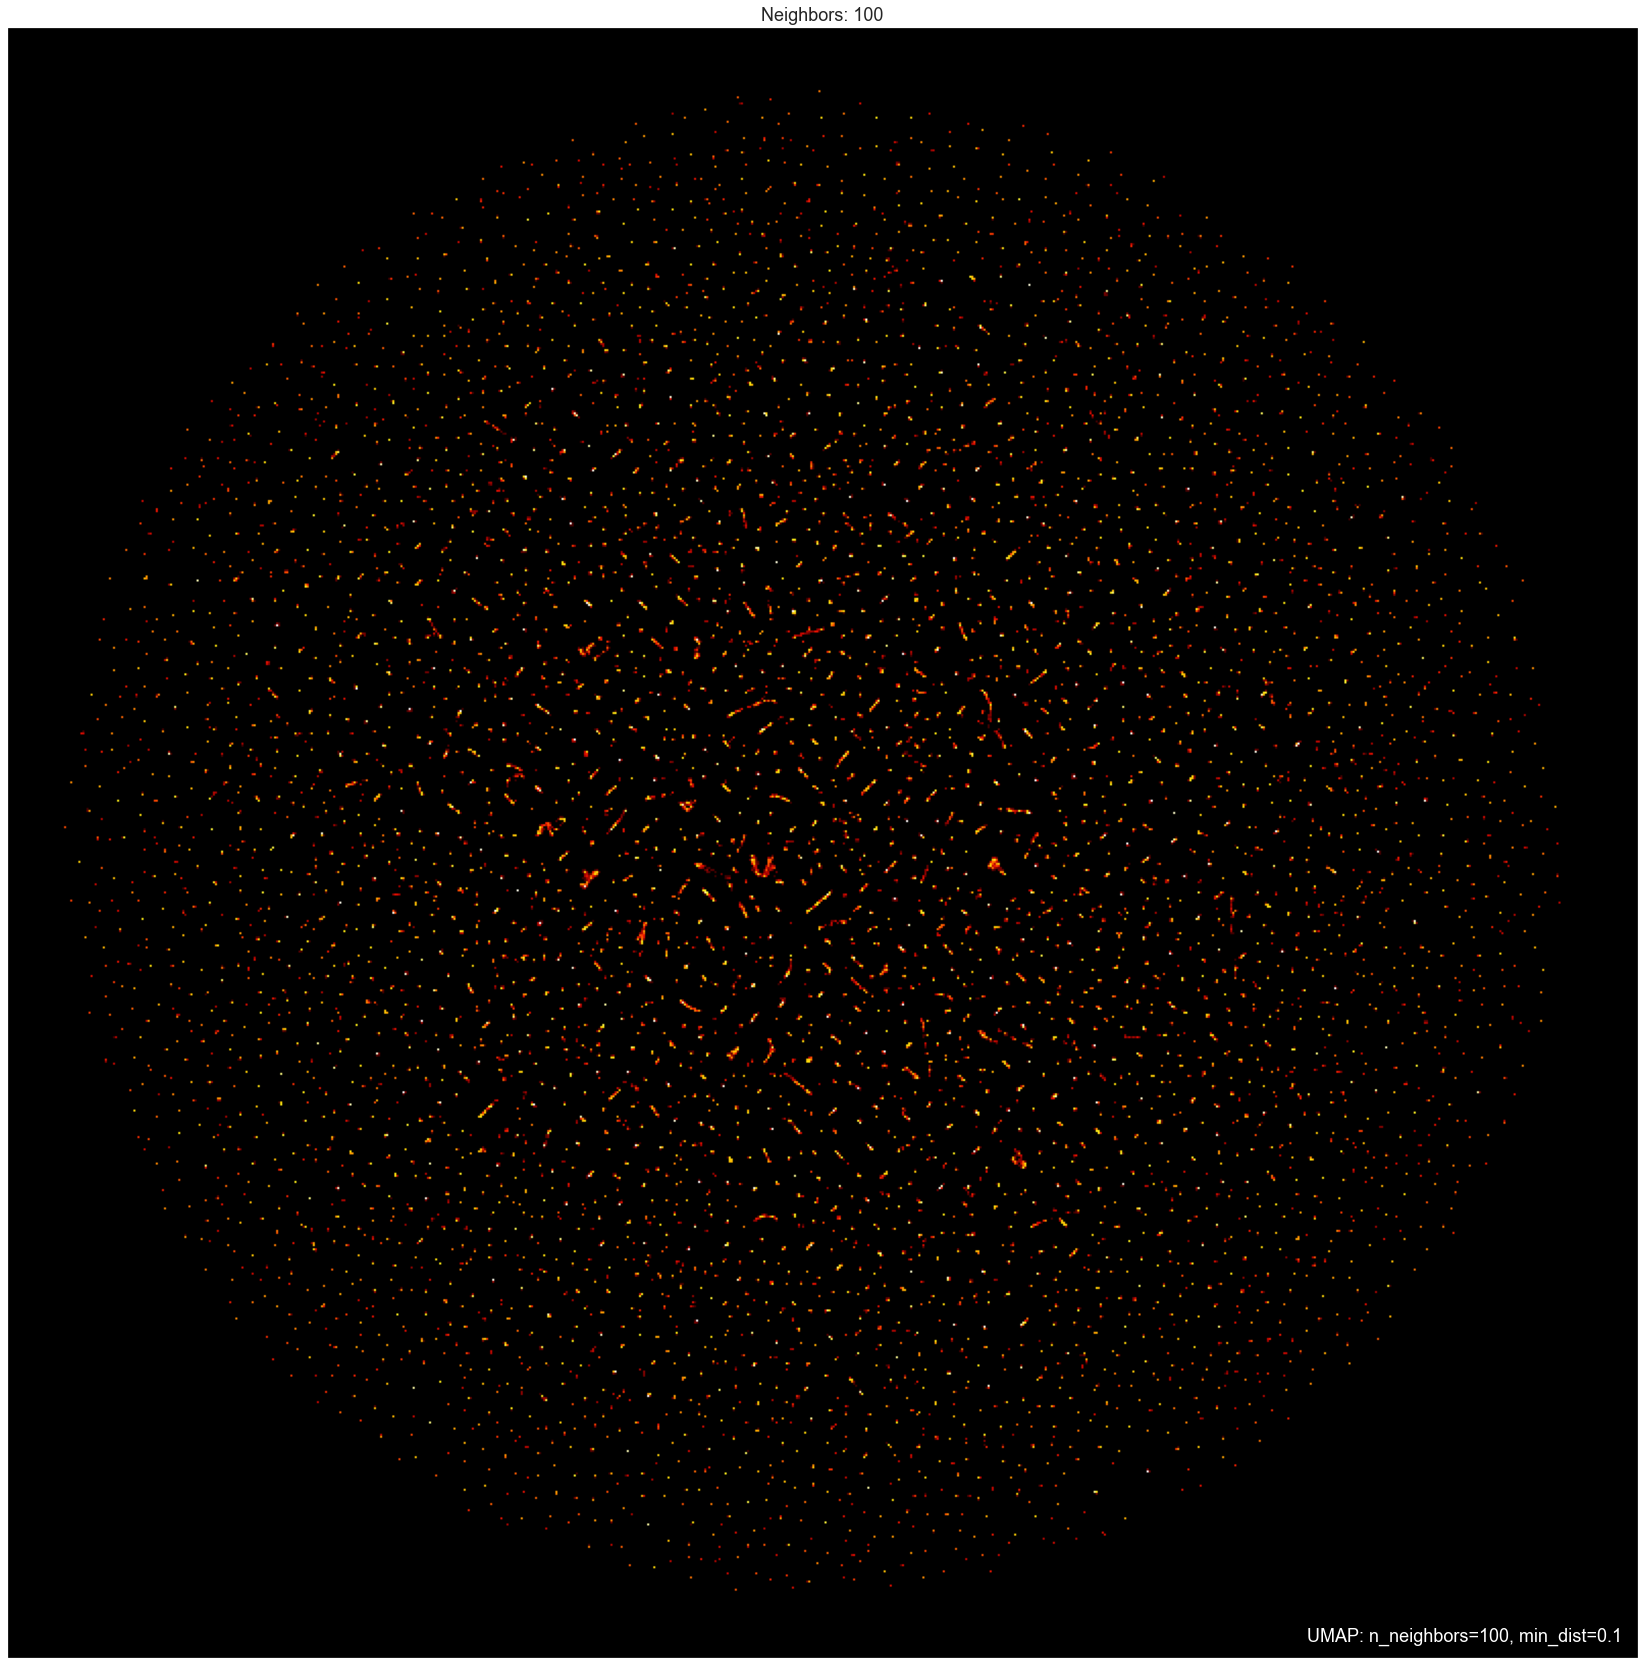

<Figure size 432x288 with 0 Axes>

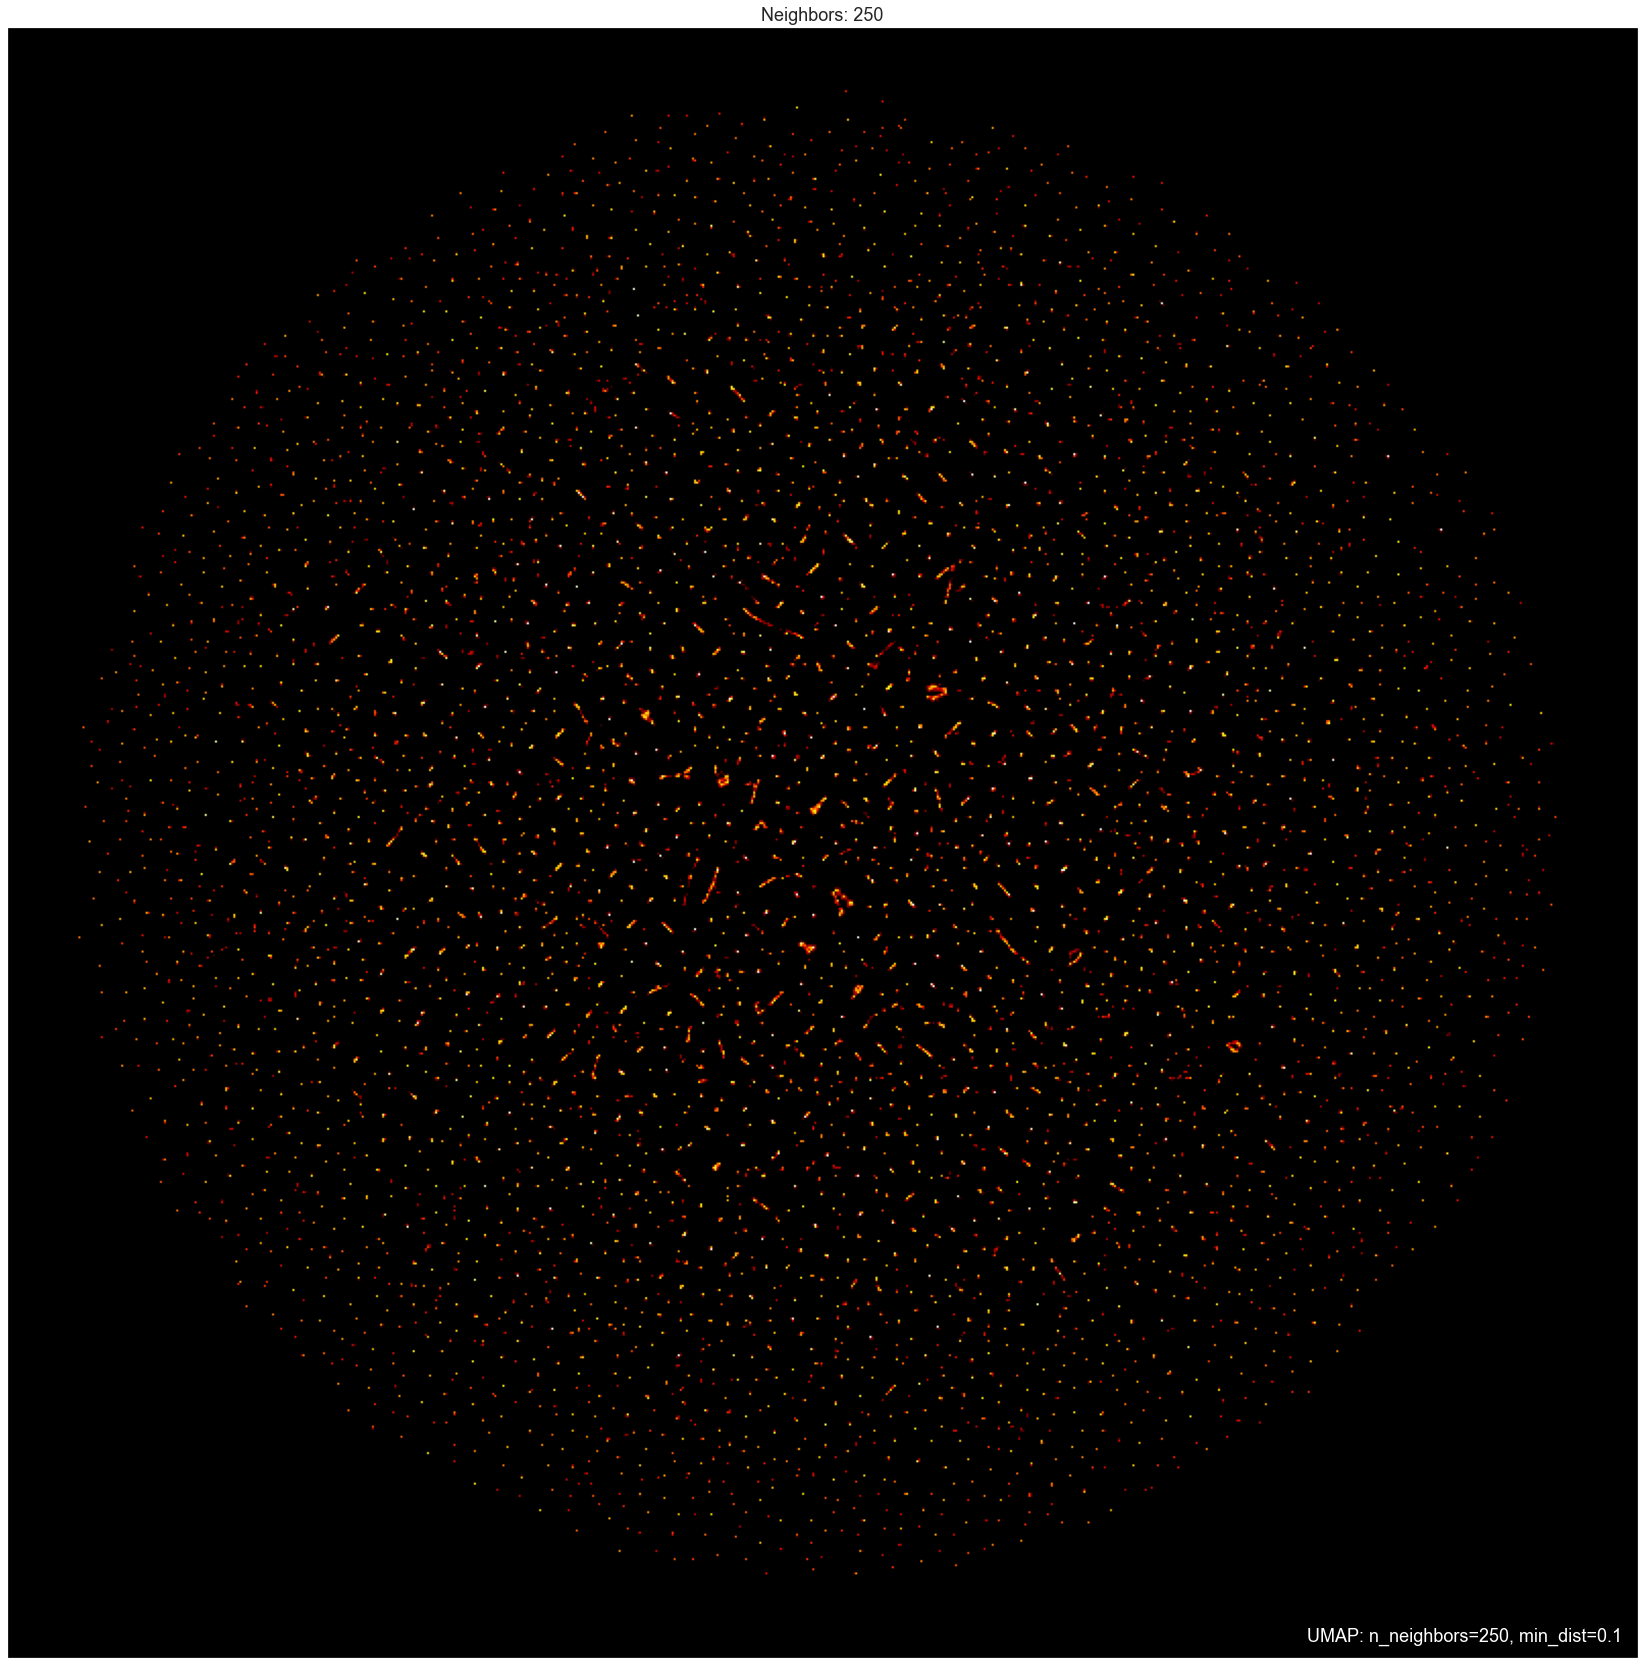

In [ ]:
# fit umap to data
for n in (50, 100, 250):
    mapper = umap.UMAP(n_neighbors=n).fit(umap_set)
    
    # plot umap
    fig, ax = plt.subplots(figsize=(30,30))
    plt.title("Neighbors: {}".format(n))
    umap.plot.points(mapper, theme='fire', ax=ax)
    
    plt.show()
    
    # save figure
    plt.savefig('images/umap_delays_{}.png'.format(n));
    

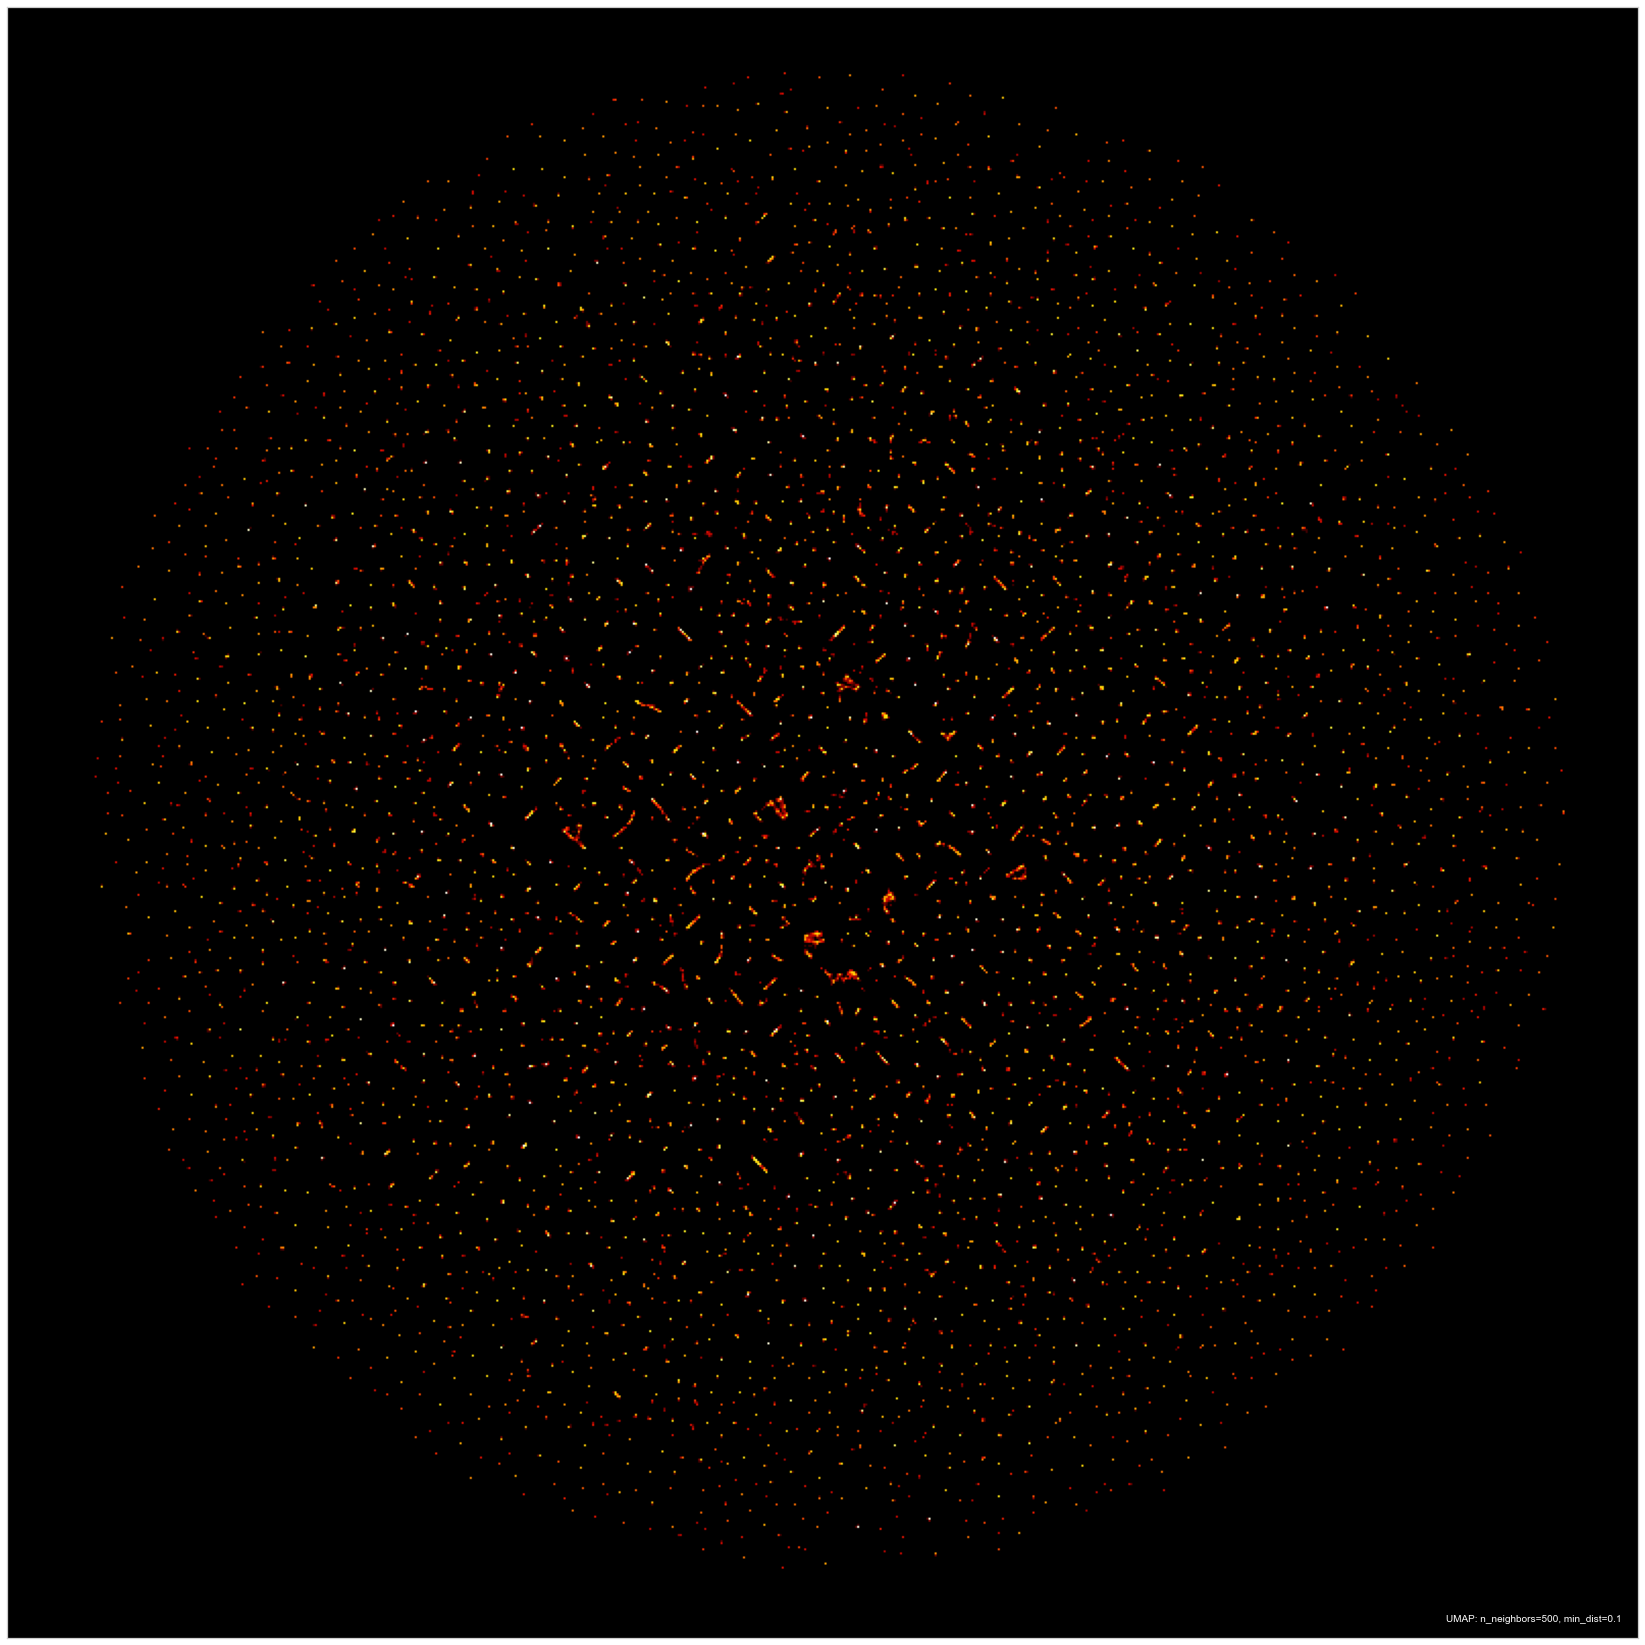

In [37]:
# Fit UMAP with neighbors=500
# I wanted to fit to more neighbors, but my computer can't handle it

mapper = umap.UMAP(n_neighbors=500).fit(umap_set)

# plot umap
fig, ax = plt.subplots(figsize=(30,30))
umap.plot.points(mapper, theme='fire', ax=ax)

# save figure
plt.savefig('images/umap_delays_500.png');

The inability of UMAP to cluster our data into discrete or even semi-discrete groups is the most telling component of the entire project. In our problem, the entire map looks like a paint spatter. The delay problem has not been solved by us - even with all of our features there are not strong groupings of like-features that conclusively determine any type of delay.

# Modeling

In [36]:
# prepare dictionary to store testing results

randomstate=42

spot_check = {}
spot_check['Model'] = []
spot_check['f1'] = []
spot_check['accuracy'] = []
spot_check['precision'] = []
spot_check['recall'] = []
spot_check['time'] = []

models = {}
models['Model'] = []
models['f1'] = []
models['accuracy'] = []
models['precision'] = []
models['recall'] = []
models['time'] = []

In [37]:
print('Raw counts: \n')
print(final['DELAY_REASON'].value_counts())
print('-----------------------------------')
print('Normalized counts: \n')
print(final['DELAY_REASON'].value_counts(normalize=True))

Raw counts: 

LATE_AIRCRAFT    298668
CARRIER          205794
MIXED            101703
NAS               79854
WEATHER           23541
SECURITY           1304
Name: DELAY_REASON, dtype: int64
-----------------------------------
Normalized counts: 

LATE_AIRCRAFT    0.420148
CARRIER          0.289498
MIXED            0.143070
NAS              0.112334
WEATHER          0.033116
SECURITY         0.001834
Name: DELAY_REASON, dtype: float64


In [38]:
# Make x-train and y-train
x_train = final.drop('DELAY_REASON', axis=1)
y_train = final['DELAY_REASON']

In [39]:
# load in validation data (from OS_dataset_cleanup)
val = pd.read_pickle('data/pkl/test_delays.pkl')

x_val = val.drop('DELAY_REASON', axis=1)
y_val = val['DELAY_REASON']

x_val.drop(columns=['AVG_MONTHLY_PASS_AIRLINE', 'AIRPORT_FLIGHTS_MONTH', 'AVG_MONTHLY_PASS_AIRPORT', 'CARRIER_NAME', 'DEPARTING_AIRPORT', 'PREVIOUS_AIRPORT', 'DAY_OF_WEEK', 'DEP_TIME_BLK', 'MONTH'], axis=1, inplace=True)


## Processing Pipelines

In [40]:
# set up processing categories

features_cat = [col for col in x_train.columns if x_train[col].dtype in [object]]

cont_features = [col for col in x_train.columns if x_train[col].dtype in [np.float64, np.int64, np.int32, np.int16, np.int8]]

poly_features = ['SEGMENT_NUMBER', 'DEP_BLOCK_HIST']

features_cat, cont_features, poly_features

([],
 ['DISTANCE_GROUP',
  'SEGMENT_NUMBER',
  'CONCURRENT_FLIGHTS',
  'NUMBER_OF_SEATS',
  'AIRLINE_FLIGHTS_MONTH',
  'AIRLINE_AIRPORT_FLIGHTS_MONTH',
  'FLT_ATTENDANTS_PER_PASS',
  'GROUND_SERV_PER_PASS',
  'PLANE_AGE',
  'LATITUDE',
  'LONGITUDE',
  'PRCP',
  'SNOW',
  'SNWD',
  'TMAX',
  'AWND',
  'CARRIER_HISTORICAL',
  'DEP_AIRPORT_HIST',
  'DAY_HISTORICAL',
  'DEP_BLOCK_HIST'],
 ['SEGMENT_NUMBER', 'DEP_BLOCK_HIST'])

In [41]:
# Process pipelines
processed_train, pipe = pipeline_fit_preprocessor(x_train)
processed_val = pipeline_transform_preprocessor(x_val, pipe)

Setting up transforms - Polynomials, StandardScaler
Setting up processing pipeline
Fitting pipeline on train data
Transforming test data


In [42]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

## Spot Check Models

In [23]:
# Set up baseline models to spot check

weighted_models = {
    'L1 logistic': LogisticRegression(C=1e12, penalty='l1',
                                      solver='saga',
                                      multi_class='multinomial',
                                     fit_intercept=False),
    'L2 logistic (Multinomial)': LogisticRegression(C=1e12, penalty='l2',
                                                    solver='saga',
                                                    multi_class='multinomial',
                                         fit_intercept=False),
    'L2 logistic (OvR)': LogisticRegression(C=1e12, penalty='l2',
                                            solver='saga',
                                            multi_class='ovr',
                                         fit_intercept=False),
    "Decision Tree Classifier_Weighted": DecisionTreeClassifier(class_weight='balanced', random_state=randomstate),
    "Extra Trees_Weighted" : ExtraTreesClassifier(class_weight='balanced', random_state=randomstate, n_jobs=-1),
    "Random Forest_Weighted": RandomForestClassifier(class_weight='balanced', random_state=randomstate, n_jobs=-1),
    "Balanced Random Forest": BalancedRandomForestClassifier(random_state=randomstate, n_jobs=-1),
    "XGBoost_Weighted": XGBClassifier(random_state=randomstate, verbosity=0, n_jobs=-1),
    "CatBoost_Weighted": CatBoostClassifier(auto_class_weights='Balanced', random_state=randomstate, verbose=False, task_type='GPU', devices='0:1'),
}



for model in weighted_models:
    this_model = weighted_models[model]
    label = model
    spot_check = spot_check_classifier(this_model, processed_train, y_train, label, processed_val, y_val, spot_check)



Running L1 logistic Classification
CV 5 Accuracy Train Score: 45.27
CV 5 F1 Train Score: 24.53
CV 5 Auc Train Score: 65.45
CV 5 Precision Train Score: 26.82
CV 5 Recall Train Score: 24.79

Validation Accuracy ( 0.5 Thresh)):  0.3543029730168811
Validation f1 Score ( 0.5 Thresh):  0.16569113519213394
Validation Precision Score ( 0.5 Thresh):  0.2445523512773915
Validation Recall Score ( 0.5 Thresh):  0.21126295697208033 

              precision    recall  f1-score   support

           0       0.48      0.01      0.02     37296
           1       0.36      0.64      0.46     39448
           2       0.15      0.02      0.03     16648
           3       0.35      0.57      0.44     38136
           4       0.00      0.00      0.00       228
           5       0.12      0.02      0.04      3662

    accuracy                           0.35    135418
   macro avg       0.24      0.21      0.17    135418
weighted avg       0.36      0.35      0.27    135418

Elapsed Time: 505.732129335403


Validation Accuracy ( 0.5 Thresh)):  0.3490156404613862
Validation f1 Score ( 0.5 Thresh):  0.23989102305617563
Validation Precision Score ( 0.5 Thresh):  0.24497773835802317
Validation Recall Score ( 0.5 Thresh):  0.2516673675072674 

              precision    recall  f1-score   support

           0       0.43      0.25      0.32     37296
           1       0.41      0.49      0.44     39448
           2       0.18      0.19      0.19     16648
           3       0.36      0.38      0.37     38136
           4       0.00      0.00      0.00       228
           5       0.08      0.19      0.11      3662

    accuracy                           0.35    135418
   macro avg       0.24      0.25      0.24    135418
weighted avg       0.37      0.35      0.35    135418

Elapsed Time: 147.89830040931702


In [24]:
checks = pd.DataFrame(spot_check)
checks.sort_values('f1', ascending=False)

,Model,f1,accuracy,precision,recall,time
8,CatBoost_Weighted,0.239891,0.349016,0.244978,0.251667,147.898300
6,Balanced Random Forest,0.213354,0.281824,0.227106,0.270568,41.394649
3,Decision Tree Classifier_Weighted,0.189634,0.296504,0.196288,0.195884,75.170885
2,L2 logistic (OvR),0.173312,0.348765,0.232981,0.209944,740.371442
7,XGBoost_Weighted,0.169620,0.364457,0.265808,0.215080,459.289697
1,L2 logistic (Multinomial),0.165692,0.354303,0.244552,0.211263,355.081473
0,L1 logistic,0.165691,0.354303,0.244552,0.211263,505.732129
5,Random Forest_Weighted,0.159503,0.363430,0.287643,0.212324,189.444788
4,Extra Trees_Weighted,0.155291,0.361119,0.275703,0.210454,208.689282


## Tuned Model

In [21]:
# Pick best model to get more in-depth score metrics
# TUNING LOCATED IN APPENDIX


cat_boost = CatBoostClassifier(auto_class_weights='Balanced', random_state=randomstate, verbose=False, task_type='GPU', devices='0:1')



Running CatBoost Classification
CV 5 Accuracy Train Score: 42.62
CV 5 F1 Train Score: 33.95
CV 5 Auc Train Score: 72.4
CV 5 Precision Train Score: 32.91
CV 5 Recall Train Score: 45.54

Validation Accuracy ( 0.5 Thresh)):  0.3490156404613862
Validation f1 Score ( 0.5 Thresh):  0.23989102305617563
Validation Precision Score ( 0.5 Thresh):  0.24497773835802317
Validation Recall Score ( 0.5 Thresh):  0.2516673675072674 

              precision    recall  f1-score   support

           0       0.43      0.25      0.32     37296
           1       0.41      0.49      0.44     39448
           2       0.18      0.19      0.19     16648
           3       0.36      0.38      0.37     38136
           4       0.00      0.00      0.00       228
           5       0.08      0.19      0.11      3662

    accuracy                           0.35    135418
   macro avg       0.24      0.25      0.24    135418
weighted avg       0.37      0.35      0.35    135418

Elapsed Time: 149.66516041755676



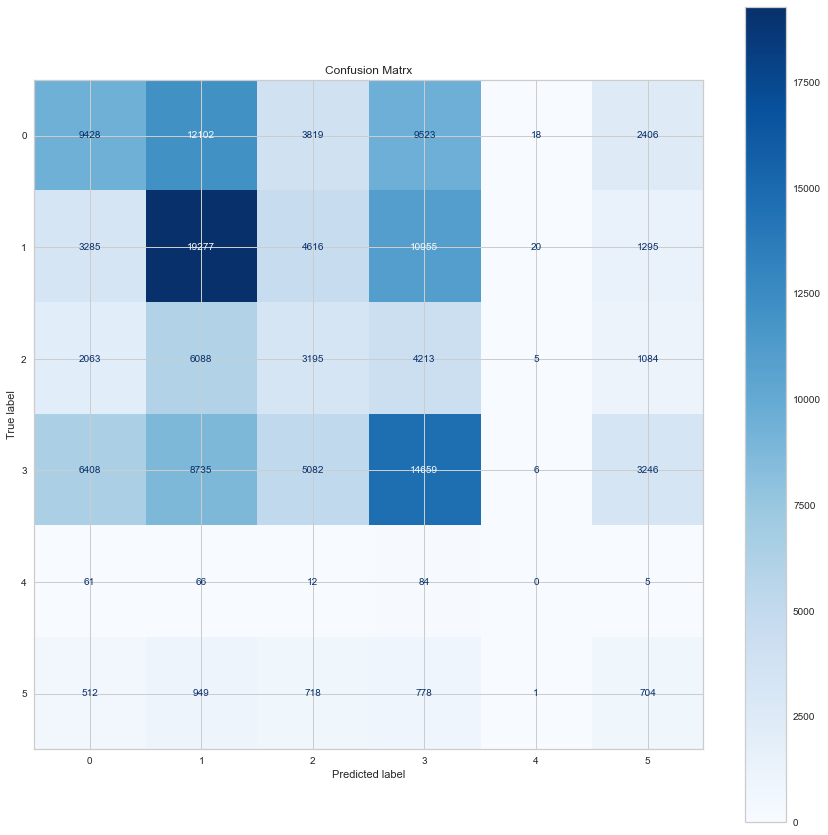

In [22]:
# Run scoring metrics
scores = spot_check_classifier(cat_boost, processed_train, y_train, "CatBoost", processed_val, y_val, models)
visuals(cat_boost, processed_val, y_val)



Running CatBoost Classification
0:	learn: 1.7327403	total: 3.46s	remaining: 57m 34s
1:	learn: 1.6883199	total: 6.87s	remaining: 57m 6s
2:	learn: 1.6489608	total: 10.3s	remaining: 56m 52s
3:	learn: 1.6185373	total: 13.6s	remaining: 56m 32s
4:	learn: 1.5884938	total: 17s	remaining: 56m 28s
5:	learn: 1.5614137	total: 20.4s	remaining: 56m 22s
6:	learn: 1.5388867	total: 23.8s	remaining: 56m 13s
7:	learn: 1.5186352	total: 27.1s	remaining: 56m 4s
8:	learn: 1.5028609	total: 30.5s	remaining: 55m 57s
9:	learn: 1.4812584	total: 33.9s	remaining: 55m 55s
10:	learn: 1.4639993	total: 37.2s	remaining: 55m 47s
11:	learn: 1.4509633	total: 40.7s	remaining: 55m 49s
12:	learn: 1.4382832	total: 44s	remaining: 55m 42s
13:	learn: 1.4239965	total: 47.4s	remaining: 55m 36s
14:	learn: 1.4152850	total: 50.7s	remaining: 55m 28s
15:	learn: 1.4054465	total: 54s	remaining: 55m 20s
16:	learn: 1.3942372	total: 57.3s	remaining: 55m 15s
17:	learn: 1.3836391	total: 1m	remaining: 55m 12s
18:	learn: 1.3757604	total: 1m 4s

152:	learn: 0.9980032	total: 8m 29s	remaining: 47m 1s
153:	learn: 0.9965588	total: 8m 32s	remaining: 46m 58s
154:	learn: 0.9954024	total: 8m 36s	remaining: 46m 55s
155:	learn: 0.9940209	total: 8m 39s	remaining: 46m 52s
156:	learn: 0.9928995	total: 8m 43s	remaining: 46m 49s
157:	learn: 0.9915911	total: 8m 46s	remaining: 46m 46s
158:	learn: 0.9905908	total: 8m 50s	remaining: 46m 44s
159:	learn: 0.9896013	total: 8m 53s	remaining: 46m 40s
160:	learn: 0.9882436	total: 8m 56s	remaining: 46m 37s
161:	learn: 0.9873356	total: 9m	remaining: 46m 33s
162:	learn: 0.9863675	total: 9m 3s	remaining: 46m 30s
163:	learn: 0.9855897	total: 9m 6s	remaining: 46m 26s
164:	learn: 0.9845659	total: 9m 9s	remaining: 46m 23s
165:	learn: 0.9833134	total: 9m 13s	remaining: 46m 20s
166:	learn: 0.9821993	total: 9m 16s	remaining: 46m 16s
167:	learn: 0.9812032	total: 9m 19s	remaining: 46m 13s
168:	learn: 0.9801107	total: 9m 23s	remaining: 46m 9s
169:	learn: 0.9791986	total: 9m 26s	remaining: 46m 6s
170:	learn: 0.978283

300:	learn: 0.8692929	total: 16m 53s	remaining: 39m 14s
301:	learn: 0.8684470	total: 16m 57s	remaining: 39m 11s
302:	learn: 0.8676889	total: 17m	remaining: 39m 8s
303:	learn: 0.8670062	total: 17m 4s	remaining: 39m 5s
304:	learn: 0.8662022	total: 17m 7s	remaining: 39m 2s
305:	learn: 0.8655512	total: 17m 11s	remaining: 38m 59s
306:	learn: 0.8649248	total: 17m 14s	remaining: 38m 56s
307:	learn: 0.8644513	total: 17m 18s	remaining: 38m 52s
308:	learn: 0.8638075	total: 17m 21s	remaining: 38m 49s
309:	learn: 0.8631764	total: 17m 25s	remaining: 38m 46s
310:	learn: 0.8624720	total: 17m 28s	remaining: 38m 43s
311:	learn: 0.8619234	total: 17m 32s	remaining: 38m 40s
312:	learn: 0.8612031	total: 17m 35s	remaining: 38m 37s
313:	learn: 0.8606143	total: 17m 39s	remaining: 38m 34s
314:	learn: 0.8600057	total: 17m 42s	remaining: 38m 31s
315:	learn: 0.8590112	total: 17m 46s	remaining: 38m 28s
316:	learn: 0.8584695	total: 17m 50s	remaining: 38m 25s
317:	learn: 0.8577026	total: 17m 53s	remaining: 38m 22s
3

448:	learn: 0.7823555	total: 25m 52s	remaining: 31m 45s
449:	learn: 0.7819928	total: 25m 56s	remaining: 31m 42s
450:	learn: 0.7813585	total: 26m	remaining: 31m 39s
451:	learn: 0.7809079	total: 26m 3s	remaining: 31m 35s
452:	learn: 0.7803596	total: 26m 7s	remaining: 31m 32s
453:	learn: 0.7799349	total: 26m 11s	remaining: 31m 29s
454:	learn: 0.7795463	total: 26m 15s	remaining: 31m 26s
455:	learn: 0.7791044	total: 26m 19s	remaining: 31m 23s
456:	learn: 0.7786555	total: 26m 22s	remaining: 31m 20s
457:	learn: 0.7780667	total: 26m 26s	remaining: 31m 17s
458:	learn: 0.7775921	total: 26m 30s	remaining: 31m 14s
459:	learn: 0.7770664	total: 26m 34s	remaining: 31m 11s
460:	learn: 0.7766018	total: 26m 38s	remaining: 31m 8s
461:	learn: 0.7761666	total: 26m 42s	remaining: 31m 5s
462:	learn: 0.7757313	total: 26m 45s	remaining: 31m 2s
463:	learn: 0.7753477	total: 26m 49s	remaining: 30m 59s
464:	learn: 0.7744916	total: 26m 53s	remaining: 30m 56s
465:	learn: 0.7740444	total: 26m 57s	remaining: 30m 53s
4

596:	learn: 0.7164420	total: 35m 31s	remaining: 23m 58s
597:	learn: 0.7160600	total: 35m 35s	remaining: 23m 55s
598:	learn: 0.7155387	total: 35m 39s	remaining: 23m 52s
599:	learn: 0.7150897	total: 35m 43s	remaining: 23m 48s
600:	learn: 0.7146953	total: 35m 47s	remaining: 23m 45s
601:	learn: 0.7141077	total: 35m 51s	remaining: 23m 42s
602:	learn: 0.7136831	total: 35m 55s	remaining: 23m 39s
603:	learn: 0.7132759	total: 35m 59s	remaining: 23m 35s
604:	learn: 0.7129306	total: 36m 3s	remaining: 23m 32s
605:	learn: 0.7126345	total: 36m 7s	remaining: 23m 29s
606:	learn: 0.7123167	total: 36m 11s	remaining: 23m 25s
607:	learn: 0.7118956	total: 36m 15s	remaining: 23m 22s
608:	learn: 0.7115502	total: 36m 19s	remaining: 23m 19s
609:	learn: 0.7110808	total: 36m 23s	remaining: 23m 15s
610:	learn: 0.7106687	total: 36m 27s	remaining: 23m 12s
611:	learn: 0.7101577	total: 36m 31s	remaining: 23m 9s
612:	learn: 0.7097765	total: 36m 35s	remaining: 23m 5s
613:	learn: 0.7093690	total: 36m 39s	remaining: 23m 

744:	learn: 0.6600101	total: 45m 42s	remaining: 15m 38s
745:	learn: 0.6595221	total: 45m 46s	remaining: 15m 35s
746:	learn: 0.6592712	total: 45m 50s	remaining: 15m 31s
747:	learn: 0.6589403	total: 45m 55s	remaining: 15m 28s
748:	learn: 0.6584878	total: 45m 59s	remaining: 15m 24s
749:	learn: 0.6580830	total: 46m 3s	remaining: 15m 21s
750:	learn: 0.6577028	total: 46m 8s	remaining: 15m 17s
751:	learn: 0.6574413	total: 46m 12s	remaining: 15m 14s
752:	learn: 0.6571387	total: 46m 16s	remaining: 15m 10s
753:	learn: 0.6568999	total: 46m 21s	remaining: 15m 7s
754:	learn: 0.6565506	total: 46m 25s	remaining: 15m 3s
755:	learn: 0.6561422	total: 46m 30s	remaining: 15m
756:	learn: 0.6558853	total: 46m 34s	remaining: 14m 57s
757:	learn: 0.6555827	total: 46m 39s	remaining: 14m 53s
758:	learn: 0.6553286	total: 46m 44s	remaining: 14m 50s
759:	learn: 0.6548956	total: 46m 48s	remaining: 14m 47s
760:	learn: 0.6544881	total: 46m 53s	remaining: 14m 43s
761:	learn: 0.6541346	total: 46m 58s	remaining: 14m 40s


893:	learn: 0.6125184	total: 57m 2s	remaining: 6m 45s
894:	learn: 0.6122414	total: 57m 7s	remaining: 6m 42s
895:	learn: 0.6119542	total: 57m 12s	remaining: 6m 38s
896:	learn: 0.6117484	total: 57m 17s	remaining: 6m 34s
897:	learn: 0.6115034	total: 57m 22s	remaining: 6m 31s
898:	learn: 0.6113047	total: 57m 27s	remaining: 6m 27s
899:	learn: 0.6110444	total: 57m 32s	remaining: 6m 23s
900:	learn: 0.6108076	total: 57m 37s	remaining: 6m 19s
901:	learn: 0.6105473	total: 57m 43s	remaining: 6m 16s
902:	learn: 0.6102643	total: 57m 48s	remaining: 6m 12s
903:	learn: 0.6099401	total: 57m 53s	remaining: 6m 8s
904:	learn: 0.6094946	total: 57m 58s	remaining: 6m 5s
905:	learn: 0.6090976	total: 58m 3s	remaining: 6m 1s
906:	learn: 0.6088472	total: 58m 8s	remaining: 5m 57s
907:	learn: 0.6085469	total: 58m 13s	remaining: 5m 53s
908:	learn: 0.6082132	total: 58m 18s	remaining: 5m 50s
909:	learn: 0.6079335	total: 58m 23s	remaining: 5m 46s
910:	learn: 0.6077503	total: 58m 28s	remaining: 5m 42s
911:	learn: 0.607

41:	learn: 1.2122197	total: 2m 46s	remaining: 1h 3m 19s
42:	learn: 1.2072297	total: 2m 50s	remaining: 1h 3m 17s
43:	learn: 1.2034684	total: 2m 54s	remaining: 1h 3m 14s
44:	learn: 1.1991284	total: 2m 58s	remaining: 1h 3m 12s
45:	learn: 1.1951267	total: 3m 2s	remaining: 1h 3m 11s
46:	learn: 1.1898126	total: 3m 6s	remaining: 1h 3m 9s
47:	learn: 1.1868631	total: 3m 10s	remaining: 1h 3m 5s
48:	learn: 1.1835393	total: 3m 14s	remaining: 1h 3m 3s
49:	learn: 1.1791228	total: 3m 18s	remaining: 1h 3m
50:	learn: 1.1756266	total: 3m 22s	remaining: 1h 2m 57s
51:	learn: 1.1726465	total: 3m 27s	remaining: 1h 2m 54s
52:	learn: 1.1698666	total: 3m 31s	remaining: 1h 2m 50s
53:	learn: 1.1669615	total: 3m 35s	remaining: 1h 2m 46s
54:	learn: 1.1628949	total: 3m 39s	remaining: 1h 2m 44s
55:	learn: 1.1603581	total: 3m 43s	remaining: 1h 2m 42s
56:	learn: 1.1582922	total: 3m 47s	remaining: 1h 2m 38s
57:	learn: 1.1546141	total: 3m 51s	remaining: 1h 2m 37s
58:	learn: 1.1523364	total: 3m 55s	remaining: 1h 2m 34s
5

188:	learn: 0.9362842	total: 14m 16s	remaining: 1h 1m 14s
189:	learn: 0.9352961	total: 14m 21s	remaining: 1h 1m 14s
190:	learn: 0.9346578	total: 14m 27s	remaining: 1h 1m 13s
191:	learn: 0.9333611	total: 14m 32s	remaining: 1h 1m 12s
192:	learn: 0.9325965	total: 14m 38s	remaining: 1h 1m 12s
193:	learn: 0.9313439	total: 14m 43s	remaining: 1h 1m 12s
194:	learn: 0.9306014	total: 14m 49s	remaining: 1h 1m 11s
195:	learn: 0.9296206	total: 14m 54s	remaining: 1h 1m 10s
196:	learn: 0.9288805	total: 15m	remaining: 1h 1m 10s
197:	learn: 0.9280180	total: 15m 6s	remaining: 1h 1m 9s
198:	learn: 0.9268598	total: 15m 11s	remaining: 1h 1m 9s
199:	learn: 0.9260917	total: 15m 17s	remaining: 1h 1m 8s
200:	learn: 0.9248607	total: 15m 22s	remaining: 1h 1m 7s
201:	learn: 0.9241630	total: 15m 28s	remaining: 1h 1m 6s
202:	learn: 0.9233559	total: 15m 33s	remaining: 1h 1m 5s
203:	learn: 0.9224932	total: 15m 39s	remaining: 1h 1m 5s
204:	learn: 0.9215449	total: 15m 44s	remaining: 1h 1m 4s
205:	learn: 0.9208016	total

336:	learn: 0.8176294	total: 27m 43s	remaining: 54m 33s
337:	learn: 0.8171451	total: 27m 49s	remaining: 54m 29s
338:	learn: 0.8166780	total: 27m 54s	remaining: 54m 25s
339:	learn: 0.8162724	total: 28m	remaining: 54m 21s
340:	learn: 0.8154532	total: 28m 5s	remaining: 54m 17s
341:	learn: 0.8148828	total: 28m 11s	remaining: 54m 13s
342:	learn: 0.8142262	total: 28m 16s	remaining: 54m 9s
343:	learn: 0.8137258	total: 28m 21s	remaining: 54m 5s
344:	learn: 0.8130009	total: 28m 27s	remaining: 54m 1s
345:	learn: 0.8126284	total: 28m 32s	remaining: 53m 57s
346:	learn: 0.8118937	total: 28m 38s	remaining: 53m 53s
347:	learn: 0.8112457	total: 28m 43s	remaining: 53m 49s
348:	learn: 0.8106997	total: 28m 49s	remaining: 53m 45s
349:	learn: 0.8101187	total: 28m 54s	remaining: 53m 41s
350:	learn: 0.8093292	total: 29m	remaining: 53m 37s
351:	learn: 0.8086574	total: 29m 5s	remaining: 53m 33s
352:	learn: 0.8079907	total: 29m 11s	remaining: 53m 29s
353:	learn: 0.8074918	total: 29m 16s	remaining: 53m 25s
354:	

484:	learn: 0.7341477	total: 42m 54s	remaining: 45m 33s
485:	learn: 0.7337051	total: 43m 1s	remaining: 45m 29s
486:	learn: 0.7331880	total: 43m 8s	remaining: 45m 26s
487:	learn: 0.7325900	total: 43m 14s	remaining: 45m 22s
488:	learn: 0.7320761	total: 43m 21s	remaining: 45m 19s
489:	learn: 0.7316067	total: 43m 28s	remaining: 45m 15s
490:	learn: 0.7308752	total: 43m 35s	remaining: 45m 11s
491:	learn: 0.7301014	total: 43m 42s	remaining: 45m 8s
492:	learn: 0.7294426	total: 43m 49s	remaining: 45m 4s
493:	learn: 0.7287817	total: 43m 56s	remaining: 45m
494:	learn: 0.7283087	total: 44m 3s	remaining: 44m 56s
495:	learn: 0.7279053	total: 44m 10s	remaining: 44m 52s
496:	learn: 0.7274463	total: 44m 17s	remaining: 44m 49s
497:	learn: 0.7270062	total: 44m 23s	remaining: 44m 44s
498:	learn: 0.7265299	total: 44m 30s	remaining: 44m 41s
499:	learn: 0.7260325	total: 44m 37s	remaining: 44m 37s
500:	learn: 0.7255362	total: 44m 44s	remaining: 44m 33s
501:	learn: 0.7251853	total: 44m 51s	remaining: 44m 29s
5

632:	learn: 0.6689193	total: 1h 21s	remaining: 34m 59s
633:	learn: 0.6684082	total: 1h 28s	remaining: 34m 54s
634:	learn: 0.6680375	total: 1h 36s	remaining: 34m 50s
635:	learn: 0.6674765	total: 1h 43s	remaining: 34m 45s
636:	learn: 0.6671485	total: 1h 51s	remaining: 34m 40s
637:	learn: 0.6667434	total: 1h 58s	remaining: 34m 35s
638:	learn: 0.6664395	total: 1h 1m 5s	remaining: 34m 30s
639:	learn: 0.6660969	total: 1h 1m 12s	remaining: 34m 25s
640:	learn: 0.6654800	total: 1h 1m 19s	remaining: 34m 20s
641:	learn: 0.6649477	total: 1h 1m 26s	remaining: 34m 15s
642:	learn: 0.6645231	total: 1h 1m 33s	remaining: 34m 10s
643:	learn: 0.6640534	total: 1h 1m 41s	remaining: 34m 5s
644:	learn: 0.6636920	total: 1h 1m 48s	remaining: 34m 1s
645:	learn: 0.6632685	total: 1h 1m 55s	remaining: 33m 56s
646:	learn: 0.6630763	total: 1h 2m 2s	remaining: 33m 51s
647:	learn: 0.6627168	total: 1h 2m 9s	remaining: 33m 46s
648:	learn: 0.6623972	total: 1h 2m 17s	remaining: 33m 41s
649:	learn: 0.6619706	total: 1h 2m 24

774:	learn: 0.6156612	total: 1h 19m 28s	remaining: 23m 4s
775:	learn: 0.6154488	total: 1h 19m 36s	remaining: 22m 58s
776:	learn: 0.6151909	total: 1h 19m 44s	remaining: 22m 53s
777:	learn: 0.6147807	total: 1h 19m 52s	remaining: 22m 47s
778:	learn: 0.6143407	total: 1h 20m	remaining: 22m 41s
779:	learn: 0.6140385	total: 1h 20m 9s	remaining: 22m 36s
780:	learn: 0.6137475	total: 1h 20m 17s	remaining: 22m 30s
781:	learn: 0.6133091	total: 1h 20m 25s	remaining: 22m 25s
782:	learn: 0.6128195	total: 1h 20m 33s	remaining: 22m 19s
783:	learn: 0.6124256	total: 1h 20m 41s	remaining: 22m 13s
784:	learn: 0.6120052	total: 1h 20m 50s	remaining: 22m 8s
785:	learn: 0.6117554	total: 1h 20m 59s	remaining: 22m 3s
786:	learn: 0.6115830	total: 1h 21m 8s	remaining: 21m 57s
787:	learn: 0.6112478	total: 1h 21m 17s	remaining: 21m 52s
788:	learn: 0.6108430	total: 1h 21m 26s	remaining: 21m 46s
789:	learn: 0.6105008	total: 1h 21m 35s	remaining: 21m 41s
790:	learn: 0.6102119	total: 1h 21m 44s	remaining: 21m 35s
791:	l

915:	learn: 0.5721594	total: 1h 40m 59s	remaining: 9m 15s
916:	learn: 0.5718011	total: 1h 41m 8s	remaining: 9m 9s
917:	learn: 0.5715473	total: 1h 41m 18s	remaining: 9m 2s
918:	learn: 0.5712483	total: 1h 41m 28s	remaining: 8m 56s
919:	learn: 0.5709911	total: 1h 41m 38s	remaining: 8m 50s
920:	learn: 0.5706248	total: 1h 41m 48s	remaining: 8m 43s
921:	learn: 0.5702838	total: 1h 41m 58s	remaining: 8m 37s
922:	learn: 0.5699509	total: 1h 42m 8s	remaining: 8m 31s
923:	learn: 0.5696930	total: 1h 42m 18s	remaining: 8m 24s
924:	learn: 0.5694122	total: 1h 42m 28s	remaining: 8m 18s
925:	learn: 0.5691523	total: 1h 42m 38s	remaining: 8m 12s
926:	learn: 0.5688130	total: 1h 42m 48s	remaining: 8m 5s
927:	learn: 0.5685837	total: 1h 42m 58s	remaining: 7m 59s
928:	learn: 0.5682610	total: 1h 43m 8s	remaining: 7m 52s
929:	learn: 0.5678952	total: 1h 43m 17s	remaining: 7m 46s
930:	learn: 0.5677268	total: 1h 43m 27s	remaining: 7m 40s
931:	learn: 0.5674650	total: 1h 43m 37s	remaining: 7m 33s
932:	learn: 0.567172

60:	learn: 1.1518655	total: 4m 22s	remaining: 1h 7m 28s
61:	learn: 1.1499469	total: 4m 27s	remaining: 1h 7m 26s
62:	learn: 1.1464868	total: 4m 31s	remaining: 1h 7m 25s
63:	learn: 1.1434163	total: 4m 36s	remaining: 1h 7m 23s
64:	learn: 1.1410359	total: 4m 40s	remaining: 1h 7m 22s
65:	learn: 1.1366826	total: 4m 45s	remaining: 1h 7m 21s
66:	learn: 1.1341702	total: 4m 50s	remaining: 1h 7m 19s
67:	learn: 1.1298780	total: 4m 54s	remaining: 1h 7m 17s
68:	learn: 1.1276548	total: 4m 59s	remaining: 1h 7m 16s
69:	learn: 1.1253560	total: 5m 3s	remaining: 1h 7m 15s
70:	learn: 1.1225393	total: 5m 8s	remaining: 1h 7m 14s
71:	learn: 1.1195611	total: 5m 12s	remaining: 1h 7m 13s
72:	learn: 1.1167495	total: 5m 17s	remaining: 1h 7m 12s
73:	learn: 1.1145548	total: 5m 22s	remaining: 1h 7m 11s
74:	learn: 1.1122683	total: 5m 26s	remaining: 1h 7m 9s
75:	learn: 1.1099352	total: 5m 31s	remaining: 1h 7m 8s
76:	learn: 1.1060279	total: 5m 36s	remaining: 1h 7m 7s
77:	learn: 1.1042900	total: 5m 40s	remaining: 1h 7m 6

205:	learn: 0.9215759	total: 16m 8s	remaining: 1h 2m 11s
206:	learn: 0.9205552	total: 16m 13s	remaining: 1h 2m 9s
207:	learn: 0.9194021	total: 16m 19s	remaining: 1h 2m 9s
208:	learn: 0.9183587	total: 16m 25s	remaining: 1h 2m 8s
209:	learn: 0.9176164	total: 16m 30s	remaining: 1h 2m 7s
210:	learn: 0.9168455	total: 16m 36s	remaining: 1h 2m 6s
211:	learn: 0.9159059	total: 16m 42s	remaining: 1h 2m 5s
212:	learn: 0.9151805	total: 16m 48s	remaining: 1h 2m 4s
213:	learn: 0.9145580	total: 16m 53s	remaining: 1h 2m 3s
214:	learn: 0.9136798	total: 16m 59s	remaining: 1h 2m 2s
215:	learn: 0.9129870	total: 17m 5s	remaining: 1h 2m
216:	learn: 0.9122177	total: 17m 10s	remaining: 1h 1m 58s
217:	learn: 0.9114226	total: 17m 16s	remaining: 1h 1m 57s
218:	learn: 0.9103169	total: 17m 22s	remaining: 1h 1m 56s
219:	learn: 0.9093767	total: 17m 27s	remaining: 1h 1m 55s
220:	learn: 0.9082672	total: 17m 33s	remaining: 1h 1m 54s
221:	learn: 0.9072480	total: 17m 39s	remaining: 1h 1m 52s
222:	learn: 0.9063482	total: 

352:	learn: 0.8097829	total: 30m 22s	remaining: 55m 41s
353:	learn: 0.8090099	total: 30m 29s	remaining: 55m 38s
354:	learn: 0.8079610	total: 30m 35s	remaining: 55m 35s
355:	learn: 0.8073852	total: 30m 42s	remaining: 55m 33s
356:	learn: 0.8069095	total: 30m 48s	remaining: 55m 30s
357:	learn: 0.8061233	total: 30m 55s	remaining: 55m 27s
358:	learn: 0.8055923	total: 31m 2s	remaining: 55m 25s
359:	learn: 0.8050567	total: 31m 8s	remaining: 55m 22s
360:	learn: 0.8043821	total: 31m 15s	remaining: 55m 20s
361:	learn: 0.8034614	total: 31m 22s	remaining: 55m 17s
362:	learn: 0.8028918	total: 31m 29s	remaining: 55m 15s
363:	learn: 0.8023592	total: 31m 35s	remaining: 55m 12s
364:	learn: 0.8015562	total: 31m 42s	remaining: 55m 9s
365:	learn: 0.8009997	total: 31m 49s	remaining: 55m 7s
366:	learn: 0.8005086	total: 31m 56s	remaining: 55m 4s
367:	learn: 0.8000929	total: 32m 2s	remaining: 55m 2s
368:	learn: 0.7990287	total: 32m 9s	remaining: 54m 59s
369:	learn: 0.7984622	total: 32m 16s	remaining: 54m 56s


500:	learn: 0.7268709	total: 46m 57s	remaining: 46m 45s
501:	learn: 0.7265379	total: 47m 4s	remaining: 46m 41s
502:	learn: 0.7261317	total: 47m 11s	remaining: 46m 37s
503:	learn: 0.7255708	total: 47m 18s	remaining: 46m 33s
504:	learn: 0.7253196	total: 47m 26s	remaining: 46m 29s
505:	learn: 0.7250568	total: 47m 33s	remaining: 46m 25s
506:	learn: 0.7244591	total: 47m 40s	remaining: 46m 21s
507:	learn: 0.7236794	total: 47m 48s	remaining: 46m 17s
508:	learn: 0.7230815	total: 47m 55s	remaining: 46m 13s
509:	learn: 0.7226386	total: 48m 2s	remaining: 46m 9s
510:	learn: 0.7222250	total: 48m 10s	remaining: 46m 5s
511:	learn: 0.7216906	total: 48m 17s	remaining: 46m 1s
512:	learn: 0.7212870	total: 48m 24s	remaining: 45m 57s
513:	learn: 0.7208787	total: 48m 31s	remaining: 45m 53s
514:	learn: 0.7204660	total: 48m 39s	remaining: 45m 49s
515:	learn: 0.7199501	total: 48m 46s	remaining: 45m 44s
516:	learn: 0.7195881	total: 48m 53s	remaining: 45m 40s
517:	learn: 0.7190111	total: 49m	remaining: 45m 36s
5

647:	learn: 0.6630250	total: 1h 5m 12s	remaining: 35m 25s
648:	learn: 0.6626963	total: 1h 5m 20s	remaining: 35m 20s
649:	learn: 0.6622073	total: 1h 5m 28s	remaining: 35m 15s
650:	learn: 0.6618962	total: 1h 5m 36s	remaining: 35m 10s
651:	learn: 0.6615498	total: 1h 5m 43s	remaining: 35m 5s
652:	learn: 0.6611983	total: 1h 5m 51s	remaining: 34m 59s
653:	learn: 0.6607968	total: 1h 5m 58s	remaining: 34m 54s
654:	learn: 0.6603485	total: 1h 6m 6s	remaining: 34m 49s
655:	learn: 0.6599798	total: 1h 6m 13s	remaining: 34m 43s
656:	learn: 0.6596442	total: 1h 6m 21s	remaining: 34m 38s
657:	learn: 0.6589833	total: 1h 6m 29s	remaining: 34m 33s
658:	learn: 0.6588025	total: 1h 6m 36s	remaining: 34m 28s
659:	learn: 0.6585459	total: 1h 6m 44s	remaining: 34m 22s
660:	learn: 0.6581855	total: 1h 6m 51s	remaining: 34m 17s
661:	learn: 0.6575936	total: 1h 6m 59s	remaining: 34m 12s
662:	learn: 0.6570965	total: 1h 7m 6s	remaining: 34m 6s
663:	learn: 0.6566735	total: 1h 7m 14s	remaining: 34m 1s
664:	learn: 0.65632

788:	learn: 0.6117594	total: 1h 25m 3s	remaining: 22m 44s
789:	learn: 0.6113380	total: 1h 25m 12s	remaining: 22m 38s
790:	learn: 0.6110384	total: 1h 25m 20s	remaining: 22m 33s
791:	learn: 0.6107647	total: 1h 25m 29s	remaining: 22m 27s
792:	learn: 0.6102736	total: 1h 25m 37s	remaining: 22m 21s
793:	learn: 0.6099371	total: 1h 25m 46s	remaining: 22m 15s
794:	learn: 0.6095016	total: 1h 25m 55s	remaining: 22m 9s
795:	learn: 0.6092345	total: 1h 26m 3s	remaining: 22m 3s
796:	learn: 0.6090460	total: 1h 26m 12s	remaining: 21m 57s
797:	learn: 0.6087089	total: 1h 26m 22s	remaining: 21m 51s
798:	learn: 0.6083169	total: 1h 26m 31s	remaining: 21m 46s
799:	learn: 0.6080039	total: 1h 26m 40s	remaining: 21m 40s
800:	learn: 0.6074814	total: 1h 26m 50s	remaining: 21m 34s
801:	learn: 0.6071435	total: 1h 26m 59s	remaining: 21m 28s
802:	learn: 0.6068436	total: 1h 27m 9s	remaining: 21m 22s
803:	learn: 0.6064575	total: 1h 27m 18s	remaining: 21m 17s
804:	learn: 0.6061209	total: 1h 27m 28s	remaining: 21m 11s
80

928:	learn: 0.5672070	total: 1h 47m 26s	remaining: 8m 12s
929:	learn: 0.5669134	total: 1h 47m 36s	remaining: 8m 5s
930:	learn: 0.5666448	total: 1h 47m 46s	remaining: 7m 59s
931:	learn: 0.5663860	total: 1h 47m 57s	remaining: 7m 52s
932:	learn: 0.5660899	total: 1h 48m 7s	remaining: 7m 45s
933:	learn: 0.5656131	total: 1h 48m 17s	remaining: 7m 39s
934:	learn: 0.5653816	total: 1h 48m 27s	remaining: 7m 32s
935:	learn: 0.5651313	total: 1h 48m 38s	remaining: 7m 25s
936:	learn: 0.5648694	total: 1h 48m 48s	remaining: 7m 18s
937:	learn: 0.5645741	total: 1h 48m 59s	remaining: 7m 12s
938:	learn: 0.5643725	total: 1h 49m 9s	remaining: 7m 5s
939:	learn: 0.5640656	total: 1h 49m 19s	remaining: 6m 58s
940:	learn: 0.5637136	total: 1h 49m 29s	remaining: 6m 51s
941:	learn: 0.5635206	total: 1h 49m 40s	remaining: 6m 45s
942:	learn: 0.5632116	total: 1h 49m 50s	remaining: 6m 38s
943:	learn: 0.5629827	total: 1h 50m	remaining: 6m 31s
944:	learn: 0.5627448	total: 1h 50m 11s	remaining: 6m 24s
945:	learn: 0.5625335	

74:	learn: 1.1130354	total: 5m 27s	remaining: 1h 7m 22s
75:	learn: 1.1103483	total: 5m 32s	remaining: 1h 7m 22s
76:	learn: 1.1086824	total: 5m 36s	remaining: 1h 7m 17s
77:	learn: 1.1061208	total: 5m 41s	remaining: 1h 7m 16s
78:	learn: 1.1039290	total: 5m 46s	remaining: 1h 7m 14s
79:	learn: 1.1015021	total: 5m 50s	remaining: 1h 7m 13s
80:	learn: 1.0984020	total: 5m 54s	remaining: 1h 7m 7s
81:	learn: 1.0954890	total: 5m 59s	remaining: 1h 7m 1s
82:	learn: 1.0931343	total: 6m 3s	remaining: 1h 6m 55s
83:	learn: 1.0902190	total: 6m 7s	remaining: 1h 6m 49s
84:	learn: 1.0879241	total: 6m 11s	remaining: 1h 6m 43s
85:	learn: 1.0862238	total: 6m 16s	remaining: 1h 6m 36s
86:	learn: 1.0844402	total: 6m 20s	remaining: 1h 6m 30s
87:	learn: 1.0828257	total: 6m 24s	remaining: 1h 6m 24s
88:	learn: 1.0809846	total: 6m 28s	remaining: 1h 6m 19s
89:	learn: 1.0786819	total: 6m 33s	remaining: 1h 6m 14s
90:	learn: 1.0759876	total: 6m 37s	remaining: 1h 6m 9s
91:	learn: 1.0734607	total: 6m 41s	remaining: 1h 6m 4

218:	learn: 0.9094611	total: 17m 22s	remaining: 1h 1m 59s
219:	learn: 0.9085683	total: 17m 28s	remaining: 1h 1m 57s
220:	learn: 0.9076468	total: 17m 34s	remaining: 1h 1m 56s
221:	learn: 0.9065217	total: 17m 39s	remaining: 1h 1m 54s
222:	learn: 0.9058603	total: 17m 45s	remaining: 1h 1m 52s
223:	learn: 0.9050345	total: 17m 51s	remaining: 1h 1m 51s
224:	learn: 0.9041227	total: 17m 56s	remaining: 1h 1m 48s
225:	learn: 0.9031852	total: 18m 2s	remaining: 1h 1m 47s
226:	learn: 0.9024856	total: 18m 8s	remaining: 1h 1m 45s
227:	learn: 0.9016495	total: 18m 13s	remaining: 1h 1m 44s
228:	learn: 0.9009620	total: 18m 19s	remaining: 1h 1m 42s
229:	learn: 0.9000373	total: 18m 25s	remaining: 1h 1m 40s
230:	learn: 0.8987375	total: 18m 31s	remaining: 1h 1m 38s
231:	learn: 0.8979439	total: 18m 36s	remaining: 1h 1m 36s
232:	learn: 0.8971659	total: 18m 42s	remaining: 1h 1m 35s
233:	learn: 0.8962634	total: 18m 48s	remaining: 1h 1m 33s
234:	learn: 0.8957697	total: 18m 54s	remaining: 1h 1m 32s
235:	learn: 0.89

365:	learn: 0.8041836	total: 31m 43s	remaining: 54m 57s
366:	learn: 0.8035958	total: 31m 49s	remaining: 54m 54s
367:	learn: 0.8030925	total: 31m 56s	remaining: 54m 51s
368:	learn: 0.8025245	total: 32m 3s	remaining: 54m 48s
369:	learn: 0.8015627	total: 32m 10s	remaining: 54m 46s
370:	learn: 0.8010639	total: 32m 16s	remaining: 54m 43s
371:	learn: 0.8004731	total: 32m 23s	remaining: 54m 40s
372:	learn: 0.7998072	total: 32m 29s	remaining: 54m 37s
373:	learn: 0.7990530	total: 32m 36s	remaining: 54m 35s
374:	learn: 0.7982716	total: 32m 43s	remaining: 54m 32s
375:	learn: 0.7977790	total: 32m 50s	remaining: 54m 30s
376:	learn: 0.7972674	total: 32m 56s	remaining: 54m 26s
377:	learn: 0.7965787	total: 33m 3s	remaining: 54m 24s
378:	learn: 0.7960905	total: 33m 10s	remaining: 54m 21s
379:	learn: 0.7955728	total: 33m 17s	remaining: 54m 18s
380:	learn: 0.7952979	total: 33m 24s	remaining: 54m 15s
381:	learn: 0.7947390	total: 33m 30s	remaining: 54m 12s
382:	learn: 0.7941876	total: 33m 37s	remaining: 54

513:	learn: 0.7218721	total: 48m 33s	remaining: 45m 54s
514:	learn: 0.7215904	total: 48m 40s	remaining: 45m 50s
515:	learn: 0.7212331	total: 48m 48s	remaining: 45m 46s
516:	learn: 0.7206847	total: 48m 55s	remaining: 45m 42s
517:	learn: 0.7201543	total: 49m 2s	remaining: 45m 38s
518:	learn: 0.7198325	total: 49m 10s	remaining: 45m 34s
519:	learn: 0.7195557	total: 49m 17s	remaining: 45m 30s
520:	learn: 0.7189797	total: 49m 25s	remaining: 45m 26s
521:	learn: 0.7185562	total: 49m 32s	remaining: 45m 21s
522:	learn: 0.7181346	total: 49m 40s	remaining: 45m 17s
523:	learn: 0.7177971	total: 49m 47s	remaining: 45m 13s
524:	learn: 0.7172435	total: 49m 55s	remaining: 45m 9s
525:	learn: 0.7169045	total: 50m 2s	remaining: 45m 5s
526:	learn: 0.7164241	total: 50m 10s	remaining: 45m 1s
527:	learn: 0.7158772	total: 50m 17s	remaining: 44m 57s
528:	learn: 0.7154103	total: 50m 25s	remaining: 44m 53s
529:	learn: 0.7149257	total: 50m 32s	remaining: 44m 49s
530:	learn: 0.7145508	total: 50m 40s	remaining: 44m 4

660:	learn: 0.6585450	total: 1h 7m 8s	remaining: 34m 26s
661:	learn: 0.6581773	total: 1h 7m 16s	remaining: 34m 20s
662:	learn: 0.6577460	total: 1h 7m 24s	remaining: 34m 15s
663:	learn: 0.6573184	total: 1h 7m 31s	remaining: 34m 10s
664:	learn: 0.6568739	total: 1h 7m 39s	remaining: 34m 4s
665:	learn: 0.6563601	total: 1h 7m 46s	remaining: 33m 59s
666:	learn: 0.6559897	total: 1h 7m 54s	remaining: 33m 54s
667:	learn: 0.6557221	total: 1h 8m 1s	remaining: 33m 48s
668:	learn: 0.6554157	total: 1h 8m 9s	remaining: 33m 43s
669:	learn: 0.6549515	total: 1h 8m 17s	remaining: 33m 38s
670:	learn: 0.6544643	total: 1h 8m 25s	remaining: 33m 32s
671:	learn: 0.6541299	total: 1h 8m 32s	remaining: 33m 27s
672:	learn: 0.6537910	total: 1h 8m 40s	remaining: 33m 21s
673:	learn: 0.6534343	total: 1h 8m 47s	remaining: 33m 16s
674:	learn: 0.6531217	total: 1h 8m 55s	remaining: 33m 11s
675:	learn: 0.6528199	total: 1h 9m 3s	remaining: 33m 5s
676:	learn: 0.6522771	total: 1h 9m 11s	remaining: 33m
677:	learn: 0.6517396	to

801:	learn: 0.6087681	total: 1h 27m 30s	remaining: 21m 36s
802:	learn: 0.6082505	total: 1h 27m 39s	remaining: 21m 30s
803:	learn: 0.6079192	total: 1h 27m 49s	remaining: 21m 24s
804:	learn: 0.6076943	total: 1h 27m 59s	remaining: 21m 18s
805:	learn: 0.6072695	total: 1h 28m 8s	remaining: 21m 12s
806:	learn: 0.6069859	total: 1h 28m 18s	remaining: 21m 7s
807:	learn: 0.6065793	total: 1h 28m 27s	remaining: 21m 1s
808:	learn: 0.6063107	total: 1h 28m 37s	remaining: 20m 55s
809:	learn: 0.6060613	total: 1h 28m 47s	remaining: 20m 49s
810:	learn: 0.6056653	total: 1h 28m 56s	remaining: 20m 43s
811:	learn: 0.6053352	total: 1h 29m 6s	remaining: 20m 37s
812:	learn: 0.6049253	total: 1h 29m 16s	remaining: 20m 31s
813:	learn: 0.6046279	total: 1h 29m 26s	remaining: 20m 26s
814:	learn: 0.6044159	total: 1h 29m 35s	remaining: 20m 20s
815:	learn: 0.6041456	total: 1h 29m 45s	remaining: 20m 14s
816:	learn: 0.6038515	total: 1h 29m 55s	remaining: 20m 8s
817:	learn: 0.6033604	total: 1h 30m 4s	remaining: 20m 2s
818:

942:	learn: 0.5649428	total: 1h 50m 45s	remaining: 6m 41s
943:	learn: 0.5647187	total: 1h 50m 55s	remaining: 6m 34s
944:	learn: 0.5645337	total: 1h 51m 5s	remaining: 6m 27s
945:	learn: 0.5642898	total: 1h 51m 14s	remaining: 6m 21s
946:	learn: 0.5640155	total: 1h 51m 24s	remaining: 6m 14s
947:	learn: 0.5636388	total: 1h 51m 34s	remaining: 6m 7s
948:	learn: 0.5634265	total: 1h 51m 44s	remaining: 6m
949:	learn: 0.5631322	total: 1h 51m 53s	remaining: 5m 53s
950:	learn: 0.5628813	total: 1h 52m 3s	remaining: 5m 46s
951:	learn: 0.5625960	total: 1h 52m 13s	remaining: 5m 39s
952:	learn: 0.5623902	total: 1h 52m 23s	remaining: 5m 32s
953:	learn: 0.5620657	total: 1h 52m 33s	remaining: 5m 25s
954:	learn: 0.5618832	total: 1h 52m 42s	remaining: 5m 18s
955:	learn: 0.5616102	total: 1h 52m 52s	remaining: 5m 11s
956:	learn: 0.5613193	total: 1h 53m 2s	remaining: 5m 4s
957:	learn: 0.5609464	total: 1h 53m 12s	remaining: 4m 57s
958:	learn: 0.5606346	total: 1h 53m 22s	remaining: 4m 50s
959:	learn: 0.5602623	t

88:	learn: 1.0762940	total: 6m 24s	remaining: 1h 5m 38s
89:	learn: 1.0737235	total: 6m 29s	remaining: 1h 5m 34s
90:	learn: 1.0713339	total: 6m 33s	remaining: 1h 5m 28s
91:	learn: 1.0700536	total: 6m 37s	remaining: 1h 5m 23s
92:	learn: 1.0681491	total: 6m 41s	remaining: 1h 5m 16s
93:	learn: 1.0667730	total: 6m 45s	remaining: 1h 5m 10s
94:	learn: 1.0645049	total: 6m 49s	remaining: 1h 5m 4s
95:	learn: 1.0628284	total: 6m 54s	remaining: 1h 4m 58s
96:	learn: 1.0615131	total: 6m 58s	remaining: 1h 4m 52s
97:	learn: 1.0588822	total: 7m 2s	remaining: 1h 4m 46s
98:	learn: 1.0574270	total: 7m 6s	remaining: 1h 4m 40s
99:	learn: 1.0557028	total: 7m 10s	remaining: 1h 4m 35s
100:	learn: 1.0537853	total: 7m 14s	remaining: 1h 4m 30s
101:	learn: 1.0522078	total: 7m 18s	remaining: 1h 4m 24s
102:	learn: 1.0504791	total: 7m 23s	remaining: 1h 4m 19s
103:	learn: 1.0485059	total: 7m 27s	remaining: 1h 4m 14s
104:	learn: 1.0465344	total: 7m 31s	remaining: 1h 4m 9s
105:	learn: 1.0440284	total: 7m 35s	remaining: 

234:	learn: 0.8930192	total: 18m 15s	remaining: 59m 25s
235:	learn: 0.8919334	total: 18m 20s	remaining: 59m 23s
236:	learn: 0.8908922	total: 18m 26s	remaining: 59m 21s
237:	learn: 0.8900209	total: 18m 31s	remaining: 59m 19s
238:	learn: 0.8891847	total: 18m 37s	remaining: 59m 17s
239:	learn: 0.8882027	total: 18m 42s	remaining: 59m 15s
240:	learn: 0.8874873	total: 18m 48s	remaining: 59m 12s
241:	learn: 0.8868144	total: 18m 53s	remaining: 59m 10s
242:	learn: 0.8861057	total: 18m 59s	remaining: 59m 8s
243:	learn: 0.8852859	total: 19m 4s	remaining: 59m 6s
244:	learn: 0.8844035	total: 19m 10s	remaining: 59m 5s
245:	learn: 0.8835012	total: 19m 16s	remaining: 59m 3s
246:	learn: 0.8825979	total: 19m 21s	remaining: 59m
247:	learn: 0.8817720	total: 19m 26s	remaining: 58m 58s
248:	learn: 0.8809691	total: 19m 32s	remaining: 58m 56s
249:	learn: 0.8803650	total: 19m 38s	remaining: 58m 54s
250:	learn: 0.8796435	total: 19m 43s	remaining: 58m 52s
251:	learn: 0.8788558	total: 19m 49s	remaining: 58m 49s
2

382:	learn: 0.7899124	total: 32m 24s	remaining: 52m 12s
383:	learn: 0.7893086	total: 32m 31s	remaining: 52m 10s
384:	learn: 0.7886289	total: 32m 37s	remaining: 52m 7s
385:	learn: 0.7880532	total: 32m 43s	remaining: 52m 3s
386:	learn: 0.7876384	total: 32m 50s	remaining: 52m 1s
387:	learn: 0.7870074	total: 32m 56s	remaining: 51m 58s
388:	learn: 0.7865044	total: 33m 3s	remaining: 51m 55s
389:	learn: 0.7856509	total: 33m 9s	remaining: 51m 52s
390:	learn: 0.7850931	total: 33m 16s	remaining: 51m 49s
391:	learn: 0.7845948	total: 33m 22s	remaining: 51m 46s
392:	learn: 0.7841639	total: 33m 29s	remaining: 51m 43s
393:	learn: 0.7837673	total: 33m 35s	remaining: 51m 40s
394:	learn: 0.7830220	total: 33m 42s	remaining: 51m 37s
395:	learn: 0.7826387	total: 33m 48s	remaining: 51m 33s
396:	learn: 0.7818981	total: 33m 54s	remaining: 51m 30s
397:	learn: 0.7812682	total: 34m 1s	remaining: 51m 27s
398:	learn: 0.7809097	total: 34m 7s	remaining: 51m 24s
399:	learn: 0.7804957	total: 34m 14s	remaining: 51m 21s

530:	learn: 0.7142512	total: 48m 24s	remaining: 42m 45s
531:	learn: 0.7136656	total: 48m 31s	remaining: 42m 41s
532:	learn: 0.7132009	total: 48m 38s	remaining: 42m 37s
533:	learn: 0.7127502	total: 48m 45s	remaining: 42m 33s
534:	learn: 0.7122192	total: 48m 52s	remaining: 42m 29s
535:	learn: 0.7117560	total: 49m	remaining: 42m 25s
536:	learn: 0.7111473	total: 49m 7s	remaining: 42m 21s
537:	learn: 0.7107287	total: 49m 14s	remaining: 42m 17s
538:	learn: 0.7101329	total: 49m 21s	remaining: 42m 12s
539:	learn: 0.7098037	total: 49m 28s	remaining: 42m 8s
540:	learn: 0.7094015	total: 49m 35s	remaining: 42m 4s
541:	learn: 0.7089497	total: 49m 42s	remaining: 42m
542:	learn: 0.7084108	total: 49m 50s	remaining: 41m 56s
543:	learn: 0.7079212	total: 49m 57s	remaining: 41m 52s
544:	learn: 0.7076313	total: 50m 4s	remaining: 41m 48s
545:	learn: 0.7072711	total: 50m 10s	remaining: 41m 43s
546:	learn: 0.7068919	total: 50m 17s	remaining: 41m 38s
547:	learn: 0.7063660	total: 50m 23s	remaining: 41m 34s
548:

677:	learn: 0.6530507	total: 1h 6m 32s	remaining: 31m 35s
678:	learn: 0.6527058	total: 1h 6m 39s	remaining: 31m 30s
679:	learn: 0.6523756	total: 1h 6m 47s	remaining: 31m 25s
680:	learn: 0.6520752	total: 1h 6m 55s	remaining: 31m 20s
681:	learn: 0.6515812	total: 1h 7m 2s	remaining: 31m 15s
682:	learn: 0.6512186	total: 1h 7m 10s	remaining: 31m 10s
683:	learn: 0.6508357	total: 1h 7m 18s	remaining: 31m 5s
684:	learn: 0.6504177	total: 1h 7m 25s	remaining: 31m
685:	learn: 0.6499632	total: 1h 7m 33s	remaining: 30m 55s
686:	learn: 0.6495676	total: 1h 7m 41s	remaining: 30m 50s
687:	learn: 0.6492794	total: 1h 7m 49s	remaining: 30m 45s
688:	learn: 0.6488973	total: 1h 7m 56s	remaining: 30m 40s
689:	learn: 0.6484435	total: 1h 8m 4s	remaining: 30m 35s
690:	learn: 0.6480007	total: 1h 8m 12s	remaining: 30m 30s
691:	learn: 0.6476161	total: 1h 8m 20s	remaining: 30m 24s
692:	learn: 0.6473110	total: 1h 8m 27s	remaining: 30m 19s
693:	learn: 0.6469571	total: 1h 8m 35s	remaining: 30m 14s
694:	learn: 0.6465519

818:	learn: 0.6035013	total: 1h 26m 53s	remaining: 19m 12s
819:	learn: 0.6032646	total: 1h 27m 2s	remaining: 19m 6s
820:	learn: 0.6031031	total: 1h 27m 12s	remaining: 19m
821:	learn: 0.6026939	total: 1h 27m 21s	remaining: 18m 55s
822:	learn: 0.6023440	total: 1h 27m 31s	remaining: 18m 49s
823:	learn: 0.6020893	total: 1h 27m 40s	remaining: 18m 43s
824:	learn: 0.6017622	total: 1h 27m 50s	remaining: 18m 37s
825:	learn: 0.6015049	total: 1h 27m 59s	remaining: 18m 32s
826:	learn: 0.6011632	total: 1h 28m 9s	remaining: 18m 26s
827:	learn: 0.6009077	total: 1h 28m 18s	remaining: 18m 20s
828:	learn: 0.6005922	total: 1h 28m 28s	remaining: 18m 14s
829:	learn: 0.6002808	total: 1h 28m 37s	remaining: 18m 9s
830:	learn: 0.5999895	total: 1h 28m 47s	remaining: 18m 3s
831:	learn: 0.5996571	total: 1h 28m 56s	remaining: 17m 57s
832:	learn: 0.5994485	total: 1h 29m 6s	remaining: 17m 51s
833:	learn: 0.5991342	total: 1h 29m 16s	remaining: 17m 46s
834:	learn: 0.5987686	total: 1h 29m 25s	remaining: 17m 40s
835:	le

959:	learn: 0.5619366	total: 1h 49m 49s	remaining: 4m 34s
960:	learn: 0.5616490	total: 1h 49m 59s	remaining: 4m 27s
961:	learn: 0.5614093	total: 1h 50m 9s	remaining: 4m 21s
962:	learn: 0.5610308	total: 1h 50m 18s	remaining: 4m 14s
963:	learn: 0.5606686	total: 1h 50m 28s	remaining: 4m 7s
964:	learn: 0.5603754	total: 1h 50m 38s	remaining: 4m
965:	learn: 0.5600787	total: 1h 50m 47s	remaining: 3m 53s
966:	learn: 0.5598299	total: 1h 50m 57s	remaining: 3m 47s
967:	learn: 0.5595973	total: 1h 51m 7s	remaining: 3m 40s
968:	learn: 0.5593402	total: 1h 51m 16s	remaining: 3m 33s
969:	learn: 0.5590936	total: 1h 51m 26s	remaining: 3m 26s
970:	learn: 0.5587850	total: 1h 51m 36s	remaining: 3m 19s
971:	learn: 0.5585472	total: 1h 51m 45s	remaining: 3m 13s
972:	learn: 0.5583433	total: 1h 51m 55s	remaining: 3m 6s
973:	learn: 0.5580866	total: 1h 52m 5s	remaining: 2m 59s
974:	learn: 0.5577680	total: 1h 52m 14s	remaining: 2m 52s
975:	learn: 0.5575365	total: 1h 52m 24s	remaining: 2m 45s
976:	learn: 0.5573158	t

106:	learn: 1.0458235	total: 8m 2s	remaining: 1h 7m 5s
107:	learn: 1.0440738	total: 8m 7s	remaining: 1h 7m 3s
108:	learn: 1.0425378	total: 8m 11s	remaining: 1h 6m 59s
109:	learn: 1.0407067	total: 8m 16s	remaining: 1h 6m 58s
110:	learn: 1.0386503	total: 8m 21s	remaining: 1h 6m 57s
111:	learn: 1.0369171	total: 8m 26s	remaining: 1h 6m 55s
112:	learn: 1.0348773	total: 8m 30s	remaining: 1h 6m 50s
113:	learn: 1.0334070	total: 8m 35s	remaining: 1h 6m 45s
114:	learn: 1.0317427	total: 8m 39s	remaining: 1h 6m 40s
115:	learn: 1.0301523	total: 8m 44s	remaining: 1h 6m 34s
116:	learn: 1.0288365	total: 8m 48s	remaining: 1h 6m 29s
117:	learn: 1.0270896	total: 8m 53s	remaining: 1h 6m 24s
118:	learn: 1.0260511	total: 8m 57s	remaining: 1h 6m 19s
119:	learn: 1.0243167	total: 9m 2s	remaining: 1h 6m 14s
120:	learn: 1.0225295	total: 9m 6s	remaining: 1h 6m 9s
121:	learn: 1.0205346	total: 9m 11s	remaining: 1h 6m 5s
122:	learn: 1.0194604	total: 9m 15s	remaining: 1h 6m
123:	learn: 1.0178693	total: 9m 20s	remaini

250:	learn: 0.8817769	total: 20m 21s	remaining: 1h 43s
251:	learn: 0.8811418	total: 20m 26s	remaining: 1h 41s
252:	learn: 0.8802592	total: 20m 32s	remaining: 1h 39s
253:	learn: 0.8796609	total: 20m 38s	remaining: 1h 37s
254:	learn: 0.8788973	total: 20m 44s	remaining: 1h 35s
255:	learn: 0.8779797	total: 20m 50s	remaining: 1h 32s
256:	learn: 0.8768494	total: 20m 55s	remaining: 1h 30s
257:	learn: 0.8761833	total: 21m 1s	remaining: 1h 27s
258:	learn: 0.8752181	total: 21m 7s	remaining: 1h 25s
259:	learn: 0.8744908	total: 21m 12s	remaining: 1h 22s
260:	learn: 0.8737769	total: 21m 18s	remaining: 1h 20s
261:	learn: 0.8730525	total: 21m 24s	remaining: 1h 18s
262:	learn: 0.8722984	total: 21m 30s	remaining: 1h 16s
263:	learn: 0.8714610	total: 21m 36s	remaining: 1h 13s
264:	learn: 0.8709126	total: 21m 42s	remaining: 1h 11s
265:	learn: 0.8701676	total: 21m 47s	remaining: 1h 9s
266:	learn: 0.8691000	total: 21m 53s	remaining: 1h 7s
267:	learn: 0.8682969	total: 21m 59s	remaining: 1h 4s
268:	learn: 0.8

398:	learn: 0.7827004	total: 35m 19s	remaining: 53m 12s
399:	learn: 0.7822590	total: 35m 26s	remaining: 53m 9s
400:	learn: 0.7813523	total: 35m 32s	remaining: 53m 5s
401:	learn: 0.7804899	total: 35m 39s	remaining: 53m 2s
402:	learn: 0.7797929	total: 35m 46s	remaining: 52m 59s
403:	learn: 0.7794491	total: 35m 53s	remaining: 52m 56s
404:	learn: 0.7791009	total: 36m	remaining: 52m 53s
405:	learn: 0.7786727	total: 36m 6s	remaining: 52m 50s
406:	learn: 0.7782531	total: 36m 13s	remaining: 52m 47s
407:	learn: 0.7777350	total: 36m 20s	remaining: 52m 44s
408:	learn: 0.7769387	total: 36m 27s	remaining: 52m 40s
409:	learn: 0.7764029	total: 36m 34s	remaining: 52m 37s
410:	learn: 0.7761594	total: 36m 41s	remaining: 52m 34s
411:	learn: 0.7756618	total: 36m 47s	remaining: 52m 31s
412:	learn: 0.7751777	total: 36m 54s	remaining: 52m 27s
413:	learn: 0.7746720	total: 37m 1s	remaining: 52m 24s
414:	learn: 0.7741264	total: 37m 8s	remaining: 52m 21s
415:	learn: 0.7738250	total: 37m 15s	remaining: 52m 18s
41

546:	learn: 0.7080342	total: 51m 50s	remaining: 42m 55s
547:	learn: 0.7075724	total: 51m 57s	remaining: 42m 51s
548:	learn: 0.7071484	total: 52m 3s	remaining: 42m 46s
549:	learn: 0.7064951	total: 52m 10s	remaining: 42m 41s
550:	learn: 0.7060629	total: 52m 17s	remaining: 42m 36s
551:	learn: 0.7054694	total: 52m 24s	remaining: 42m 31s
552:	learn: 0.7049834	total: 52m 31s	remaining: 42m 27s
553:	learn: 0.7044298	total: 52m 38s	remaining: 42m 22s
554:	learn: 0.7038685	total: 52m 45s	remaining: 42m 17s
555:	learn: 0.7032934	total: 52m 52s	remaining: 42m 13s
556:	learn: 0.7029201	total: 52m 58s	remaining: 42m 8s
557:	learn: 0.7026337	total: 53m 5s	remaining: 42m 3s
558:	learn: 0.7022360	total: 53m 12s	remaining: 41m 58s
559:	learn: 0.7017856	total: 53m 19s	remaining: 41m 53s
560:	learn: 0.7012765	total: 53m 26s	remaining: 41m 49s
561:	learn: 0.7009131	total: 53m 33s	remaining: 41m 44s
562:	learn: 0.7004673	total: 53m 40s	remaining: 41m 39s
563:	learn: 0.6999930	total: 53m 47s	remaining: 41m 

692:	learn: 0.6468315	total: 1h 9m 54s	remaining: 30m 58s
693:	learn: 0.6465252	total: 1h 10m 2s	remaining: 30m 52s
694:	learn: 0.6462887	total: 1h 10m 10s	remaining: 30m 47s
695:	learn: 0.6458558	total: 1h 10m 18s	remaining: 30m 42s
696:	learn: 0.6455116	total: 1h 10m 26s	remaining: 30m 37s
697:	learn: 0.6452399	total: 1h 10m 34s	remaining: 30m 32s
698:	learn: 0.6447712	total: 1h 10m 42s	remaining: 30m 26s
699:	learn: 0.6445552	total: 1h 10m 50s	remaining: 30m 21s
700:	learn: 0.6441856	total: 1h 10m 58s	remaining: 30m 16s
701:	learn: 0.6436312	total: 1h 11m 6s	remaining: 30m 11s
702:	learn: 0.6431808	total: 1h 11m 14s	remaining: 30m 5s
703:	learn: 0.6426713	total: 1h 11m 22s	remaining: 30m
704:	learn: 0.6422275	total: 1h 11m 30s	remaining: 29m 55s
705:	learn: 0.6416982	total: 1h 11m 38s	remaining: 29m 50s
706:	learn: 0.6412593	total: 1h 11m 46s	remaining: 29m 44s
707:	learn: 0.6408299	total: 1h 11m 55s	remaining: 29m 39s
708:	learn: 0.6404462	total: 1h 12m 3s	remaining: 29m 34s
709:	l

832:	learn: 0.5972947	total: 1h 30m 57s	remaining: 18m 14s
833:	learn: 0.5969739	total: 1h 31m 7s	remaining: 18m 8s
834:	learn: 0.5966344	total: 1h 31m 17s	remaining: 18m 2s
835:	learn: 0.5963410	total: 1h 31m 27s	remaining: 17m 56s
836:	learn: 0.5960792	total: 1h 31m 37s	remaining: 17m 50s
837:	learn: 0.5957162	total: 1h 31m 47s	remaining: 17m 44s
838:	learn: 0.5955280	total: 1h 31m 57s	remaining: 17m 38s
839:	learn: 0.5952520	total: 1h 32m 7s	remaining: 17m 32s
840:	learn: 0.5948671	total: 1h 32m 17s	remaining: 17m 26s
841:	learn: 0.5945277	total: 1h 32m 27s	remaining: 17m 21s
842:	learn: 0.5941713	total: 1h 32m 37s	remaining: 17m 15s
843:	learn: 0.5939592	total: 1h 32m 47s	remaining: 17m 9s
844:	learn: 0.5936526	total: 1h 32m 57s	remaining: 17m 3s
845:	learn: 0.5934218	total: 1h 33m 7s	remaining: 16m 57s
846:	learn: 0.5931449	total: 1h 33m 17s	remaining: 16m 51s
847:	learn: 0.5928268	total: 1h 33m 27s	remaining: 16m 45s
848:	learn: 0.5925431	total: 1h 33m 37s	remaining: 16m 39s
849:

973:	learn: 0.5567052	total: 1h 54m 56s	remaining: 3m 4s
974:	learn: 0.5564439	total: 1h 55m 6s	remaining: 2m 57s
975:	learn: 0.5560914	total: 1h 55m 16s	remaining: 2m 50s
976:	learn: 0.5557147	total: 1h 55m 26s	remaining: 2m 43s
977:	learn: 0.5556311	total: 1h 55m 36s	remaining: 2m 36s
978:	learn: 0.5554528	total: 1h 55m 46s	remaining: 2m 29s
979:	learn: 0.5551730	total: 1h 55m 56s	remaining: 2m 21s
980:	learn: 0.5549474	total: 1h 56m 6s	remaining: 2m 14s
981:	learn: 0.5547131	total: 1h 56m 16s	remaining: 2m 7s
982:	learn: 0.5545445	total: 1h 56m 26s	remaining: 2m
983:	learn: 0.5541421	total: 1h 56m 37s	remaining: 1m 53s
984:	learn: 0.5539094	total: 1h 56m 47s	remaining: 1m 46s
985:	learn: 0.5535863	total: 1h 56m 57s	remaining: 1m 39s
986:	learn: 0.5533402	total: 1h 57m 7s	remaining: 1m 32s
987:	learn: 0.5530255	total: 1h 57m 17s	remaining: 1m 25s
988:	learn: 0.5528550	total: 1h 57m 27s	remaining: 1m 18s
989:	learn: 0.5524973	total: 1h 57m 37s	remaining: 1m 11s
990:	learn: 0.5521832	t

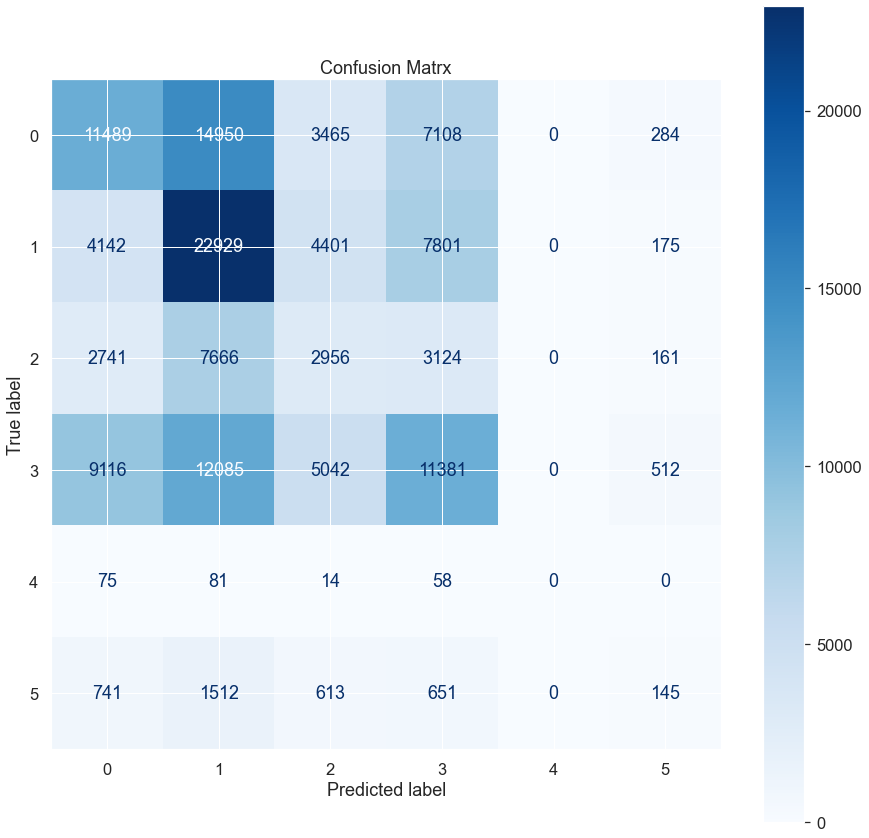

In [44]:
cats = CatBoostClassifier(auto_class_weights='Balanced', random_state=randomstate, thread_count=4,
                         bagging_temperature=1, border_count=32, depth=12, l2_leaf_reg=5, learning_rate=.1,
                         random_strength=0, iterations=1000)

scores = spot_check_classifier(cats, processed_train, y_train, "CatBoost", processed_val, y_val, models)
visuals(cats, processed_val, y_val)

# Eliminate Late Aircraft

In [45]:
other = final.loc[final['DELAY_REASON']!='LATE_AIRCRAFT']

In [46]:
# Make x-train and y-train
x_train = other.drop('DELAY_REASON', axis=1)
y_train = other['DELAY_REASON']

In [47]:
# load in validation data (from OS_dataset_cleanup)
val = pd.read_pickle('data/pkl/test_delays.pkl')
other2 = val.loc[val['DELAY_REASON']!='LATE_AIRCRAFT']

x_val = other2.drop('DELAY_REASON', axis=1)
y_val = other2['DELAY_REASON']

x_val.drop(columns=['AVG_MONTHLY_PASS_AIRLINE', 'AIRPORT_FLIGHTS_MONTH', 'AVG_MONTHLY_PASS_AIRPORT', 'CARRIER_NAME', 'DEPARTING_AIRPORT', 'PREVIOUS_AIRPORT', 'DAY_OF_WEEK', 'DEP_TIME_BLK', 'MONTH'], axis=1, inplace=True)

In [48]:
processed_train, pipe = pipeline_fit_preprocessor(x_train)
processed_val = pipeline_transform_preprocessor(x_val, pipe)

Setting up transforms - Polynomials, StandardScaler
Setting up processing pipeline
Fitting pipeline on train data
Transforming test data


In [49]:
# label encode target variables
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

In [28]:
# spot check models

weighted_models = {
    'L1 logistic': LogisticRegression(C=1e12, penalty='l1',
                                      solver='saga',
                                      multi_class='multinomial',
                                     fit_intercept=False),
    'L2 logistic (Multinomial)': LogisticRegression(C=1e12, penalty='l2',
                                                    solver='saga',
                                                    multi_class='multinomial',
                                         fit_intercept=False),
    'L2 logistic (OvR)': LogisticRegression(C=1e12, penalty='l2',
                                            solver='saga',
                                            multi_class='ovr',
                                         fit_intercept=False),
    "Decision Tree Classifier_Weighted": DecisionTreeClassifier(class_weight='balanced', random_state=randomstate),
    "Extra Trees_Weighted" : ExtraTreesClassifier(class_weight='balanced', random_state=randomstate, n_jobs=-1),
    "Random Forest_Weighted": RandomForestClassifier(class_weight='balanced', random_state=randomstate, n_jobs=-1),
    "Balanced Random Forest": BalancedRandomForestClassifier(random_state=randomstate, n_jobs=-1),
    "XGBoost_Weighted": XGBClassifier(random_state=randomstate, verbosity=0, n_jobs=-1),
    "CatBoost_Weighted": CatBoostClassifier(auto_class_weights='Balanced', random_state=randomstate, verbose=False, task_type='GPU', devices='0:1'),
}



for model in weighted_models:
    this_model = weighted_models[model]
    label = model
    spot_check = spot_check_classifier(this_model, processed_train, y_train, label, processed_val, y_val, spot_check)



Running L1 logistic Classification
CV 5 Accuracy Train Score: 49.07
CV 5 F1 Train Score: 31.58
CV 5 Auc Train Score: 68.24
CV 5 Precision Train Score: 31.95
CV 5 Recall Train Score: 31.83

Validation Accuracy ( 0.5 Thresh)):  0.3876107116807336
Validation f1 Score ( 0.5 Thresh):  0.15302087590807495
Validation Precision Score ( 0.5 Thresh):  0.2797218755235201
Validation Recall Score ( 0.5 Thresh):  0.21112641773185023 

              precision    recall  f1-score   support

           0       0.58      0.01      0.02     37296
           1       0.25      0.09      0.13     16648
           2       0.40      0.92      0.56     38136
           3       0.00      0.00      0.00       228
           4       0.18      0.03      0.05      3662

    accuracy                           0.39     95970
   macro avg       0.28      0.21      0.15     95970
weighted avg       0.43      0.39      0.25     95970

Elapsed Time: 261.18740701675415


Running L2 logistic (Multinomial) Classification


## Tuned Model

In [29]:
# run best tuned model
# model tuning in APPENDIX

cat_boost = CatBoostClassifier(auto_class_weights='Balanced', random_state=randomstate, verbose=False, task_type='GPU', devices='0:1')



Running CatBoost Classification
CV 5 Accuracy Train Score: 51.4
CV 5 F1 Train Score: 41.17
CV 5 Auc Train Score: 75.82
CV 5 Precision Train Score: 39.42
CV 5 Recall Train Score: 51.88

Validation Accuracy ( 0.5 Thresh)):  0.3826612483067625
Validation f1 Score ( 0.5 Thresh):  0.26041359026524125
Validation Precision Score ( 0.5 Thresh):  0.26581512007537145
Validation Recall Score ( 0.5 Thresh):  0.2821358966113734 

              precision    recall  f1-score   support

           0       0.51      0.31      0.39     37296
           1       0.25      0.43      0.32     16648
           2       0.47      0.45      0.46     38136
           3       0.00      0.00      0.00       228
           4       0.10      0.22      0.14      3662

    accuracy                           0.38     95970
   macro avg       0.27      0.28      0.26     95970
weighted avg       0.43      0.38      0.39     95970

Elapsed Time: 100.78570294380188

Confusion Matrix for Test Set


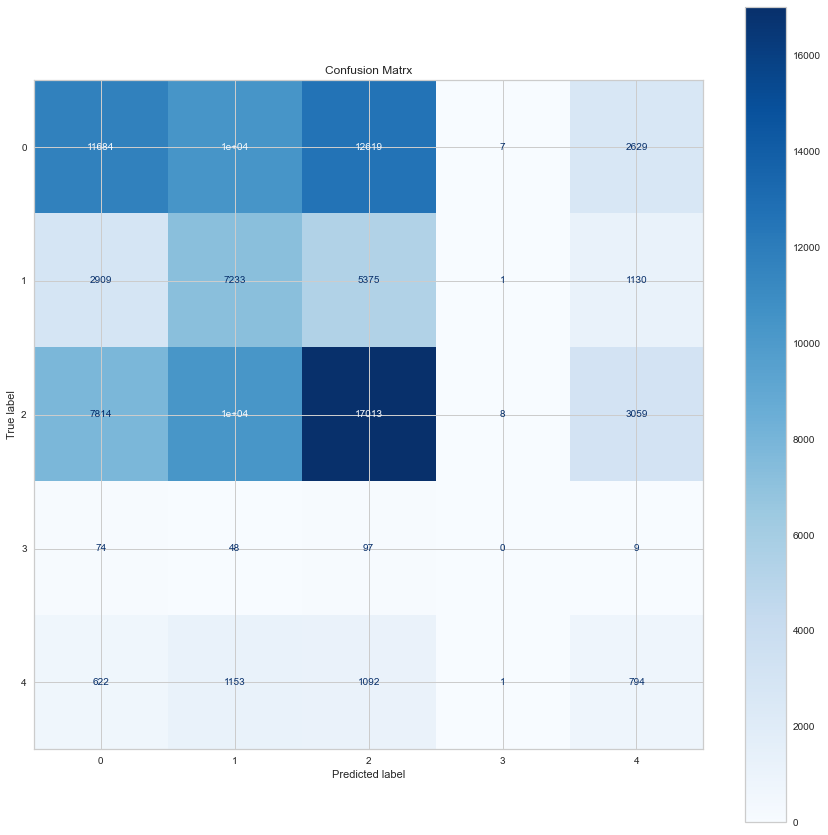

In [30]:
scores = spot_check_classifier(cat_boost, processed_train, y_train, "CatBoost", processed_val, y_val, models)
visuals(cat_boost, processed_val, y_val)

# Analysis

# APPENDIX - Parameter Tuning

Parameter tuning our CatBoost model

In [26]:
cats = CatBoostClassifier(auto_class_weights='Balanced', random_state=randomstate, thread_count=4)

In [34]:
#Parameter Tuning

param_grid = {'depth':[5, 10],
          'iterations':[1000],
          'learning_rate':[.01, 0.05], 
          'l2_leaf_reg':[50, 150],
          'border_count':[32, 255],
        'random_strength':[0,1],
        'bagging_temperature':[0,1],
          }


best_params = grid_optimizer(cats, param_grid, processed_train, y_train)
best_params

Making Search
Running Grid
n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 15266
max_resources_: 412196
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 64
n_resources: 15266
Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5; 1/64] START bagging_temperature=0, border_count=32, depth=5, iterations=1000, l2_leaf_reg=50, learning_rate=0.01, random_strength=0
0:	learn: 1.6068142	total: 5.87ms	remaining: 5.86s


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

200:	learn: 1.3368623	total: 1.08s	remaining: 4.28s
400:	learn: 1.2188782	total: 2.11s	remaining: 3.16s
600:	learn: 1.1531513	total: 3.09s	remaining: 2.05s
800:	learn: 1.1075761	total: 4.05s	remaining: 1s
999:	learn: 1.0764278	total: 4.96s	remaining: 0us
[CV 1/5; 1/64] END bagging_temperature=0, border_count=32, depth=5, iterations=1000, l2_leaf_reg=50, learning_rate=0.01, random_strength=0;, score=(train=0.365, test=0.319) total time=   5.0s
[CV 2/5; 1/64] START bagging_temperature=0, border_count=32, depth=5, iterations=1000, l2_leaf_reg=50, learning_rate=0.01, random_strength=0
0:	learn: 1.6066495	total: 6.73ms	remaining: 6.72s
200:	learn: 1.3295680	total: 1.09s	remaining: 4.34s
400:	learn: 1.2194710	total: 2.07s	remaining: 3.1s
600:	learn: 1.1520136	total: 3.03s	remaining: 2.01s
800:	learn: 1.1059030	total: 3.98s	remaining: 990ms
999:	learn: 1.0722213	total: 4.93s	remaining: 0us
[CV 2/5; 1/64] END bagging_temperature=0, border_count=32, depth=5, iterations=1000, l2_leaf_reg=50, lea

200:	learn: 1.0549674	total: 1.02s	remaining: 4.06s
400:	learn: 0.9597911	total: 2s	remaining: 2.98s
600:	learn: 0.9105964	total: 2.96s	remaining: 1.97s
800:	learn: 0.8766923	total: 3.93s	remaining: 976ms
999:	learn: 0.8541089	total: 4.87s	remaining: 0us
[CV 4/5; 3/64] END bagging_temperature=0, border_count=32, depth=5, iterations=1000, l2_leaf_reg=50, learning_rate=0.05, random_strength=0;, score=(train=0.472, test=0.327) total time=   4.9s
[CV 5/5; 3/64] START bagging_temperature=0, border_count=32, depth=5, iterations=1000, l2_leaf_reg=50, learning_rate=0.05, random_strength=0
0:	learn: 1.5957979	total: 7.48ms	remaining: 7.47s
200:	learn: 1.0694104	total: 1.02s	remaining: 4.08s
400:	learn: 0.9737964	total: 1.98s	remaining: 2.96s
600:	learn: 0.9186809	total: 2.96s	remaining: 1.96s
800:	learn: 0.8798800	total: 3.94s	remaining: 978ms
999:	learn: 0.8558844	total: 4.89s	remaining: 0us
[CV 5/5; 3/64] END bagging_temperature=0, border_count=32, depth=5, iterations=1000, l2_leaf_reg=50, le

200:	learn: 1.4622434	total: 1.07s	remaining: 4.26s
400:	learn: 1.3797321	total: 2.12s	remaining: 3.17s
600:	learn: 1.3215241	total: 3.15s	remaining: 2.09s
800:	learn: 1.2782439	total: 4.17s	remaining: 1.03s
999:	learn: 1.2380210	total: 5.17s	remaining: 0us
[CV 2/5; 6/64] END bagging_temperature=0, border_count=32, depth=5, iterations=1000, l2_leaf_reg=150, learning_rate=0.01, random_strength=1;, score=(train=0.315, test=0.280) total time=   5.2s
[CV 3/5; 6/64] START bagging_temperature=0, border_count=32, depth=5, iterations=1000, l2_leaf_reg=150, learning_rate=0.01, random_strength=1
0:	learn: 1.6084385	total: 15.2ms	remaining: 15.2s
200:	learn: 1.4349455	total: 1.06s	remaining: 4.23s
400:	learn: 1.3428702	total: 2.09s	remaining: 3.13s
600:	learn: 1.2796077	total: 3.13s	remaining: 2.08s
800:	learn: 1.2338909	total: 4.13s	remaining: 1.03s
999:	learn: 1.1945888	total: 5.14s	remaining: 0us
[CV 3/5; 6/64] END bagging_temperature=0, border_count=32, depth=5, iterations=1000, l2_leaf_reg=1

200:	learn: 1.2435801	total: 1.05s	remaining: 4.18s
400:	learn: 1.0895453	total: 2.01s	remaining: 3s
600:	learn: 1.0269289	total: 2.95s	remaining: 1.96s
800:	learn: 0.9865281	total: 3.89s	remaining: 966ms
999:	learn: 0.9546711	total: 4.85s	remaining: 0us
[CV 5/5; 8/64] END bagging_temperature=0, border_count=32, depth=5, iterations=1000, l2_leaf_reg=150, learning_rate=0.05, random_strength=1;, score=(train=0.412, test=0.335) total time=   4.9s
[CV 1/5; 9/64] START bagging_temperature=0, border_count=32, depth=10, iterations=1000, l2_leaf_reg=50, learning_rate=0.01, random_strength=0
0:	learn: 1.6070256	total: 43.2ms	remaining: 43.1s
200:	learn: 1.3202078	total: 8.58s	remaining: 34.1s
400:	learn: 1.1854918	total: 17.2s	remaining: 25.7s
600:	learn: 1.0973123	total: 25.8s	remaining: 17.1s
800:	learn: 1.0338436	total: 34.4s	remaining: 8.55s
999:	learn: 0.9818155	total: 42.9s	remaining: 0us
[CV 1/5; 9/64] END bagging_temperature=0, border_count=32, depth=10, iterations=1000, l2_leaf_reg=50,

200:	learn: 0.9642896	total: 8.61s	remaining: 34.2s
400:	learn: 0.8302609	total: 17s	remaining: 25.4s
600:	learn: 0.7537322	total: 25.4s	remaining: 16.9s
800:	learn: 0.6928266	total: 33.8s	remaining: 8.4s
999:	learn: 0.6446124	total: 42.2s	remaining: 0us
[CV 3/5; 11/64] END bagging_temperature=0, border_count=32, depth=10, iterations=1000, l2_leaf_reg=50, learning_rate=0.05, random_strength=0;, score=(train=0.673, test=0.346) total time=  42.5s
[CV 4/5; 11/64] START bagging_temperature=0, border_count=32, depth=10, iterations=1000, l2_leaf_reg=50, learning_rate=0.05, random_strength=0
0:	learn: 1.5967913	total: 43.5ms	remaining: 43.5s
200:	learn: 0.9825657	total: 8.68s	remaining: 34.5s
400:	learn: 0.8222766	total: 17.2s	remaining: 25.7s
600:	learn: 0.7417961	total: 25.6s	remaining: 17s
800:	learn: 0.6848064	total: 34.1s	remaining: 8.47s
999:	learn: 0.6377993	total: 42.5s	remaining: 0us
[CV 4/5; 11/64] END bagging_temperature=0, border_count=32, depth=10, iterations=1000, l2_leaf_reg=50

200:	learn: 1.4579621	total: 8.4s	remaining: 33.4s
400:	learn: 1.3553359	total: 16.9s	remaining: 25.2s
600:	learn: 1.2779971	total: 25.3s	remaining: 16.8s
800:	learn: 1.2192727	total: 33.7s	remaining: 8.37s
999:	learn: 1.1723059	total: 42.3s	remaining: 0us
[CV 1/5; 14/64] END bagging_temperature=0, border_count=32, depth=10, iterations=1000, l2_leaf_reg=150, learning_rate=0.01, random_strength=1;, score=(train=0.374, test=0.315) total time=  42.6s
[CV 2/5; 14/64] START bagging_temperature=0, border_count=32, depth=10, iterations=1000, l2_leaf_reg=150, learning_rate=0.01, random_strength=1
0:	learn: 1.6084355	total: 43.2ms	remaining: 43.1s
200:	learn: 1.4527132	total: 8.53s	remaining: 33.9s
400:	learn: 1.3486478	total: 17s	remaining: 25.4s
600:	learn: 1.2738639	total: 25.4s	remaining: 16.9s
800:	learn: 1.2163119	total: 33.9s	remaining: 8.41s
999:	learn: 1.1699739	total: 42.4s	remaining: 0us
[CV 2/5; 14/64] END bagging_temperature=0, border_count=32, depth=10, iterations=1000, l2_leaf_re

200:	learn: 1.1615860	total: 8.39s	remaining: 33.4s
400:	learn: 1.0280569	total: 17.1s	remaining: 25.5s
600:	learn: 0.9391114	total: 25.6s	remaining: 17s
800:	learn: 0.8793454	total: 34.1s	remaining: 8.48s
999:	learn: 0.8350340	total: 42.6s	remaining: 0us
[CV 4/5; 16/64] END bagging_temperature=0, border_count=32, depth=10, iterations=1000, l2_leaf_reg=150, learning_rate=0.05, random_strength=1;, score=(train=0.529, test=0.328) total time=  42.9s
[CV 5/5; 16/64] START bagging_temperature=0, border_count=32, depth=10, iterations=1000, l2_leaf_reg=150, learning_rate=0.05, random_strength=1
0:	learn: 1.6044098	total: 42.4ms	remaining: 42.4s
200:	learn: 1.1752139	total: 8.58s	remaining: 34.1s
400:	learn: 1.0271279	total: 17.2s	remaining: 25.7s
600:	learn: 0.9398342	total: 25.7s	remaining: 17.1s
800:	learn: 0.8801078	total: 34.2s	remaining: 8.49s
999:	learn: 0.8437201	total: 42.6s	remaining: 0us
[CV 5/5; 16/64] END bagging_temperature=0, border_count=32, depth=10, iterations=1000, l2_leaf_r

200:	learn: 1.0774510	total: 1.4s	remaining: 5.57s
400:	learn: 1.0143689	total: 2.67s	remaining: 3.98s
600:	learn: 0.9639386	total: 3.95s	remaining: 2.62s
800:	learn: 0.9337624	total: 5.21s	remaining: 1.29s
999:	learn: 0.9001275	total: 6.54s	remaining: 0us
[CV 2/5; 19/64] END bagging_temperature=0, border_count=255, depth=5, iterations=1000, l2_leaf_reg=50, learning_rate=0.05, random_strength=0;, score=(train=0.445, test=0.333) total time=   6.6s
[CV 3/5; 19/64] START bagging_temperature=0, border_count=255, depth=5, iterations=1000, l2_leaf_reg=50, learning_rate=0.05, random_strength=0
0:	learn: 1.5911950	total: 7.92ms	remaining: 7.91s
200:	learn: 1.0474994	total: 1.38s	remaining: 5.48s
400:	learn: 0.9949821	total: 2.63s	remaining: 3.93s
600:	learn: 0.9598299	total: 3.88s	remaining: 2.58s
800:	learn: 0.9221882	total: 5.18s	remaining: 1.29s
999:	learn: 0.8938374	total: 6.49s	remaining: 0us
[CV 3/5; 19/64] END bagging_temperature=0, border_count=255, depth=5, iterations=1000, l2_leaf_re

200:	learn: 1.4003063	total: 1.47s	remaining: 5.84s
400:	learn: 1.2999054	total: 2.92s	remaining: 4.36s
600:	learn: 1.2298902	total: 4.35s	remaining: 2.89s
800:	learn: 1.1823217	total: 5.76s	remaining: 1.43s
999:	learn: 1.1510331	total: 7.1s	remaining: 0us
[CV 5/5; 21/64] END bagging_temperature=0, border_count=255, depth=5, iterations=1000, l2_leaf_reg=150, learning_rate=0.01, random_strength=0;, score=(train=0.331, test=0.293) total time=   7.1s
[CV 1/5; 22/64] START bagging_temperature=0, border_count=255, depth=5, iterations=1000, l2_leaf_reg=150, learning_rate=0.01, random_strength=1
0:	learn: 1.6083241	total: 14.3ms	remaining: 14.2s
200:	learn: 1.4711950	total: 1.46s	remaining: 5.81s
400:	learn: 1.3889830	total: 2.89s	remaining: 4.31s
600:	learn: 1.3288283	total: 4.3s	remaining: 2.85s
800:	learn: 1.2849577	total: 5.68s	remaining: 1.41s
999:	learn: 1.2429792	total: 7.1s	remaining: 0us
[CV 1/5; 22/64] END bagging_temperature=0, border_count=255, depth=5, iterations=1000, l2_leaf_re

200:	learn: 1.2027639	total: 1.44s	remaining: 5.71s
400:	learn: 1.0665457	total: 2.81s	remaining: 4.2s
600:	learn: 1.0167546	total: 4.13s	remaining: 2.74s
800:	learn: 0.9886894	total: 5.44s	remaining: 1.35s
999:	learn: 0.9830179	total: 6.63s	remaining: 0us
[CV 3/5; 24/64] END bagging_temperature=0, border_count=255, depth=5, iterations=1000, l2_leaf_reg=150, learning_rate=0.05, random_strength=1;, score=(train=0.382, test=0.319) total time=   6.7s
[CV 4/5; 24/64] START bagging_temperature=0, border_count=255, depth=5, iterations=1000, l2_leaf_reg=150, learning_rate=0.05, random_strength=1
0:	learn: 1.6037269	total: 7.8ms	remaining: 7.79s
200:	learn: 1.2446452	total: 1.44s	remaining: 5.72s
400:	learn: 1.0970160	total: 2.82s	remaining: 4.21s
600:	learn: 1.0263348	total: 4.22s	remaining: 2.8s
800:	learn: 0.9864069	total: 5.58s	remaining: 1.39s
999:	learn: 0.9509138	total: 6.96s	remaining: 0us
[CV 4/5; 24/64] END bagging_temperature=0, border_count=255, depth=5, iterations=1000, l2_leaf_re

200:	learn: 0.9778959	total: 26.8s	remaining: 1m 46s
400:	learn: 0.8262061	total: 53s	remaining: 1m 19s
600:	learn: 0.7435503	total: 1m 19s	remaining: 52.5s
800:	learn: 0.6887106	total: 1m 45s	remaining: 26.1s
999:	learn: 0.6438347	total: 2m 11s	remaining: 0us
[CV 1/5; 27/64] END bagging_temperature=0, border_count=255, depth=10, iterations=1000, l2_leaf_reg=50, learning_rate=0.05, random_strength=0;, score=(train=0.693, test=0.375) total time= 2.2min
[CV 2/5; 27/64] START bagging_temperature=0, border_count=255, depth=10, iterations=1000, l2_leaf_reg=50, learning_rate=0.05, random_strength=0
0:	learn: 1.5971344	total: 136ms	remaining: 2m 15s
200:	learn: 0.9796384	total: 26.9s	remaining: 1m 47s
400:	learn: 0.8213084	total: 53.1s	remaining: 1m 19s
600:	learn: 0.7564112	total: 1m 19s	remaining: 52.6s
800:	learn: 0.7010368	total: 1m 45s	remaining: 26.2s
999:	learn: 0.6703218	total: 2m 11s	remaining: 0us
[CV 2/5; 27/64] END bagging_temperature=0, border_count=255, depth=10, iterations=1000

200:	learn: 1.4605234	total: 26.8s	remaining: 1m 46s
400:	learn: 1.3614103	total: 53.5s	remaining: 1m 19s
600:	learn: 1.2863210	total: 1m 19s	remaining: 53.1s
800:	learn: 1.2304099	total: 1m 46s	remaining: 26.5s
999:	learn: 1.1903162	total: 2m 12s	remaining: 0us
[CV 4/5; 29/64] END bagging_temperature=0, border_count=255, depth=10, iterations=1000, l2_leaf_reg=150, learning_rate=0.01, random_strength=0;, score=(train=0.361, test=0.286) total time= 2.2min
[CV 5/5; 29/64] START bagging_temperature=0, border_count=255, depth=10, iterations=1000, l2_leaf_reg=150, learning_rate=0.01, random_strength=0
0:	learn: 1.6084643	total: 138ms	remaining: 2m 17s
200:	learn: 1.4484892	total: 26.5s	remaining: 1m 45s
400:	learn: 1.3472242	total: 52.9s	remaining: 1m 19s
600:	learn: 1.2765202	total: 1m 19s	remaining: 52.7s
800:	learn: 1.2245765	total: 1m 45s	remaining: 26.3s
999:	learn: 1.1793002	total: 2m 12s	remaining: 0us
[CV 5/5; 29/64] END bagging_temperature=0, border_count=255, depth=10, iterations=

200:	learn: 1.1695484	total: 25.6s	remaining: 1m 41s
400:	learn: 1.0207549	total: 51.8s	remaining: 1m 17s
600:	learn: 0.9343233	total: 1m 17s	remaining: 51.7s
800:	learn: 0.8865853	total: 1m 43s	remaining: 25.8s
999:	learn: 0.8462285	total: 2m 9s	remaining: 0us
[CV 2/5; 32/64] END bagging_temperature=0, border_count=255, depth=10, iterations=1000, l2_leaf_reg=150, learning_rate=0.05, random_strength=1;, score=(train=0.530, test=0.330) total time= 2.2min
[CV 3/5; 32/64] START bagging_temperature=0, border_count=255, depth=10, iterations=1000, l2_leaf_reg=150, learning_rate=0.05, random_strength=1
0:	learn: 1.6019653	total: 134ms	remaining: 2m 13s
200:	learn: 1.1419305	total: 25.7s	remaining: 1m 42s
400:	learn: 1.0102482	total: 52s	remaining: 1m 17s
600:	learn: 0.9320081	total: 1m 18s	remaining: 51.9s
800:	learn: 0.8768798	total: 1m 44s	remaining: 25.9s
999:	learn: 0.8385638	total: 2m 9s	remaining: 0us
[CV 3/5; 32/64] END bagging_temperature=0, border_count=255, depth=10, iterations=1000

200:	learn: 1.4192379	total: 1.12s	remaining: 4.44s
400:	learn: 1.3228459	total: 2.19s	remaining: 3.27s
600:	learn: 1.2551508	total: 3.28s	remaining: 2.17s
800:	learn: 1.2035371	total: 4.36s	remaining: 1.08s
999:	learn: 1.1583336	total: 5.42s	remaining: 0us
[CV 5/5; 34/64] END bagging_temperature=1, border_count=32, depth=5, iterations=1000, l2_leaf_reg=50, learning_rate=0.01, random_strength=1;, score=(train=0.345, test=0.305) total time=   5.4s
[CV 1/5; 35/64] START bagging_temperature=1, border_count=32, depth=5, iterations=1000, l2_leaf_reg=50, learning_rate=0.05, random_strength=0
0:	learn: 1.5983773	total: 36.2ms	remaining: 36.2s
200:	learn: 1.0815439	total: 1.07s	remaining: 4.27s
400:	learn: 0.9721213	total: 2.11s	remaining: 3.16s
600:	learn: 0.9133856	total: 3.14s	remaining: 2.09s
800:	learn: 0.8731707	total: 4.17s	remaining: 1.04s
999:	learn: 0.8430702	total: 5.2s	remaining: 0us
[CV 1/5; 35/64] END bagging_temperature=1, border_count=32, depth=5, iterations=1000, l2_leaf_reg=5

200:	learn: 1.3760510	total: 1.11s	remaining: 4.43s
400:	learn: 1.2715451	total: 2.2s	remaining: 3.29s
600:	learn: 1.2098022	total: 3.25s	remaining: 2.15s
800:	learn: 1.1659122	total: 4.28s	remaining: 1.06s
999:	learn: 1.1333858	total: 5.3s	remaining: 0us
[CV 3/5; 37/64] END bagging_temperature=1, border_count=32, depth=5, iterations=1000, l2_leaf_reg=150, learning_rate=0.01, random_strength=0;, score=(train=0.327, test=0.296) total time=   5.3s
[CV 4/5; 37/64] START bagging_temperature=1, border_count=32, depth=5, iterations=1000, l2_leaf_reg=150, learning_rate=0.01, random_strength=0
0:	learn: 1.6078646	total: 5.29ms	remaining: 5.29s
200:	learn: 1.4107215	total: 1.09s	remaining: 4.32s
400:	learn: 1.3108657	total: 2.15s	remaining: 3.21s
600:	learn: 1.2460028	total: 3.19s	remaining: 2.12s
800:	learn: 1.1983194	total: 4.23s	remaining: 1.05s
999:	learn: 1.1613925	total: 5.25s	remaining: 0us
[CV 4/5; 37/64] END bagging_temperature=1, border_count=32, depth=5, iterations=1000, l2_leaf_reg=

200:	learn: 1.2487139	total: 1.07s	remaining: 4.25s
400:	learn: 1.0913046	total: 2.11s	remaining: 3.16s
600:	learn: 1.0175281	total: 3.15s	remaining: 2.09s
800:	learn: 0.9709501	total: 4.17s	remaining: 1.04s
999:	learn: 0.9378212	total: 5.18s	remaining: 0us
[CV 1/5; 40/64] END bagging_temperature=1, border_count=32, depth=5, iterations=1000, l2_leaf_reg=150, learning_rate=0.05, random_strength=1;, score=(train=0.426, test=0.329) total time=   5.2s
[CV 2/5; 40/64] START bagging_temperature=1, border_count=32, depth=5, iterations=1000, l2_leaf_reg=150, learning_rate=0.05, random_strength=1
0:	learn: 1.6037250	total: 21.1ms	remaining: 21s
200:	learn: 1.2405357	total: 1.06s	remaining: 4.22s
400:	learn: 1.0920520	total: 2.08s	remaining: 3.12s
600:	learn: 1.0188994	total: 3.1s	remaining: 2.06s
800:	learn: 0.9740493	total: 4.12s	remaining: 1.02s
999:	learn: 0.9408078	total: 5.11s	remaining: 0us
[CV 2/5; 40/64] END bagging_temperature=1, border_count=32, depth=5, iterations=1000, l2_leaf_reg=1

200:	learn: 1.3350138	total: 8.41s	remaining: 33.5s
400:	learn: 1.1924846	total: 16.8s	remaining: 25.1s
600:	learn: 1.1033833	total: 25.3s	remaining: 16.8s
800:	learn: 1.0410731	total: 33.6s	remaining: 8.36s
999:	learn: 0.9924691	total: 42.1s	remaining: 0us
[CV 4/5; 42/64] END bagging_temperature=1, border_count=32, depth=10, iterations=1000, l2_leaf_reg=50, learning_rate=0.01, random_strength=1;, score=(train=0.444, test=0.334) total time=  42.4s
[CV 5/5; 42/64] START bagging_temperature=1, border_count=32, depth=10, iterations=1000, l2_leaf_reg=50, learning_rate=0.01, random_strength=1
0:	learn: 1.6075517	total: 43.3ms	remaining: 43.2s
200:	learn: 1.3476302	total: 8.3s	remaining: 33s
400:	learn: 1.2060921	total: 16.7s	remaining: 24.9s
600:	learn: 1.1152735	total: 25.1s	remaining: 16.6s
800:	learn: 1.0503813	total: 33.4s	remaining: 8.29s
999:	learn: 0.9988619	total: 41.9s	remaining: 0us
[CV 5/5; 42/64] END bagging_temperature=1, border_count=32, depth=10, iterations=1000, l2_leaf_reg=

200:	learn: 1.4533805	total: 8.7s	remaining: 34.6s
400:	learn: 1.3500370	total: 17.3s	remaining: 25.9s
600:	learn: 1.2776973	total: 26s	remaining: 17.3s
800:	learn: 1.2229224	total: 34.7s	remaining: 8.62s
999:	learn: 1.1798039	total: 43.3s	remaining: 0us
[CV 2/5; 45/64] END bagging_temperature=1, border_count=32, depth=10, iterations=1000, l2_leaf_reg=150, learning_rate=0.01, random_strength=0;, score=(train=0.362, test=0.284) total time=  43.6s
[CV 3/5; 45/64] START bagging_temperature=1, border_count=32, depth=10, iterations=1000, l2_leaf_reg=150, learning_rate=0.01, random_strength=0
0:	learn: 1.6084417	total: 44ms	remaining: 44s
200:	learn: 1.4274028	total: 8.65s	remaining: 34.4s
400:	learn: 1.3173197	total: 17.3s	remaining: 25.8s
600:	learn: 1.2449244	total: 25.9s	remaining: 17.2s
800:	learn: 1.1922578	total: 34.5s	remaining: 8.58s
999:	learn: 1.1512351	total: 43.1s	remaining: 0us
[CV 3/5; 45/64] END bagging_temperature=1, border_count=32, depth=10, iterations=1000, l2_leaf_reg=15

200:	learn: 1.1728456	total: 8.74s	remaining: 34.8s
400:	learn: 1.0305288	total: 17.4s	remaining: 26.1s
600:	learn: 0.9407784	total: 26.1s	remaining: 17.3s
800:	learn: 0.8770872	total: 34.8s	remaining: 8.64s
999:	learn: 0.8277817	total: 43.5s	remaining: 0us
[CV 5/5; 47/64] END bagging_temperature=1, border_count=32, depth=10, iterations=1000, l2_leaf_reg=150, learning_rate=0.05, random_strength=0;, score=(train=0.564, test=0.355) total time=  43.7s
[CV 1/5; 48/64] START bagging_temperature=1, border_count=32, depth=10, iterations=1000, l2_leaf_reg=150, learning_rate=0.05, random_strength=1
0:	learn: 1.6046244	total: 44.9ms	remaining: 44.8s
200:	learn: 1.1757770	total: 8.62s	remaining: 34.3s
400:	learn: 1.0305847	total: 17.3s	remaining: 25.9s
600:	learn: 0.9430316	total: 26s	remaining: 17.3s
800:	learn: 0.8804432	total: 34.7s	remaining: 8.62s
999:	learn: 0.8324696	total: 43.3s	remaining: 0us
[CV 1/5; 48/64] END bagging_temperature=1, border_count=32, depth=10, iterations=1000, l2_leaf_r

200:	learn: 1.3924948	total: 1.47s	remaining: 5.84s
400:	learn: 1.2887117	total: 2.92s	remaining: 4.36s
600:	learn: 1.2229788	total: 4.36s	remaining: 2.89s
800:	learn: 1.1745449	total: 5.8s	remaining: 1.44s
999:	learn: 1.1316372	total: 7.23s	remaining: 0us
[CV 3/5; 50/64] END bagging_temperature=1, border_count=255, depth=5, iterations=1000, l2_leaf_reg=50, learning_rate=0.01, random_strength=1;, score=(train=0.338, test=0.303) total time=   7.3s
[CV 4/5; 50/64] START bagging_temperature=1, border_count=255, depth=5, iterations=1000, l2_leaf_reg=50, learning_rate=0.01, random_strength=1
0:	learn: 1.6082685	total: 13.5ms	remaining: 13.5s
200:	learn: 1.4161869	total: 1.43s	remaining: 5.68s
400:	learn: 1.3199811	total: 2.85s	remaining: 4.25s
600:	learn: 1.2511345	total: 4.28s	remaining: 2.84s
800:	learn: 1.2003440	total: 5.7s	remaining: 1.42s
999:	learn: 1.1574063	total: 7.11s	remaining: 0us
[CV 4/5; 50/64] END bagging_temperature=1, border_count=255, depth=5, iterations=1000, l2_leaf_reg

200:	learn: 1.4174602	total: 1.48s	remaining: 5.88s
400:	learn: 1.3175889	total: 2.92s	remaining: 4.37s
600:	learn: 1.2521652	total: 4.37s	remaining: 2.9s
800:	learn: 1.2053742	total: 5.77s	remaining: 1.43s
999:	learn: 1.1690960	total: 7.17s	remaining: 0us
[CV 1/5; 53/64] END bagging_temperature=1, border_count=255, depth=5, iterations=1000, l2_leaf_reg=150, learning_rate=0.01, random_strength=0;, score=(train=0.343, test=0.311) total time=   7.2s
[CV 2/5; 53/64] START bagging_temperature=1, border_count=255, depth=5, iterations=1000, l2_leaf_reg=150, learning_rate=0.01, random_strength=0
0:	learn: 1.6078739	total: 7.89ms	remaining: 7.89s
200:	learn: 1.4090412	total: 1.5s	remaining: 5.96s
400:	learn: 1.3131971	total: 2.95s	remaining: 4.41s
600:	learn: 1.2482498	total: 4.39s	remaining: 2.91s
800:	learn: 1.2021786	total: 5.8s	remaining: 1.44s
999:	learn: 1.1668759	total: 7.19s	remaining: 0us
[CV 2/5; 53/64] END bagging_temperature=1, border_count=255, depth=5, iterations=1000, l2_leaf_re

200:	learn: 1.1646660	total: 1.42s	remaining: 5.64s
400:	learn: 1.0592033	total: 2.8s	remaining: 4.18s
600:	learn: 1.0028524	total: 4.17s	remaining: 2.77s
800:	learn: 0.9650397	total: 5.53s	remaining: 1.37s
999:	learn: 0.9367772	total: 6.89s	remaining: 0us
[CV 4/5; 55/64] END bagging_temperature=1, border_count=255, depth=5, iterations=1000, l2_leaf_reg=150, learning_rate=0.05, random_strength=0;, score=(train=0.413, test=0.323) total time=   6.9s
[CV 5/5; 55/64] START bagging_temperature=1, border_count=255, depth=5, iterations=1000, l2_leaf_reg=150, learning_rate=0.05, random_strength=0
0:	learn: 1.6021095	total: 14.7ms	remaining: 14.7s
200:	learn: 1.1633486	total: 1.44s	remaining: 5.74s
400:	learn: 1.0549669	total: 2.83s	remaining: 4.23s
600:	learn: 0.9980445	total: 4.21s	remaining: 2.79s
800:	learn: 0.9604083	total: 5.58s	remaining: 1.39s
999:	learn: 0.9331455	total: 6.94s	remaining: 0us
[CV 5/5; 55/64] END bagging_temperature=1, border_count=255, depth=5, iterations=1000, l2_leaf_

200:	learn: 1.3412747	total: 25.8s	remaining: 1m 42s
400:	learn: 1.1995250	total: 51.4s	remaining: 1m 16s
600:	learn: 1.1108392	total: 1m 17s	remaining: 51.2s
800:	learn: 1.0477432	total: 1m 42s	remaining: 25.5s
999:	learn: 0.9981211	total: 2m 8s	remaining: 0us
[CV 2/5; 58/64] END bagging_temperature=1, border_count=255, depth=10, iterations=1000, l2_leaf_reg=50, learning_rate=0.01, random_strength=1;, score=(train=0.441, test=0.317) total time= 2.2min
[CV 3/5; 58/64] START bagging_temperature=1, border_count=255, depth=10, iterations=1000, l2_leaf_reg=50, learning_rate=0.01, random_strength=1
0:	learn: 1.6073465	total: 134ms	remaining: 2m 13s
200:	learn: 1.3175555	total: 25.5s	remaining: 1m 41s
400:	learn: 1.1774357	total: 51.2s	remaining: 1m 16s
600:	learn: 1.0924794	total: 1m 16s	remaining: 51s
800:	learn: 1.0334131	total: 1m 42s	remaining: 25.5s
999:	learn: 0.9874352	total: 2m 8s	remaining: 0us
[CV 3/5; 58/64] END bagging_temperature=1, border_count=255, depth=10, iterations=1000, 

200:	learn: 1.0030784	total: 25.3s	remaining: 1m 40s
400:	learn: 0.8416646	total: 50.7s	remaining: 1m 15s
600:	learn: 0.7550939	total: 1m 15s	remaining: 50.4s
800:	learn: 0.6957212	total: 1m 41s	remaining: 25.1s
999:	learn: 0.6471381	total: 2m 6s	remaining: 0us
[CV 5/5; 60/64] END bagging_temperature=1, border_count=255, depth=10, iterations=1000, l2_leaf_reg=50, learning_rate=0.05, random_strength=1;, score=(train=0.700, test=0.397) total time= 2.1min
[CV 1/5; 61/64] START bagging_temperature=1, border_count=255, depth=10, iterations=1000, l2_leaf_reg=150, learning_rate=0.01, random_strength=0
0:	learn: 1.6086768	total: 132ms	remaining: 2m 12s
200:	learn: 1.4502088	total: 25.9s	remaining: 1m 42s
400:	learn: 1.3442430	total: 51.6s	remaining: 1m 17s
600:	learn: 1.2703058	total: 1m 17s	remaining: 51.5s
800:	learn: 1.2143395	total: 1m 43s	remaining: 25.7s
999:	learn: 1.1700930	total: 2m 9s	remaining: 0us
[CV 1/5; 61/64] END bagging_temperature=1, border_count=255, depth=10, iterations=100

200:	learn: 1.1451970	total: 26s	remaining: 1m 43s
400:	learn: 1.0121243	total: 51.9s	remaining: 1m 17s
600:	learn: 0.9297947	total: 1m 17s	remaining: 51.5s
800:	learn: 0.8711512	total: 1m 43s	remaining: 25.6s
999:	learn: 0.8254376	total: 2m 8s	remaining: 0us
[CV 3/5; 63/64] END bagging_temperature=1, border_count=255, depth=10, iterations=1000, l2_leaf_reg=150, learning_rate=0.05, random_strength=0;, score=(train=0.546, test=0.330) total time= 2.1min
[CV 4/5; 63/64] START bagging_temperature=1, border_count=255, depth=10, iterations=1000, l2_leaf_reg=150, learning_rate=0.05, random_strength=0
0:	learn: 1.6048064	total: 137ms	remaining: 2m 16s
200:	learn: 1.1687384	total: 26.2s	remaining: 1m 44s
400:	learn: 1.0312160	total: 52.1s	remaining: 1m 17s
600:	learn: 0.9427367	total: 1m 18s	remaining: 51.8s
800:	learn: 0.8776803	total: 1m 43s	remaining: 25.8s
999:	learn: 0.8283131	total: 2m 9s	remaining: 0us
[CV 4/5; 63/64] END bagging_temperature=1, border_count=255, depth=10, iterations=1000

200:	learn: 1.2337895	total: 2.87s	remaining: 11.4s
400:	learn: 1.1068573	total: 5.54s	remaining: 8.27s
600:	learn: 1.0327505	total: 8.24s	remaining: 5.47s
800:	learn: 0.9962780	total: 10.8s	remaining: 2.68s
999:	learn: 0.9720887	total: 13.3s	remaining: 0us
[CV 1/5; 2/22] END bagging_temperature=0, border_count=255, depth=5, iterations=1000, l2_leaf_reg=50, learning_rate=0.05, random_strength=1;, score=(train=0.391, test=0.340) total time=  13.4s
[CV 2/5; 2/22] START bagging_temperature=0, border_count=255, depth=5, iterations=1000, l2_leaf_reg=50, learning_rate=0.05, random_strength=1
0:	learn: 1.5979496	total: 18ms	remaining: 18s
200:	learn: 1.2441537	total: 2.83s	remaining: 11.2s
400:	learn: 1.1182132	total: 5.42s	remaining: 8.1s
600:	learn: 1.0510673	total: 7.97s	remaining: 5.29s
800:	learn: 1.0079849	total: 10.6s	remaining: 2.63s
999:	learn: 0.9817227	total: 13.1s	remaining: 0us
[CV 2/5; 2/22] END bagging_temperature=0, border_count=255, depth=5, iterations=1000, l2_leaf_reg=50, l

0:	learn: 1.6036921	total: 177ms	remaining: 2m 57s
200:	learn: 1.1175414	total: 34.2s	remaining: 2m 15s
400:	learn: 0.9911832	total: 1m 7s	remaining: 1m 40s
600:	learn: 0.9335753	total: 1m 40s	remaining: 1m 6s
800:	learn: 0.8912316	total: 2m 12s	remaining: 33s
999:	learn: 0.8580686	total: 2m 45s	remaining: 0us
[CV 4/5; 4/22] END bagging_temperature=0, border_count=255, depth=10, iterations=1000, l2_leaf_reg=150, learning_rate=0.05, random_strength=0;, score=(train=0.487, test=0.348) total time= 2.8min
[CV 5/5; 4/22] START bagging_temperature=0, border_count=255, depth=10, iterations=1000, l2_leaf_reg=150, learning_rate=0.05, random_strength=0
0:	learn: 1.6040404	total: 178ms	remaining: 2m 58s
200:	learn: 1.1221077	total: 33.8s	remaining: 2m 14s
400:	learn: 0.9896090	total: 1m 6s	remaining: 1m 39s
600:	learn: 0.9281330	total: 1m 39s	remaining: 1m 5s
800:	learn: 0.8871445	total: 2m 11s	remaining: 32.8s
999:	learn: 0.8545130	total: 2m 44s	remaining: 0us
[CV 5/5; 4/22] END bagging_temperat

200:	learn: 1.1444633	total: 16.2s	remaining: 1m 4s
400:	learn: 1.0019644	total: 32.3s	remaining: 48.2s
600:	learn: 0.9284109	total: 48.4s	remaining: 32.1s
800:	learn: 0.8788939	total: 1m 4s	remaining: 16s
999:	learn: 0.8416569	total: 1m 20s	remaining: 0us
[CV 2/5; 7/22] END bagging_temperature=1, border_count=32, depth=10, iterations=1000, l2_leaf_reg=150, learning_rate=0.05, random_strength=1;, score=(train=0.500, test=0.373) total time= 1.3min
[CV 3/5; 7/22] START bagging_temperature=1, border_count=32, depth=10, iterations=1000, l2_leaf_reg=150, learning_rate=0.05, random_strength=1
0:	learn: 1.6019361	total: 78.3ms	remaining: 1m 18s
200:	learn: 1.1567289	total: 16.2s	remaining: 1m 4s
400:	learn: 1.0125921	total: 32.3s	remaining: 48.3s
600:	learn: 0.9369358	total: 48.5s	remaining: 32.2s
800:	learn: 0.8868630	total: 1m 4s	remaining: 16.1s
999:	learn: 0.8479058	total: 1m 20s	remaining: 0us
[CV 3/5; 7/22] END bagging_temperature=1, border_count=32, depth=10, iterations=1000, l2_leaf_r

200:	learn: 1.2502063	total: 3.02s	remaining: 12s
400:	learn: 1.1108278	total: 6.01s	remaining: 8.98s
600:	learn: 1.0364117	total: 9s	remaining: 5.98s
800:	learn: 0.9872411	total: 12s	remaining: 2.97s
999:	learn: 0.9548168	total: 14.9s	remaining: 0us
[CV 5/5; 9/22] END bagging_temperature=1, border_count=255, depth=5, iterations=1000, l2_leaf_reg=50, learning_rate=0.05, random_strength=1;, score=(train=0.403, test=0.340) total time=  14.9s
[CV 1/5; 10/22] START bagging_temperature=0, border_count=32, depth=10, iterations=1000, l2_leaf_reg=150, learning_rate=0.05, random_strength=1
0:	learn: 1.6029067	total: 78.6ms	remaining: 1m 18s
200:	learn: 1.1350212	total: 15.7s	remaining: 1m 2s
400:	learn: 0.9994337	total: 31.2s	remaining: 46.6s
600:	learn: 0.9318686	total: 46.8s	remaining: 31s
800:	learn: 0.8868714	total: 1m 2s	remaining: 15.5s
999:	learn: 0.8507816	total: 1m 17s	remaining: 0us
[CV 1/5; 10/22] END bagging_temperature=0, border_count=32, depth=10, iterations=1000, l2_leaf_reg=150,

200:	learn: 1.1979010	total: 2.79s	remaining: 11.1s
400:	learn: 1.0902526	total: 5.53s	remaining: 8.26s
600:	learn: 1.0261145	total: 8.28s	remaining: 5.49s
800:	learn: 0.9834377	total: 11s	remaining: 2.73s
999:	learn: 0.9538020	total: 13.7s	remaining: 0us
[CV 3/5; 12/22] END bagging_temperature=1, border_count=255, depth=5, iterations=1000, l2_leaf_reg=50, learning_rate=0.05, random_strength=0;, score=(train=0.410, test=0.343) total time=  13.7s
[CV 4/5; 12/22] START bagging_temperature=1, border_count=255, depth=5, iterations=1000, l2_leaf_reg=50, learning_rate=0.05, random_strength=0
0:	learn: 1.5962381	total: 17.8ms	remaining: 17.8s
200:	learn: 1.1792244	total: 2.86s	remaining: 11.4s
400:	learn: 1.0763027	total: 5.73s	remaining: 8.56s
600:	learn: 1.0153589	total: 8.62s	remaining: 5.72s
800:	learn: 0.9746156	total: 11.5s	remaining: 2.85s
999:	learn: 0.9458312	total: 14.3s	remaining: 0us
[CV 4/5; 12/22] END bagging_temperature=1, border_count=255, depth=5, iterations=1000, l2_leaf_reg

200:	learn: 1.0156749	total: 15.7s	remaining: 1m 2s
400:	learn: 0.8824161	total: 31.5s	remaining: 47.1s
600:	learn: 0.8132833	total: 47.3s	remaining: 31.4s
800:	learn: 0.7621051	total: 1m 2s	remaining: 15.7s
999:	learn: 0.7184073	total: 1m 18s	remaining: 0us
[CV 1/5; 15/22] END bagging_temperature=0, border_count=32, depth=10, iterations=1000, l2_leaf_reg=50, learning_rate=0.05, random_strength=1;, score=(train=0.584, test=0.373) total time= 1.3min
[CV 2/5; 15/22] START bagging_temperature=0, border_count=32, depth=10, iterations=1000, l2_leaf_reg=50, learning_rate=0.05, random_strength=1
0:	learn: 1.5970663	total: 78.5ms	remaining: 1m 18s
200:	learn: 1.0278417	total: 15.4s	remaining: 1m 1s
400:	learn: 0.8855064	total: 31.1s	remaining: 46.4s
600:	learn: 0.8126755	total: 46.7s	remaining: 31s
800:	learn: 0.7638863	total: 1m 2s	remaining: 15.5s
999:	learn: 0.7206587	total: 1m 17s	remaining: 0us
[CV 2/5; 15/22] END bagging_temperature=0, border_count=32, depth=10, iterations=1000, l2_leaf_

200:	learn: 0.9814882	total: 16.2s	remaining: 1m 4s
400:	learn: 0.8658984	total: 32.1s	remaining: 48s
600:	learn: 0.7984325	total: 48s	remaining: 31.9s
800:	learn: 0.7571989	total: 1m 3s	remaining: 15.8s
999:	learn: 0.7142967	total: 1m 19s	remaining: 0us
[CV 4/5; 17/22] END bagging_temperature=0, border_count=32, depth=10, iterations=1000, l2_leaf_reg=50, learning_rate=0.05, random_strength=0;, score=(train=0.609, test=0.366) total time= 1.3min
[CV 5/5; 17/22] START bagging_temperature=0, border_count=32, depth=10, iterations=1000, l2_leaf_reg=50, learning_rate=0.05, random_strength=0
0:	learn: 1.5973477	total: 81.1ms	remaining: 1m 21s
200:	learn: 0.9808789	total: 16s	remaining: 1m 3s
400:	learn: 0.8668392	total: 31.7s	remaining: 47.3s
600:	learn: 0.8013638	total: 47.6s	remaining: 31.6s
800:	learn: 0.7484301	total: 1m 3s	remaining: 15.8s
999:	learn: 0.7308540	total: 1m 19s	remaining: 0us
[CV 5/5; 17/22] END bagging_temperature=0, border_count=32, depth=10, iterations=1000, l2_leaf_reg=

0:	learn: 1.5948382	total: 172ms	remaining: 2m 52s
200:	learn: 0.9746268	total: 34.7s	remaining: 2m 17s
400:	learn: 0.8598595	total: 1m 8s	remaining: 1m 42s
600:	learn: 0.7973533	total: 1m 42s	remaining: 1m 8s
800:	learn: 0.7517991	total: 2m 16s	remaining: 34s
999:	learn: 0.7131877	total: 2m 50s	remaining: 0us
[CV 2/5; 20/22] END bagging_temperature=1, border_count=255, depth=10, iterations=1000, l2_leaf_reg=50, learning_rate=0.05, random_strength=0;, score=(train=0.610, test=0.398) total time= 2.9min
[CV 3/5; 20/22] START bagging_temperature=1, border_count=255, depth=10, iterations=1000, l2_leaf_reg=50, learning_rate=0.05, random_strength=0
0:	learn: 1.5952768	total: 179ms	remaining: 2m 58s
200:	learn: 0.9853407	total: 34.6s	remaining: 2m 17s
400:	learn: 0.8689495	total: 1m 8s	remaining: 1m 42s
600:	learn: 0.8015040	total: 1m 42s	remaining: 1m 8s
800:	learn: 0.7521907	total: 2m 16s	remaining: 34s
999:	learn: 0.7116631	total: 2m 50s	remaining: 0us
[CV 3/5; 20/22] END bagging_temperatu

200:	learn: 0.9765631	total: 16.2s	remaining: 1m 4s
400:	learn: 0.8580771	total: 32.1s	remaining: 47.9s
600:	learn: 0.7872819	total: 48s	remaining: 31.9s
800:	learn: 0.7336855	total: 1m 3s	remaining: 15.9s
999:	learn: 0.6902071	total: 1m 19s	remaining: 0us
[CV 5/5; 22/22] END bagging_temperature=1, border_count=32, depth=10, iterations=1000, l2_leaf_reg=50, learning_rate=0.05, random_strength=0;, score=(train=0.630, test=0.372) total time= 1.3min
----------
iter: 2
n_candidates: 8
n_resources: 137394
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5; 1/8] START bagging_temperature=0, border_count=255, depth=10, iterations=1000, l2_leaf_reg=50, learning_rate=0.05, random_strength=0
0:	learn: 1.5949834	total: 301ms	remaining: 5m
200:	learn: 1.0400884	total: 58s	remaining: 3m 50s
400:	learn: 0.9418221	total: 1m 54s	remaining: 2m 51s
600:	learn: 0.8825814	total: 2m 51s	remaining: 1m 53s
800:	learn: 0.8384914	total: 3m 47s	remaining: 56.6s
999:	learn: 0.8061434	total: 4m 4

0:	learn: 1.5950553	total: 318ms	remaining: 5m 18s
200:	learn: 1.0237084	total: 59.4s	remaining: 3m 56s
400:	learn: 0.9132339	total: 1m 57s	remaining: 2m 55s
600:	learn: 0.8538184	total: 2m 54s	remaining: 1m 55s
800:	learn: 0.8118930	total: 3m 51s	remaining: 57.6s
999:	learn: 0.7780533	total: 4m 49s	remaining: 0us
[CV 3/5; 3/8] END bagging_temperature=1, border_count=255, depth=10, iterations=1000, l2_leaf_reg=50, learning_rate=0.05, random_strength=0;, score=(train=0.522, test=0.388) total time= 4.8min
[CV 4/5; 3/8] START bagging_temperature=1, border_count=255, depth=10, iterations=1000, l2_leaf_reg=50, learning_rate=0.05, random_strength=0
0:	learn: 1.5928717	total: 300ms	remaining: 4m 59s
200:	learn: 1.0162826	total: 58.3s	remaining: 3m 51s
400:	learn: 0.9108793	total: 1m 56s	remaining: 2m 54s
600:	learn: 0.8543199	total: 2m 54s	remaining: 1m 55s
800:	learn: 0.8141041	total: 3m 52s	remaining: 57.8s
999:	learn: 0.7818667	total: 4m 50s	remaining: 0us
[CV 4/5; 3/8] END bagging_tempera

0:	learn: 1.5966544	total: 301ms	remaining: 5m
200:	learn: 1.0778190	total: 58.8s	remaining: 3m 53s
400:	learn: 0.9386589	total: 1m 57s	remaining: 2m 56s
600:	learn: 0.8677536	total: 2m 57s	remaining: 1m 57s
800:	learn: 0.8217753	total: 3m 55s	remaining: 58.5s
999:	learn: 0.7854073	total: 4m 53s	remaining: 0us
[CV 1/5; 6/8] END bagging_temperature=1, border_count=255, depth=10, iterations=1000, l2_leaf_reg=50, learning_rate=0.05, random_strength=1;, score=(train=0.523, test=0.393) total time= 4.9min
[CV 2/5; 6/8] START bagging_temperature=1, border_count=255, depth=10, iterations=1000, l2_leaf_reg=50, learning_rate=0.05, random_strength=1
0:	learn: 1.5956465	total: 292ms	remaining: 4m 51s
200:	learn: 1.0731577	total: 58.6s	remaining: 3m 52s
400:	learn: 0.9362663	total: 1m 57s	remaining: 2m 55s
600:	learn: 0.8674891	total: 2m 55s	remaining: 1m 56s
800:	learn: 0.8218189	total: 3m 53s	remaining: 58.1s
999:	learn: 0.7874327	total: 4m 51s	remaining: 0us
[CV 2/5; 6/8] END bagging_temperature

0:	learn: 1.5933299	total: 204ms	remaining: 3m 23s
200:	learn: 1.0100127	total: 39.6s	remaining: 2m 37s
400:	learn: 0.9002990	total: 1m 18s	remaining: 1m 57s
600:	learn: 0.8389611	total: 1m 57s	remaining: 1m 18s
800:	learn: 0.7951775	total: 2m 36s	remaining: 38.9s
999:	learn: 0.7603684	total: 3m 15s	remaining: 0us
[CV 4/5; 8/8] END bagging_temperature=1, border_count=32, depth=10, iterations=1000, l2_leaf_reg=50, learning_rate=0.05, random_strength=0;, score=(train=0.543, test=0.385) total time= 3.3min
[CV 5/5; 8/8] START bagging_temperature=1, border_count=32, depth=10, iterations=1000, l2_leaf_reg=50, learning_rate=0.05, random_strength=0
0:	learn: 1.5940835	total: 204ms	remaining: 3m 23s
200:	learn: 1.0169321	total: 39.8s	remaining: 2m 38s
400:	learn: 0.9051201	total: 1m 19s	remaining: 1m 58s
600:	learn: 0.8418926	total: 1m 58s	remaining: 1m 18s
800:	learn: 0.7983080	total: 2m 38s	remaining: 39.3s
999:	learn: 0.7622405	total: 3m 17s	remaining: 0us
[CV 5/5; 8/8] END bagging_temperatu

999:	learn: 0.8144787	total: 9m 23s	remaining: 0us
[CV 1/5; 3/3] END bagging_temperature=1, border_count=32, depth=10, iterations=1000, l2_leaf_reg=50, learning_rate=0.05, random_strength=0;, score=(train=0.484, test=0.409) total time= 9.4min
[CV 2/5; 3/3] START bagging_temperature=1, border_count=32, depth=10, iterations=1000, l2_leaf_reg=50, learning_rate=0.05, random_strength=0
0:	learn: 1.5910706	total: 570ms	remaining: 9m 29s
200:	learn: 1.0765863	total: 1m 53s	remaining: 7m 30s
400:	learn: 0.9587636	total: 3m 45s	remaining: 5m 36s
600:	learn: 0.8923778	total: 5m 38s	remaining: 3m 44s
800:	learn: 0.8479186	total: 7m 30s	remaining: 1m 52s
999:	learn: 0.8141556	total: 9m 23s	remaining: 0us
[CV 2/5; 3/3] END bagging_temperature=1, border_count=32, depth=10, iterations=1000, l2_leaf_reg=50, learning_rate=0.05, random_strength=0;, score=(train=0.484, test=0.411) total time= 9.4min
[CV 3/5; 3/3] START bagging_temperature=1, border_count=32, depth=10, iterations=1000, l2_leaf_reg=50, lea

{'bagging_temperature': 1,
 'border_count': 32,
 'depth': 10,
 'iterations': 1000,
 'l2_leaf_reg': 50,
 'learning_rate': 0.05,
 'random_strength': 0}

{'bagging_temperature': 1,
 'border_count': 32,
 'depth': 10,
 'iterations': 1000,
 'l2_leaf_reg': 50,
 'learning_rate': 0.05,
 'random_strength': 0}

In [27]:
#Parameter Tuning

param_grid = {'depth':[8, 10, 12],
          'iterations':[500],
          'learning_rate':[.1, 0.05], 
          'l2_leaf_reg':[5, 50],
          'border_count':[32],
        'random_strength':[0,1],
        'bagging_temperature':[1],
          }


best_params = grid_optimizer(cats, param_grid, processed_train, y_train)
best_params

Making Search
Running Grid
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 78984
max_resources_: 710864
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 24
n_resources: 78984
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5; 1/24] START bagging_temperature=1, border_count=32, depth=8, iterations=500, l2_leaf_reg=5, learning_rate=0.1, random_strength=0
0:	learn: 1.7443161	total: 95.1ms	remaining: 47.5s
200:	learn: 0.9924369	total: 16.6s	remaining: 24.7s
400:	learn: 0.8504709	total: 33.2s	remaining: 8.2s
499:	learn: 0.8005578	total: 41.6s	remaining: 0us
[CV 1/5; 1/24] END bagging_temperature=1, border_count=32, depth=8, iterations=500, l2_leaf_reg=5, learning_rate=0.1, random_strength=0;, score=(train=0.606, test=0.336) total time=  41.7s
[CV 2/5; 1/24] START bagging_temperature=1, border_count=32, depth=8, iterations=500, l2_leaf_reg=5, learning_rate=0.1, random_strength=0
0:	learn: 1.7428839	total: 85.2ms	re

0:	learn: 1.7702325	total: 84.6ms	remaining: 42.2s
200:	learn: 1.1711038	total: 16.9s	remaining: 25.1s
400:	learn: 1.0166263	total: 33.8s	remaining: 8.34s
499:	learn: 0.9682633	total: 42.2s	remaining: 0us
[CV 1/5; 4/24] END bagging_temperature=1, border_count=32, depth=8, iterations=500, l2_leaf_reg=5, learning_rate=0.05, random_strength=1;, score=(train=0.469, test=0.314) total time=  42.2s
[CV 2/5; 4/24] START bagging_temperature=1, border_count=32, depth=8, iterations=500, l2_leaf_reg=5, learning_rate=0.05, random_strength=1
0:	learn: 1.7709047	total: 89.9ms	remaining: 44.9s
200:	learn: 1.1541783	total: 16.6s	remaining: 24.7s
400:	learn: 1.0078271	total: 33.6s	remaining: 8.29s
499:	learn: 0.9630300	total: 42s	remaining: 0us
[CV 2/5; 4/24] END bagging_temperature=1, border_count=32, depth=8, iterations=500, l2_leaf_reg=5, learning_rate=0.05, random_strength=1;, score=(train=0.471, test=0.325) total time=  42.0s
[CV 3/5; 4/24] START bagging_temperature=1, border_count=32, depth=8, ite

0:	learn: 1.7757638	total: 88.4ms	remaining: 44.1s
200:	learn: 1.2253360	total: 17.2s	remaining: 25.6s
400:	learn: 1.1226260	total: 34.3s	remaining: 8.47s
499:	learn: 1.0905482	total: 42.6s	remaining: 0us
[CV 2/5; 7/24] END bagging_temperature=1, border_count=32, depth=8, iterations=500, l2_leaf_reg=50, learning_rate=0.05, random_strength=0;, score=(train=0.378, test=0.308) total time=  42.7s
[CV 3/5; 7/24] START bagging_temperature=1, border_count=32, depth=8, iterations=500, l2_leaf_reg=50, learning_rate=0.05, random_strength=0
0:	learn: 1.7770094	total: 89.8ms	remaining: 44.8s
200:	learn: 1.2401419	total: 16.9s	remaining: 25.1s
400:	learn: 1.1342774	total: 33.5s	remaining: 8.28s
499:	learn: 1.1005930	total: 41.8s	remaining: 0us
[CV 3/5; 7/24] END bagging_temperature=1, border_count=32, depth=8, iterations=500, l2_leaf_reg=50, learning_rate=0.05, random_strength=0;, score=(train=0.377, test=0.290) total time=  41.8s
[CV 4/5; 7/24] START bagging_temperature=1, border_count=32, depth=8

[CV 2/5; 10/24] END bagging_temperature=1, border_count=32, depth=10, iterations=500, l2_leaf_reg=5, learning_rate=0.1, random_strength=1;, score=(train=0.788, test=0.352) total time= 1.2min
[CV 3/5; 10/24] START bagging_temperature=1, border_count=32, depth=10, iterations=500, l2_leaf_reg=5, learning_rate=0.1, random_strength=1
0:	learn: 1.7387815	total: 150ms	remaining: 1m 14s
200:	learn: 0.8438965	total: 28.1s	remaining: 41.8s
400:	learn: 0.6513951	total: 56.4s	remaining: 13.9s
499:	learn: 0.5869028	total: 1m 10s	remaining: 0us
[CV 3/5; 10/24] END bagging_temperature=1, border_count=32, depth=10, iterations=500, l2_leaf_reg=5, learning_rate=0.1, random_strength=1;, score=(train=0.783, test=0.318) total time= 1.2min
[CV 4/5; 10/24] START bagging_temperature=1, border_count=32, depth=10, iterations=500, l2_leaf_reg=5, learning_rate=0.1, random_strength=1
0:	learn: 1.7333055	total: 147ms	remaining: 1m 13s
200:	learn: 0.8380860	total: 28.2s	remaining: 42s
400:	learn: 0.6452099	total: 56

200:	learn: 1.0567459	total: 28s	remaining: 41.6s
400:	learn: 0.9256878	total: 55.9s	remaining: 13.8s
499:	learn: 0.8794932	total: 1m 9s	remaining: 0us
[CV 3/5; 13/24] END bagging_temperature=1, border_count=32, depth=10, iterations=500, l2_leaf_reg=50, learning_rate=0.1, random_strength=0;, score=(train=0.552, test=0.305) total time= 1.2min
[CV 4/5; 13/24] START bagging_temperature=1, border_count=32, depth=10, iterations=500, l2_leaf_reg=50, learning_rate=0.1, random_strength=0
0:	learn: 1.7610555	total: 145ms	remaining: 1m 12s
200:	learn: 1.0494666	total: 28.1s	remaining: 41.8s
400:	learn: 0.9247200	total: 56.1s	remaining: 13.8s
499:	learn: 0.8787326	total: 1m 10s	remaining: 0us
[CV 4/5; 13/24] END bagging_temperature=1, border_count=32, depth=10, iterations=500, l2_leaf_reg=50, learning_rate=0.1, random_strength=0;, score=(train=0.529, test=0.316) total time= 1.2min
[CV 5/5; 13/24] START bagging_temperature=1, border_count=32, depth=10, iterations=500, l2_leaf_reg=50, learning_rate

[CV 3/5; 16/24] END bagging_temperature=1, border_count=32, depth=10, iterations=500, l2_leaf_reg=50, learning_rate=0.05, random_strength=1;, score=(train=0.437, test=0.298) total time= 1.2min
[CV 4/5; 16/24] START bagging_temperature=1, border_count=32, depth=10, iterations=500, l2_leaf_reg=50, learning_rate=0.05, random_strength=1
0:	learn: 1.7744540	total: 146ms	remaining: 1m 12s
200:	learn: 1.1898647	total: 28.1s	remaining: 41.8s
400:	learn: 1.0619939	total: 55.8s	remaining: 13.8s
499:	learn: 1.0223280	total: 1m 9s	remaining: 0us
[CV 4/5; 16/24] END bagging_temperature=1, border_count=32, depth=10, iterations=500, l2_leaf_reg=50, learning_rate=0.05, random_strength=1;, score=(train=0.416, test=0.297) total time= 1.2min
[CV 5/5; 16/24] START bagging_temperature=1, border_count=32, depth=10, iterations=500, l2_leaf_reg=50, learning_rate=0.05, random_strength=1
0:	learn: 1.7784644	total: 140ms	remaining: 1m 9s
200:	learn: 1.1923142	total: 28.2s	remaining: 41.9s
400:	learn: 1.0635444	t

0:	learn: 1.7521533	total: 373ms	remaining: 3m 6s
200:	learn: 0.8195589	total: 1m 9s	remaining: 1m 43s
400:	learn: 0.6376754	total: 2m 19s	remaining: 34.4s
499:	learn: 0.5741354	total: 2m 54s	remaining: 0us
[CV 4/5; 19/24] END bagging_temperature=1, border_count=32, depth=12, iterations=500, l2_leaf_reg=5, learning_rate=0.05, random_strength=0;, score=(train=0.806, test=0.331) total time= 2.9min
[CV 5/5; 19/24] START bagging_temperature=1, border_count=32, depth=12, iterations=500, l2_leaf_reg=5, learning_rate=0.05, random_strength=0
0:	learn: 1.7538676	total: 359ms	remaining: 2m 59s
200:	learn: 0.8135704	total: 1m 9s	remaining: 1m 43s
400:	learn: 0.6352163	total: 2m 19s	remaining: 34.6s
499:	learn: 0.5714783	total: 2m 54s	remaining: 0us
[CV 5/5; 19/24] END bagging_temperature=1, border_count=32, depth=12, iterations=500, l2_leaf_reg=5, learning_rate=0.05, random_strength=0;, score=(train=0.806, test=0.326) total time= 2.9min
[CV 1/5; 20/24] START bagging_temperature=1, border_count=32

400:	learn: 0.8517198	total: 2m 17s	remaining: 34s
499:	learn: 0.7960837	total: 2m 53s	remaining: 0us
[CV 4/5; 22/24] END bagging_temperature=1, border_count=32, depth=12, iterations=500, l2_leaf_reg=50, learning_rate=0.1, random_strength=1;, score=(train=0.613, test=0.324) total time= 2.9min
[CV 5/5; 22/24] START bagging_temperature=1, border_count=32, depth=12, iterations=500, l2_leaf_reg=50, learning_rate=0.1, random_strength=1
0:	learn: 1.7631547	total: 340ms	remaining: 2m 49s
200:	learn: 1.0073699	total: 1m 7s	remaining: 1m 40s
400:	learn: 0.8494540	total: 2m 17s	remaining: 33.9s
499:	learn: 0.7939196	total: 2m 52s	remaining: 0us
[CV 5/5; 22/24] END bagging_temperature=1, border_count=32, depth=12, iterations=500, l2_leaf_reg=50, learning_rate=0.1, random_strength=1;, score=(train=0.628, test=0.316) total time= 2.9min
[CV 1/5; 23/24] START bagging_temperature=1, border_count=32, depth=12, iterations=500, l2_leaf_reg=50, learning_rate=0.05, random_strength=0
0:	learn: 1.7787508	tot

400:	learn: 0.6184983	total: 5m 29s	remaining: 1m 21s
499:	learn: 0.5569924	total: 6m 57s	remaining: 0us
[CV 4/5; 1/8] END bagging_temperature=1, border_count=32, depth=12, iterations=500, l2_leaf_reg=5, learning_rate=0.1, random_strength=0;, score=(train=0.781, test=0.363) total time= 7.0min
[CV 5/5; 1/8] START bagging_temperature=1, border_count=32, depth=12, iterations=500, l2_leaf_reg=5, learning_rate=0.1, random_strength=0
0:	learn: 1.7260564	total: 829ms	remaining: 6m 53s
200:	learn: 0.7994566	total: 2m 41s	remaining: 4m
400:	learn: 0.6173791	total: 5m 29s	remaining: 1m 21s
499:	learn: 0.5557233	total: 6m 55s	remaining: 0us
[CV 5/5; 1/8] END bagging_temperature=1, border_count=32, depth=12, iterations=500, l2_leaf_reg=5, learning_rate=0.1, random_strength=0;, score=(train=0.784, test=0.372) total time= 6.9min
[CV 1/5; 2/8] START bagging_temperature=1, border_count=32, depth=12, iterations=500, l2_leaf_reg=5, learning_rate=0.05, random_strength=0
0:	learn: 1.7601871	total: 828ms	r

0:	learn: 1.7644677	total: 391ms	remaining: 3m 14s
200:	learn: 1.0840373	total: 1m 18s	remaining: 1m 57s
400:	learn: 0.9574111	total: 2m 37s	remaining: 38.9s
499:	learn: 0.9127188	total: 3m 16s	remaining: 0us
[CV 5/5; 4/8] END bagging_temperature=1, border_count=32, depth=10, iterations=500, l2_leaf_reg=5, learning_rate=0.05, random_strength=0;, score=(train=0.496, test=0.341) total time= 3.3min
[CV 1/5; 5/8] START bagging_temperature=1, border_count=32, depth=8, iterations=500, l2_leaf_reg=5, learning_rate=0.1, random_strength=0
0:	learn: 1.7522705	total: 261ms	remaining: 2m 10s
200:	learn: 1.0974297	total: 50.4s	remaining: 1m 15s
400:	learn: 0.9856475	total: 1m 40s	remaining: 24.8s
499:	learn: 0.9473414	total: 2m 5s	remaining: 0us
[CV 1/5; 5/8] END bagging_temperature=1, border_count=32, depth=8, iterations=500, l2_leaf_reg=5, learning_rate=0.1, random_strength=0;, score=(train=0.458, test=0.330) total time= 2.1min
[CV 2/5; 5/8] START bagging_temperature=1, border_count=32, depth=8, 

[CV 5/5; 7/8] END bagging_temperature=1, border_count=32, depth=10, iterations=500, l2_leaf_reg=5, learning_rate=0.1, random_strength=0;, score=(train=0.620, test=0.360) total time= 3.3min
[CV 1/5; 8/8] START bagging_temperature=1, border_count=32, depth=12, iterations=500, l2_leaf_reg=5, learning_rate=0.05, random_strength=1
0:	learn: 1.7650160	total: 812ms	remaining: 6m 44s
200:	learn: 0.9905727	total: 2m 39s	remaining: 3m 57s
400:	learn: 0.8161452	total: 5m 26s	remaining: 1m 20s
499:	learn: 0.7565411	total: 6m 53s	remaining: 0us
[CV 1/5; 8/8] END bagging_temperature=1, border_count=32, depth=12, iterations=500, l2_leaf_reg=5, learning_rate=0.05, random_strength=1;, score=(train=0.633, test=0.349) total time= 6.9min
[CV 2/5; 8/8] START bagging_temperature=1, border_count=32, depth=12, iterations=500, l2_leaf_reg=5, learning_rate=0.05, random_strength=1
0:	learn: 1.7651737	total: 823ms	remaining: 6m 50s
200:	learn: 0.9946680	total: 2m 41s	remaining: 4m
400:	learn: 0.8284453	total: 5m 

0:	learn: 1.7479033	total: 2.65s	remaining: 22m 5s
200:	learn: 0.9518401	total: 8m 24s	remaining: 12m 30s
400:	learn: 0.7910116	total: 17m 15s	remaining: 4m 15s
499:	learn: 0.7370621	total: 21m 53s	remaining: 0us
[CV 1/5; 3/3] END bagging_temperature=1, border_count=32, depth=12, iterations=500, l2_leaf_reg=5, learning_rate=0.1, random_strength=1;, score=(train=0.621, test=0.395) total time=21.9min
[CV 2/5; 3/3] START bagging_temperature=1, border_count=32, depth=12, iterations=500, l2_leaf_reg=5, learning_rate=0.1, random_strength=1
0:	learn: 1.7408272	total: 2.6s	remaining: 21m 37s
200:	learn: 0.9454152	total: 8m 26s	remaining: 12m 32s
400:	learn: 0.7903020	total: 17m 18s	remaining: 4m 16s
499:	learn: 0.7360299	total: 21m 58s	remaining: 0us
[CV 2/5; 3/3] END bagging_temperature=1, border_count=32, depth=12, iterations=500, l2_leaf_reg=5, learning_rate=0.1, random_strength=1;, score=(train=0.620, test=0.398) total time=22.0min
[CV 3/5; 3/3] START bagging_temperature=1, border_count=32

{'bagging_temperature': 1,
 'border_count': 32,
 'depth': 12,
 'iterations': 500,
 'l2_leaf_reg': 5,
 'learning_rate': 0.1,
 'random_strength': 0}

Best parameters set found on train set: 

{'bagging_temperature': 1, 'border_count': 32, 'depth': 12, 'iterations': 500, 'l2_leaf_reg': 5, 'learning_rate': 0.1, 'random_strength': 0}

In [ ]:
cats = CatBoostClassifier(auto_class_weights='Balanced', random_state=randomstate, thread_count=4,
                         bagging_temperature=1, border_count=32, depth=12, l2_leaf_reg=5, learning_rate=.1,
                         random_strength=0, iterations=1000)